In [ ]:
from correctingagent.world import world
from correctingagent.agents import agents
from correctingagent.agents.teacher import TeacherAgent
from correctingagent.agents.agents import CorrectingAgent, Tracker, Priors, read_sentence
import os
import pandas as pd
import pickle
from correctingagent.experiments.evaluation import test_colour_model, ResultsFile
import configparser
import logging
from collections import defaultdict
from correctingagent.models import prob_model
import sqlalchemy
from correctingagent.util.util import config_location, get_config, get_neural_config, get_kde_config
from pgmpy.models import FactorGraph
from pgmpy.factors.discrete import TabularCPD, DiscreteFactor
from pgmpy.inference import VariableElimination, BeliefPropagation
from KDEpy import NaiveKDE
from pgmpy.factors.continuous import ContinuousFactor
from correctingagent.models.prob_model import KDEColourModel
import nltk
from nltk.sem import Valuation, Model
import numpy as np
from collections import defaultdict
from pgmpy.factors import factor_product
import pylab as plt
from functools import reduce
from correctingagent.pddl.goal_updates import create_goal_options
from correctingagent.pddl import goal_updates, pddl_functions

In [ ]:
def get_agent(config):
    if config['agent'] == 'agents.CorrectingAgent':
        agent = PGMCorrectingAgent
    elif config['agent'] == 'agents.RandomAgent':
        agent = agents.RandomAgent
    elif config['agent'] == 'agents.NeuralCorrectingAgent':
        agent = agents.NeuralCorrectingAgent
    elif config['agent'] == 'agents.PerfectColoursAgent':
        agent = agents.PerfectColoursAgent
    elif config['agent'] == 'agents.NoLanguageAgent':
        agent = agents.NoLanguageAgent
    else:
        raise ValueError('invalid agent name')
    return agent




In [3]:
def split_rule(rule):
    bits = rule.split('.(')
    red = bits[1].split('->')[0].strip()
    bits2 = bits[1].split(' (')
    blue, on = bits2[1].split('&')
    blue = blue.strip()
    on = on.replace('))', '').strip()
    return [red, blue, on]
    
def get_predicate_name(predicate):
    return predicate.split('(')[0]
    
def get_predicate_args(predicate):
    args = predicate.split('(')[1].replace(')', '')
    return [arg.strip() for arg in args.split(',')]

def get_predicate(predicate):
    pred = predicate.split('(')[0]
    args = predicate.split('(')[1].replace(')', '')
    args = [arg.strip() for arg in args.split(',')]
    return pred, args

def rule_asPDDL(rule):
    rule_split = split_rule(rule)
    red, o1 = get_predicate(rule_split[0])
    blue, o2 = get_predicate(rule_split[1])
    on, (x, y) = get_predicate(rule_split[2])
    
    
    if x == o1[0] and y == o2[0]:
        r1, r2 = create_goal_options([red], [blue])
        return r1
    if x == o2[0] and y == o1[0]:
        r1, r2 = create_goal_options([blue], [red])
        return r2
    else:
        raise ValueError('Should not get here')

        

rule1 = 'all x.(red(x) -> exists y. (blue(y) & on(x,y)))'
rule2 = 'all y.(blue(y) -> exists x. (red(x) & on(x,y)))'
assert(split_rule(rule1) == ['red(x)', 'blue(y)', 'on(x,y)'])
assert(split_rule(rule2) == ['blue(y)', 'red(x)', 'on(x,y)'])

preds = split_rule(rule1)

assert(get_predicate_name(preds[0])== 'red')

assert(get_predicate_args(preds[0]) == ['x'])
assert(get_predicate_args(preds[2]) == ['x', 'y'])

print(rule_asPDDL(rule1).asPDDL())
print(rule_asPDDL(rule2).asPDDL())

(forall (?x) (or (not (red ?x)) (exists (?y) (and (blue ?y) (on ?x ?y)))))
(forall (?y) (or (not (blue ?y)) (exists (?x) (and (red ?x) (on ?x ?y)))))


In [4]:
# config = get_config()
# data_location = config['data_location']
# db_location = config['db_location']
# handler = logging.StreamHandler()
# logger = logging.getLogger('dialogue')
# logger.setLevel(logging.INFO)
# logger.addHandler(handler)

# def run_experiment(config_name='DEFAULT', debug=False, neural_config='DEFAULT'):

#     if debug:
#         agent_logger.setLevel(logging.DEBUG)

#     config = configparser.ConfigParser()
#     config_file = os.path.join(config_location, 'experiments.ini')
#     config.read(config_file)
#     config = config[config_name]
#     problem_name = config['scenario_suite']
#     threshold = config.getfloat('threshold')
#     update_negative = config.getboolean('update_negative')
#     Agent = get_agent(config)
#     vis = config.getboolean('visualise')
#     update_once = config.getboolean('update_once')
#     colour_model_type = config['colour_model_type']
#     no_correction_update = config.getboolean('no_correction_update')



#     if debug and not 'Random' in config['agent']:
#         debugger = Debug(config)


#     total_reward = 0
#     problem_dir = os.path.join(data_location, problem_name)
#     problems = os.listdir(problem_dir)
#     w = world.PDDLWorld('blocks-domain.pddl', os.path.join(problem_dir, problems[0]))
#     teacher = TeacherAgent()
#     if Agent in [agents.NeuralCorrectingAgent]:
#         config_dict = get_neural_config(neural_config)
#         agent = Agent(w, teacher=teacher, **config_dict)
#     elif Agent in [agents.CorrectingAgent, agents.NoLanguageAgent]:
#         if colour_model_type == 'kde':
#             if neural_config is None:
#                 neural_config = 'DEFAULT'
#             model_config = get_kde_config(neural_config)
#         else:
#             model_config = {}
#         agent = Agent(w, teacher=teacher, threshold=threshold, update_negative=update_negative, update_once=update_once, colour_model_type=colour_model_type, model_config=model_config)
#     else:
#         agent = Agent(w, teacher=teacher, threshold=threshold)


#     print('Results for {}\n'.format(problem_name))
#     for problem in problems:
#         w = world.PDDLWorld('blocks-domain.pddl', os.path.join(problem_dir, problem))
#         agent.new_world(w)
#         while not w.test_success():
#             plan = agent.plan()
#             for a, args in plan:
#                 if a == 'reach-goal':
#                     break
#                 w.update(a, args)
#                 if vis:
#                     w.draw()
#                 correction = agent.teacher.correction(w)
#                 if correction:
#                     logger.info("T: " + correction)
#                     agent.get_correction(correction, a, args)
#                     if vis:
#                         w.draw()
#                     break
#                 elif no_correction_update:
#                     agent.no_correction(a, args)
#         if debug and not 'Random' in config['agent']:
#             debugger.cm_confusion(agent)
#             debugger.update_cm_params(agent)



#         total_reward += w.reward
#         print('{} reward: {}'.format(problem, w.reward))

#         print('{} reward: {}\n'.format(problem, w.reward))
#         print('{} cumulative reward: {}\n'.format(problem, total_reward))


#     print('total reward: {}\n'.format(total_reward))

#     return results_file.name

In [5]:
# run_experiment(config_name='simple_kde', neural_config='fixed_bw_0.2')

In [6]:
cm = KDEColourModel('blue')
cm2 = KDEColourModel('red')
# cm.update([1,0,0], 0.9)
# cm.update([0.7, 0.2, 0], 0.8)

# cm2.update([0,0,1], 0.9)
# cm2.update([0.5, 0.1, 0.9], 0.8)
KDE_colour_model = lambda rgb,c: cm.p(c, rgb)
KDE_colour_model2 = lambda rgb,c:cm2.p(c, rgb)

blue_cm = ContinuousFactor(['rgb1', 'blue'], KDE_colour_model)
red_cm = ContinuousFactor(['rgb2', 'red'], KDE_colour_model2)

In [7]:
print(blue_cm.assignment([1,0,0], 1))
print(red_cm.assignment([1,0,0],1))


0.5
0.5


In [8]:
def create_rules(colour1, colour2):
    r1 = 'all x.({}(x) -> exists y. ({}(y) & on(x,y)))'.format(colour1, colour2)
    r2 = 'all y.({}(y) -> exists x. ({}(x) & on(x,y)))'.format(colour2, colour1)
    return r1, r2

def evaluate_rule(colour1, value1, colour2, value2, rule):
    c1_set = set()
    c2_set = set()
    if value1 == 1:
        c1_set.add('o1')
    if value2 == 1:
        c2_set.add('o2')
    v = [(colour1, c1_set), (colour2, c2_set),
        ('on', set([('o1', 'o2')]))]
    
    val = Valuation(v)
    dom = val.domain
    m = Model(dom, val)
    g = nltk.sem.Assignment(dom)
    return m.evaluate(rule, g)

In [9]:
r1, r2 = create_rules('red', 'blue')

In [10]:
evaluate_rule('red', 1, 'blue', 0, r1)

False

In [11]:
def generate_CPD(rule, c1, c2):
    cpd_line_corr0 = []
    cpd_line_corr1 = []
    
    cpd = np.zeros((2,2))
    for i in range(2):
        for j in range(2):
            for r in range(2):
                result = r * (1-int(evaluate_rule(c1, i, c2, j, rule)))
                cpd_line_corr1.append(result)
                cpd_line_corr0.append(1-result)
    
    return [cpd_line_corr0, cpd_line_corr1]


def generate_table_cpd(rule_type):
    cpd_line_corr0 = []
    cpd_line_corr1 = []
    
    for r1 in range(2): # rule 1 or 0
        for redo1 in range(2):
            for blueo2 in range(2):
                for redo3 in range(2):
                    for blueo3 in range(2):
                        if rule_type == 1:
                            result = r1 * int(not(redo1) and blueo2 and redo3)
                        elif rule_type == 2:
                            result = r1 * int(redo1 and not(blueo2) and blueo3)
                        cpd_line_corr1.append(result)
                        cpd_line_corr0.append(1-result)
    return [cpd_line_corr0, cpd_line_corr1]


def or_CPD():
    cpd_line1 = []
    cpd_line0 = []
    cpd = np.zeros((2,2))
    for i in range(2):
        for j in range(2):
            cpd_line1.append(int(i or j))
            cpd_line0.append(1-int(i or j))
    return [cpd_line0, cpd_line1]

In [12]:
t = TabularCPD('vr1_table', 2, generate_table_cpd(1), evidence= ['r1', 'red(o1)', 'blue(o2)', 'red(o3)', 'blue(o3)'], evidence_card=[2, 2, 2, 2, 2])
#print(t)
#
f = t.to_factor()
print(f._str())

+-------------+------+-----------+------------+-----------+------------+-------------------------------------------------------+
| vr1_table   | r1   | red(o1)   | blue(o2)   | red(o3)   | blue(o3)   |   phi(vr1_table,r1,red(o1),blue(o2),red(o3),blue(o3)) |
+=============+======+===========+============+===========+============+=======================================================+
| vr1_table_0 | r1_0 | red(o1)_0 | blue(o2)_0 | red(o3)_0 | blue(o3)_0 |                                                1.0000 |
+-------------+------+-----------+------------+-----------+------------+-------------------------------------------------------+
| vr1_table_0 | r1_0 | red(o1)_0 | blue(o2)_0 | red(o3)_0 | blue(o3)_1 |                                                1.0000 |
+-------------+------+-----------+------------+-----------+------------+-------------------------------------------------------+
| vr1_table_0 | r1_0 | red(o1)_0 | blue(o2)_0 | red(o3)_1 | blue(o3)_0 |                         

In [13]:
def binary_flip(n):
    out = []
    def helper(n, l):
        if n == 0:
            out.append(l)
        else:
            l1 = l.copy()
            l1.append(0)
            l2 = l.copy()
            l2.append(1)
            helper(n-1, l1)
            helper(n-1, l2)
    
    helper(n-1, [0])
    helper(n-1, [1])
    return out
    
def variable_or_CPD(n):
    flippings = binary_flip(n)
    CPD = np.zeros((2, len(flippings)), dtype=np.int32)
    for i, l in enumerate(flippings):
        correction = int(reduce(lambda x, y: x or y, l))
        # correction should happen (C=1)
        CPD[1][i] = correction
        # correction should not happen (C=0)
        CPD[0][i] = 1-correction
    return CPD

variable_or_CPD(2)

array([[1, 0, 0, 0],
       [0, 1, 1, 1]], dtype=int32)

In [14]:
np.array(or_CPD(), dtype=np.int32)

array([[1, 0, 0, 0],
       [0, 1, 1, 1]], dtype=int32)

In [15]:
table = generate_CPD(r1, 'red', 'blue')
table
table2 = generate_CPD(r2, 'red', 'blue')
table2
correction_table = or_CPD()
correction_table

[[1, 0, 0, 0], [0, 1, 1, 1]]

In [16]:
violated_r1 = TabularCPD('violated_r1', 2, table, evidence=['red', 'blue', 'rule1'], evidence_card = [2,2,2])
violated_r1_factor = violated_r1.to_factor()
violated_r2 = TabularCPD('violated_r2', 2, table2, evidence=['red', 'blue', 'rule2'], evidence_card = [2,2,2])
violated_r2_factor = violated_r2.to_factor()
correction = TabularCPD('corr', 2, correction_table, evidence=['violated_r1', 'violated_r2'], evidence_card=[2,2])
correction_factor = correction.to_factor()

r1_prior = DiscreteFactor(['rule1'], [2], [0.99, 0.01])
r2_prior = DiscreteFactor(['rule2'], [2], [0.99, 0.01])

In [17]:
G = FactorGraph()
G.add_nodes_from([correction_factor, red_cm, blue_cm, violated_r1_factor, violated_r2_factor, r1_prior, r2_prior])
G.add_nodes_from(['corr', 'violated_r1', 'violated_r2', 
                   'rgb1', 'rgb2', 
                   'red', 'blue', 'rule1', 'rule2'])
G.add_factors(correction_factor)
G.add_factors(violated_r1_factor)
G.add_factors(violated_r2_factor)
G.add_factors(r1_prior)
G.add_factors(r2_prior)
#red_cm.variables = ['r1', 'g1', 'b1', 'red']
#red_cm.cardinality = [1, 1, 1, 2]
G.add_factors(red_cm)
#blue_cm.variables = ['r2', 'g2', 'b2', 'blue']
#blue_cm.cardinality = [1,1,1,2]
G.add_factors(blue_cm)
G.add_nodes_from([correction_factor, red_cm, blue_cm, violated_r1_factor, violated_r2_factor])
# G.add_edges_from([('corr', correction_factor), ('violated_r2', correction_factor), ('violated_r1', correction_factor)])

# G.add_edges_from([('red', violated_r1_factor), ('blue', violated_r1_factor), 
#                   ('rule1', violated_r1_factor), ('violated_r1', violated_r1_factor)])

# G.add_edges_from([('violated_r2', violated_r2_factor), ('red', violated_r2_factor),
#                  ('blue', violated_r2_factor), ('rule2', violated_r2_factor)])

# G.add_edges_from([('r1', red_cm), ('g1', red_cm), ('b1', red_cm), ('red', red_cm)])
# G.add_edges_from([('r2', blue_cm), ('g2', blue_cm), ('b2', blue_cm), ('blue', blue_cm)])
#inference = VariableElimination(G)
#inference = BeliefPropagation(G)

# violated_r3 = TabularCPD('violated_r3', 2, table, evidence=['red', 'blue', 'rule1'], evidence_card = [2,2,2])
# G.add_nodes_from([violated_r3, 'violated_r3'])
# G.add_factors(violated_r3)

In [18]:
#G.nodes()

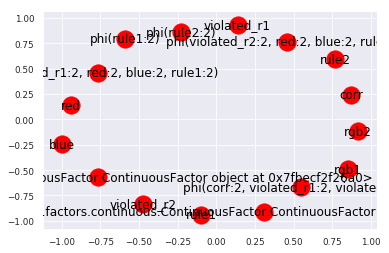

In [19]:
import networkx as nx
nx.draw_networkx(G)
plt.draw()

In [20]:
inference = VariableElimination(G)

In [21]:
q = inference.query(variables=['rule1', 'rule2', 'blue'], 
                evidence={'rgb1':[0,0.5,0.8], 'corr':1, 'rgb2':[1,0.8,0.4], 'red':1}, 
                elimination_order=['violated_r1', 'violated_r2'])
#print(q['red']._str())
print(q['blue']._str())
print(q['rule1']._str())
print(q['rule2']._str())
# print(q['violated_r1']._str())
# print(q['violated_r2']._str())

+--------+-------------+
| blue   |   phi(blue) |
+========+=============+
| blue_0 |      1.0000 |
+--------+-------------+
| blue_1 |      0.0000 |
+--------+-------------+
+---------+--------------+
| rule1   |   phi(rule1) |
+=========+==============+
| rule1_0 |       0.0000 |
+---------+--------------+
| rule1_1 |       1.0000 |
+---------+--------------+
+---------+--------------+
| rule2   |   phi(rule2) |
+=========+==============+
| rule2_0 |       0.9900 |
+---------+--------------+
| rule2_1 |       0.0100 |
+---------+--------------+


/home/mappelgren/Desktop/pgmpy/pgmpy/factors/discrete/DiscreteFactor.py:615: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi.values = phi.values[slice_]
/home/mappelgren/Desktop/pgmpy/pgmpy/factors/discrete/DiscreteFactor.py:627: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi1.values = phi1.values[slice_]


In [28]:
class PGMCorrectingAgent(CorrectingAgent):
    def __init__(self, world, colour_models=None, rule_beliefs=None,
                 domain_file='blocks-domain.pddl', teacher=None, threshold=0.7,
                 update_negative=True, update_once=True, colour_model_type='default',
                 model_config={}, tracker=Tracker()):
        
        
        
        super(PGMCorrectingAgent, self).__init__(world, colour_models, rule_beliefs,
                 domain_file, teacher, threshold,
                 update_negative, update_once, colour_model_type,
                 model_config, tracker)
        
        self.pgm_model = PGMModel()
        self.time = 0
        
        
        
    def update_goal(self):
        rule_probs = self.pgm_model.get_rule_probs(update_prior=True)
        for rule, p in rule_probs.items():
            #print(rule, p)
            rules = []
            if p > 0.5:
                rules.append(rule_asPDDL(rule))
        
        self.goal = goal_updates.goal_from_list(rules)
    
    def get_correction(self, user_input, actions, args, test=False):
        self.time += 1
        
        not_on_xy = pddl_functions.create_formula('on', args, op='not')
        self.tmp_goal = goal_updates.update_goal(self.tmp_goal, not_on_xy)
        #print(self.time)
        args_for_model = args.copy()
        #print(actions, args, user_input)
        #print(read_sentence(user_input, use_dmrs=False))
        message = read_sentence(user_input, use_dmrs=False)
        args_for_model = args.copy()
        if message.T == 'table':
            args_for_model += [message.o3]
        data = self.get_colour_data(args_for_model)
        violations = self.build_pgm_model(message, args)
        corr = 'corr_{}'.format(self.time)

        data[corr] = 1
        
        red = '{}({})'.format(message.o1[0], args[0])
        blue = '{}({})'.format(message.o2[0], args[1])
        if message.T == 'table':
            redo3 = '{}({})'.format(message.o1[0], message.o3)
            blueo3 = '{}({})'.format(message.o2[0], message.o3)
        
        if 't' in args[1]:
            data[blue] = 0
            
        self.pgm_model.observe(data)
        q = self.pgm_model.infer(list(violations))
        
        m_r1 = q[violations[0]].values[1]
        m_r2 = q[violations[1]].values[1]
        print(m_r1, m_r2)

        if max(m_r1, m_r2) < self.threshold:
            question = 'Is the top object {}'.format(message.o1[0])
            #dialogue.info('R: ' + question)
            answer = self.teacher.answer_question(question, self.world)
            #dialogue.info("T: " + answer)
            
            bin_answer = int(answer.lower() == 'yes')
            self.pgm_model.observe({red:bin_answer})
            q = self.pgm_model.infer(list(violations))
            m_r1 = q[violations[0]].values[1]
            m_r2 = q[violations[1]].values[1]
        
        
        #self.update_rules()
        
        
        
        self.update_cms()
        self.update_goal()
        self.world.back_track()
        #super(PGMCorrectingAgent, self).get_correction(user_input, actions, args, test=test)

    
    
    def update_cms(self):
        colours = self.pgm_model.get_colour_predictions()
        for cm in self.colour_models.values():
            cm.reset()
        
        
        for colour, p in colours.items():
            colour, arg = get_predicate(colour)
            arg = arg[0]
            fx = self.get_colour_data([arg])['F({})'.format(arg)]
            print(fx, p)
            self.colour_models[colour].update(fx, p)
        
    
    def add_cm(self, colour_name):
        try: 
            red_cm = self.colour_models[colour_name]
        except KeyError:
            red_cm = KDEColourModel(colour_name, **self.model_config)
            self.colour_models[colour_name] = red_cm
        return red_cm
    
    def build_pgm_model(self, message, args):

        rules = create_rules(message.o1[0], message.o2[0])
        red_cm = self.add_cm(message.o1[0])
        blue_cm = self.add_cm(message.o2[0])
        
        if message.T == 'tower':
            violations = self.pgm_model.create_tower_model(rules, red_cm, blue_cm, args, self.time)
        elif message.T == 'table':
            violations = self.pgm_model.create_table_model(rules, red_cm, blue_cm, args + [message.o3], self.time)
        #print(rules)
        return violations
        
        
    def get_colour_data(self, args):
        observation = self.world.sense()
        colour_data = observation.colours
        data = {'F({})'.format(arg): colour_data[arg] for arg in args if 't' not in arg}
        return data    
        
    
    def new_world(self, world):
        
        self.pgm_model = PGMModel()
        for cm in self.colour_models.values():
            cm.fix()
        
        super(PGMCorrectingAgent, self).new_world(world)
    

In [26]:


class PGMModel(object):
    
    def __init__(self):
        self.model = FactorGraph()
        self.inference = None
        self.known_rules = {}
        self.factors = set()
        self.observed = {}
        self.rule_priors = {}
        self.colours = []
        
    def add_cm(self, cm, block):
        
        red_rgb = 'F({})'.format(block)
        red_o1 = '{}({})'.format(cm.name, block)
        if 't' in block:
            self.model.add_nodes_from([red_o1])
            return red_o1
        if red_o1 not in self.model.nodes():        
            red_distribution = lambda rgb,c: cm.p(c, rgb)
            red_evidence = [red_rgb, red_o1]
            red_cm_factor = ContinuousFactor(red_evidence, red_distribution)
            self.add_factor(red_evidence + [red_cm_factor], red_cm_factor)
        self.colours.append(red_o1)
        return red_o1
        
        
    def update_model_no_corr(self, args, time):
        pass
        
    def add_factor(self, nodes, factor):
        node_filter = lambda x: filter(lambda y: y not in self.model.nodes(), x)
        self.factors.add(factor)
        self.model.add_nodes_from(node_filter(set(nodes + [factor])))
        self.model.add_factors(factor)
        
#     def node_filter(self, nodes):
#         return filter(lambda y: y not in self.model.nodes(), nodes)
        

    def get_rule_prior(self, rule):
        try:
            return self.rule_priors[rule]
        except KeyError:
            return 0.01
    
    def add_prior(self, rule):
        if rule not in self.known_rules:
            r1_prior = self.get_rule_prior(rule)

            r1_prior = DiscreteFactor([rule], [2], [1-r1_prior, r1_prior])
            self.add_factor([rule], r1_prior)
    
    def create_tower_model(self, rules, red_cm, blue_cm, args, time):
        

        # create the factors for the colour models

        o1, o2 = args[:2]
        
        red_o1 = self.add_cm(red_cm, o1)
        blue_o2 = self.add_cm(blue_cm, o2)
        
        r1, r2 = rules
        
        self.known_rules[r1] = [red_cm.name, blue_cm.name]
        self.known_rules[r2] = [red_cm.name, blue_cm.name]
        
        self.add_prior(r1)
        self.add_prior(r2)
        
        
        #Create the factors for the rule violation
        # Create the truth tables for each rule and their combination
        violated_r1 = generate_CPD(r1, red_cm.name, blue_cm.name)
        violated_r2 = generate_CPD(r2, red_cm.name, blue_cm.name)
        
        
        correction_table = or_CPD()
        
        Vr1 = 'V_{}({})'.format(time, r1)
        Vr2 = 'V_{}({})'.format(time, r2)
        corr = 'corr_{}'.format(time)
        
        
        
        r1_violated = TabularCPD(Vr1, 2, violated_r1, evidence=[red_o1, blue_o2, r1], evidence_card = [2,2,2])
        r1_violated_factor = r1_violated.to_factor()
        self.add_factor([Vr1, r1, r1_violated_factor], r1_violated_factor)
        
        r2_violated = TabularCPD(Vr2, 2, violated_r2, evidence=[red_o1, blue_o2, r2], evidence_card = [2,2,2])
        r2_violated_factor = r2_violated.to_factor()
        self.add_factor([Vr2, r2, r2_violated_factor], r2_violated_factor)
        
        
        correction = TabularCPD(corr, 2, correction_table, evidence=[Vr1, Vr2], evidence_card=[2,2])
        correction_factor = correction.to_factor()
        self.add_factor([corr, correction_factor], correction_factor)
        
    

        self.inference = VariableElimination(self.model)
        
        return Vr1, Vr2

    
    def create_table_model(self, rules, red_cm, blue_cm, args, time):
        o1, o2, o3 = args[:3]
        red_o1 = self.add_cm(red_cm, o1)
        blue_o2 = self.add_cm(blue_cm, o2)
        red_o3 = self.add_cm(red_cm, o3)
        blue_o3 = self.add_cm(blue_cm, o3)
    
        r1, r2 = rules
    
        self.known_rules[r1] = [red_cm.name, blue_cm.name]
        self.known_rules[r2] = [red_cm.name, blue_cm.name]
        
        self.add_prior(r1)
        self.add_prior(r2)
        
        r1_cpd = generate_table_cpd(1)
        r2_cpd = generate_table_cpd(2)
        correction_table = or_CPD()
        
        
        Vr1 = 'V_{}({})'.format(time, r1)
        Vr2 = 'V_{}({})'.format(time, r2)
        corr = 'corr_{}'.format(time)
        
        r1_evidence = [r1, red_o1, blue_o2, red_o3, blue_o3]
        r1_violated = TabularCPD(Vr1, 2, r1_cpd, evidence=r1_evidence, evidence_card=[2,2,2,2,2])
        self.add_factor(r1_evidence + [Vr1], r1_violated.to_factor())
        
        r2_evidence = [r2, red_o1, blue_o2, red_o3, blue_o3]
        r2_violated = TabularCPD(Vr2, 2, r2_cpd, evidence=r2_evidence, evidence_card=[2,2,2,2,2])
        self.add_factor(r2_evidence + [Vr2], r2_violated.to_factor())
        
        correction =  TabularCPD(corr, 2, correction_table, evidence=[Vr1, Vr2], evidence_card=[2,2])
        self.add_factor([Vr1, Vr2, corr], correction.to_factor())
        
        self.inference = VariableElimination(self.model)
        return Vr1, Vr2
    
    
    def observe(self, observable={}):
        self.observed.update(observable)
        
    def infer(self, targets=[]):
        #print(self.observed.keys())
        #print(targets)
        hidden = set(self.model.nodes) - set(self.observed.keys()) - self.factors - set(targets)
        #print(hidden)
        q = self.inference.query(variables=targets, 
                evidence=self.observed, 
                elimination_order=hidden)
        self.query = q
        return q
        
    def get_rule_probs(self, update_prior=False):
        rules = list(self.known_rules.keys())
        q = self.infer(rules)
        if update_prior:
            for rule in rules:
                self.rule_priors[rule] = q[rule].values[1]
        return {rule: q[rule].values[1] for rule in rules}
        
    def get_colour_predictions(self):
        colours = [c for c in self.colours if c not in self.observed]
        q = self.infer(colours)

        out = dict(((c,q[c].values[1]) if c not in self.observed else (c,self.observed[c]) for c in self.colours))
        return out

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem48.pddl
Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem48.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


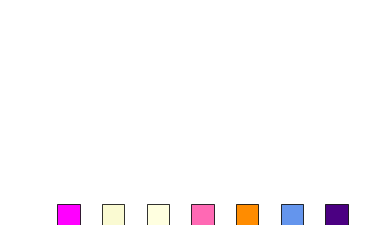

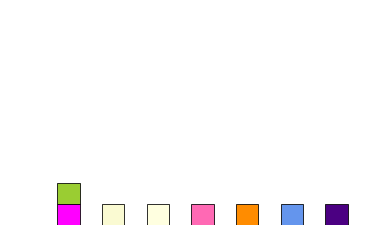

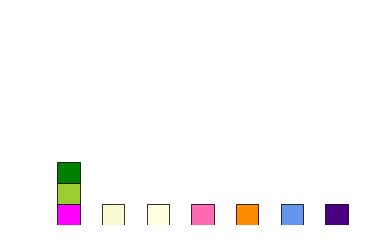

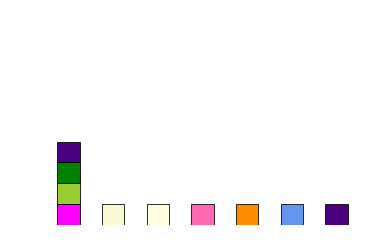

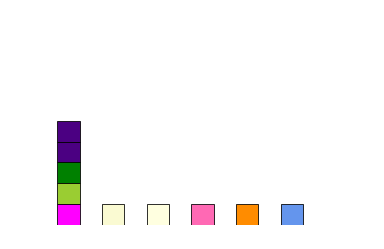

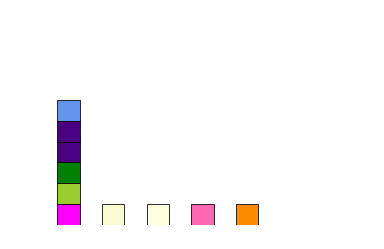

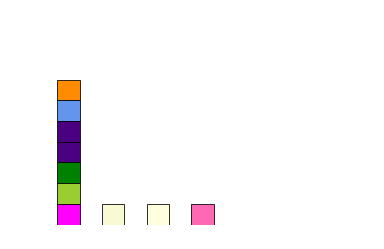

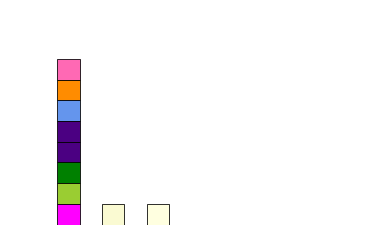

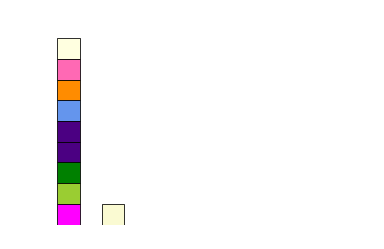

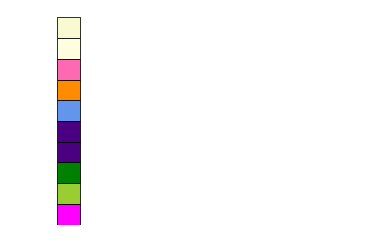

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem26.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


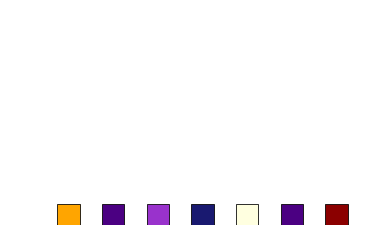

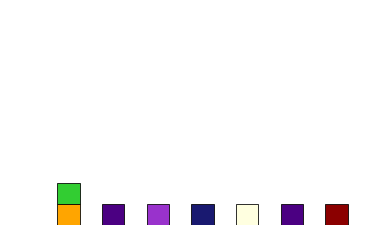

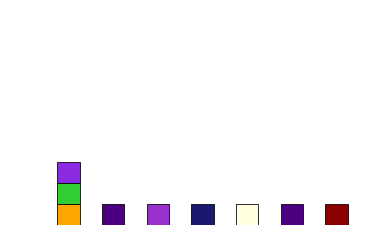

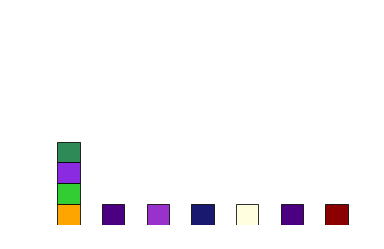

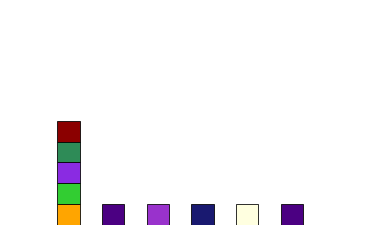

T: no, put red blocks on blue blocks
0.5 0.5
[0.54509807 0.         0.        ] 1
[0.18039216 0.54509807 0.34117648] 0.0


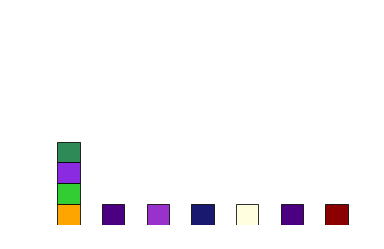

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


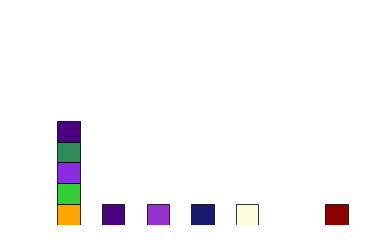

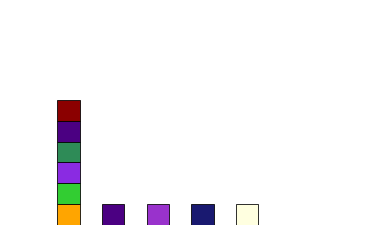

T: no, put red blocks on blue blocks
1.0 0.0
[0.54509807 0.         0.        ] 1
[0.18039216 0.54509807 0.34117648] 0.0
[0.29411766 0.         0.50980395] 0.0


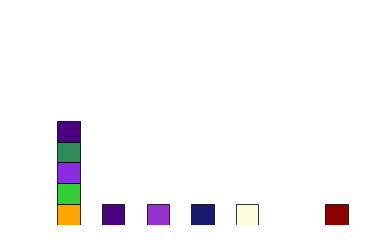

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


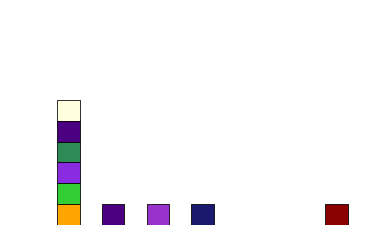

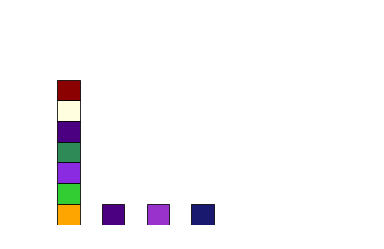

T: no, put red blocks on blue blocks
1.0 0.0
[0.54509807 0.         0.        ] 1
[0.18039216 0.54509807 0.34117648] 0.0
[0.29411766 0.         0.50980395] 0.0
[1.        1.        0.8784314] 0.0


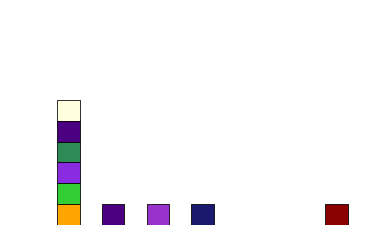

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


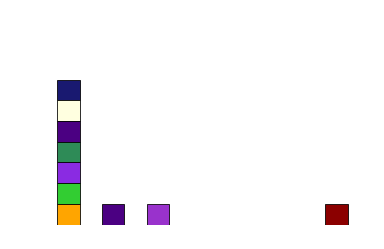

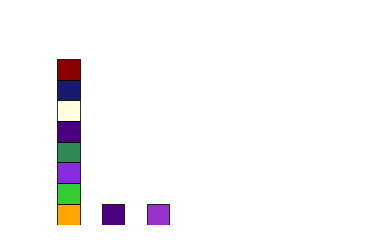

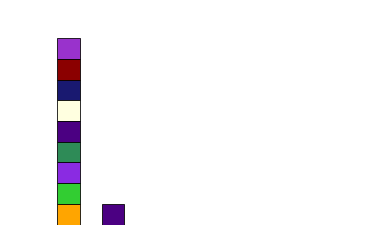

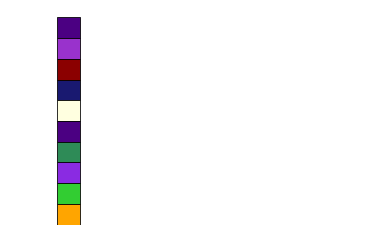

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem20.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


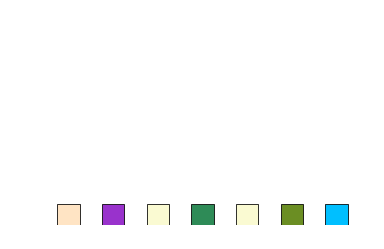

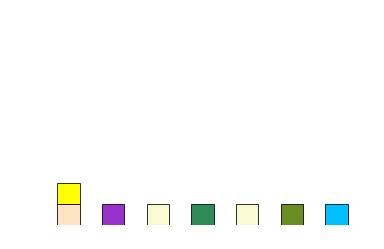

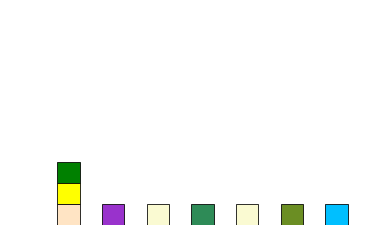

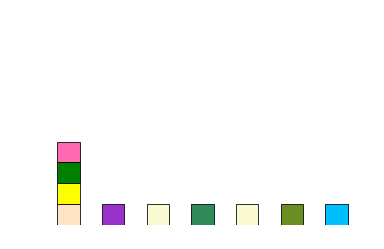

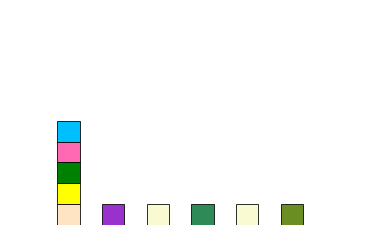

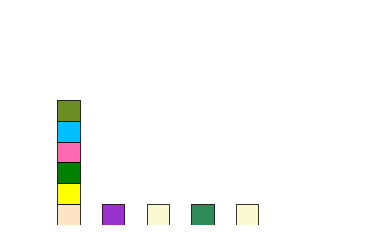

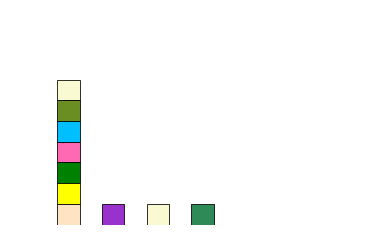

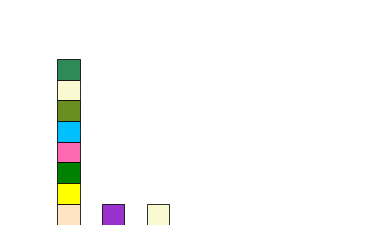

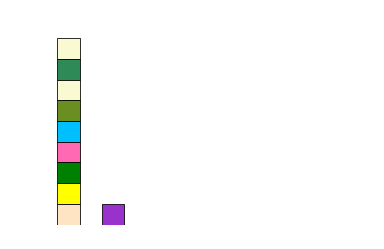

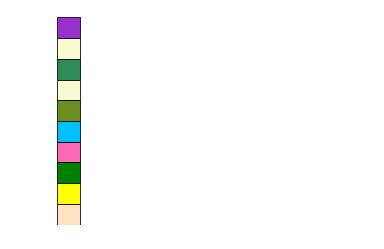

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem45.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


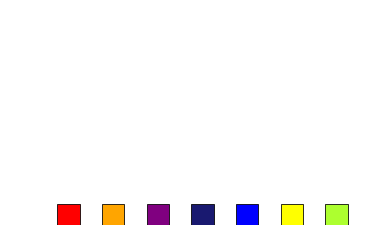

T: no, put red blocks on blue blocks
1.0 0.0
[1. 0. 0.] 1.0


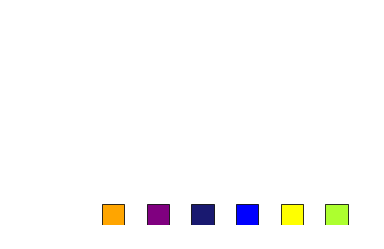

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


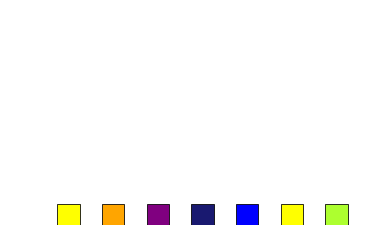

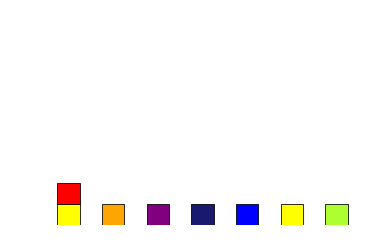

T: no, put red blocks on blue blocks
1.0 0.0
[1. 0. 0.] 1.0
[1. 1. 0.] 0.0


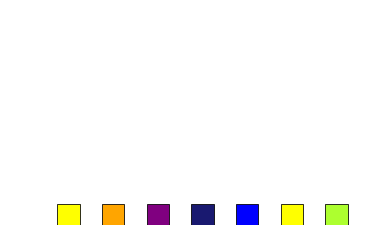

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


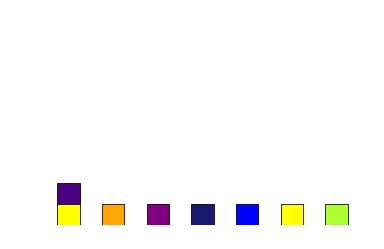

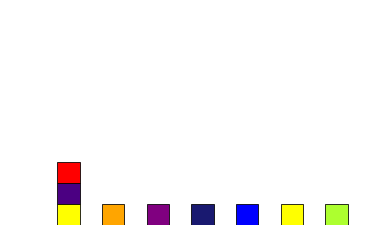

T: no, put red blocks on blue blocks
1.0 0.0
[1. 0. 0.] 1.0
[1. 1. 0.] 0.0
[0.29411766 0.         0.50980395] 0.0


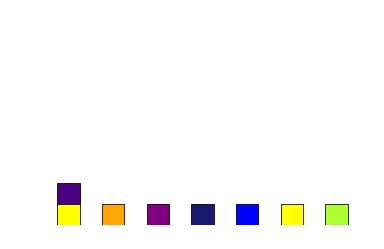

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


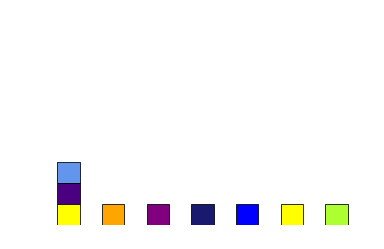

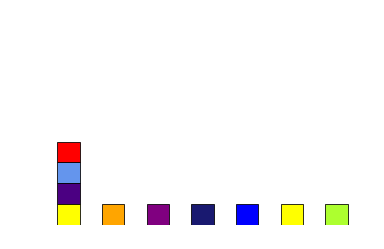

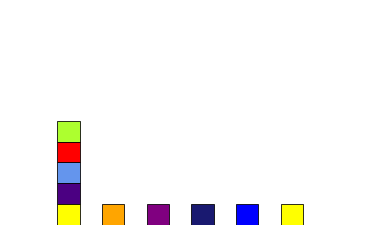

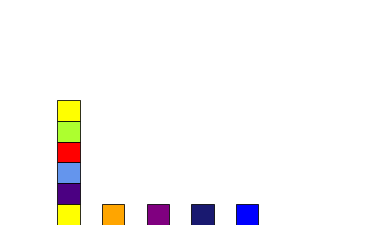

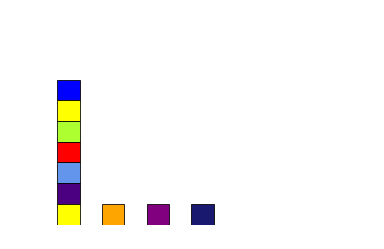

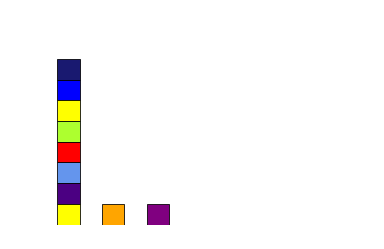

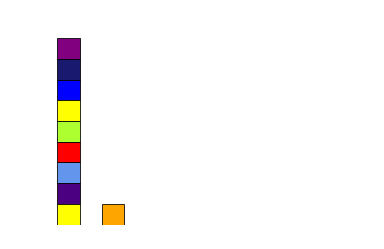

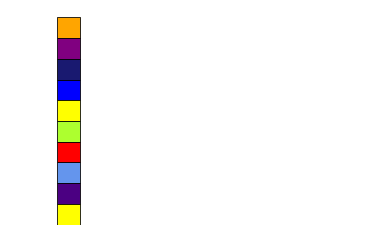

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem18.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


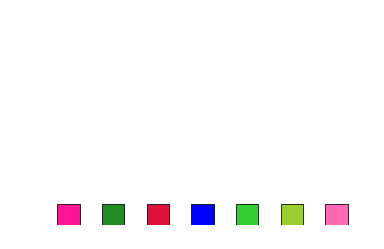

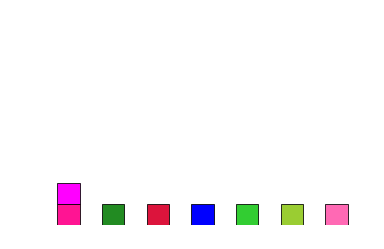

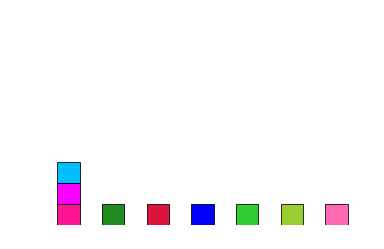

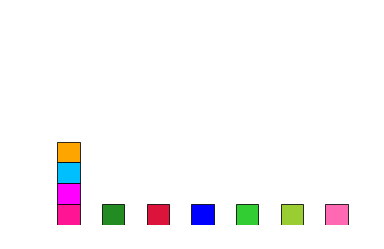

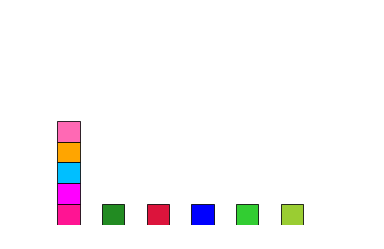

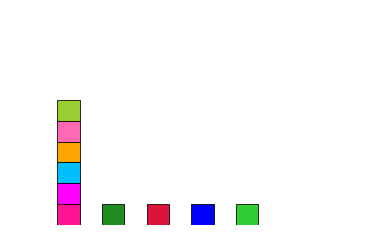

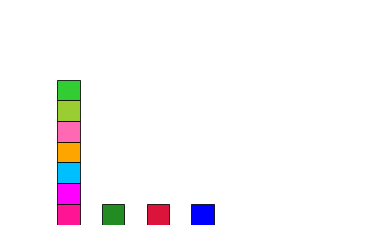

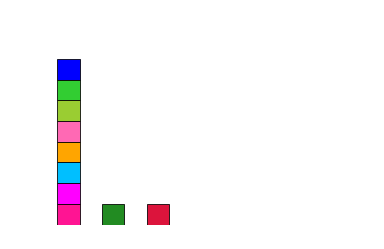

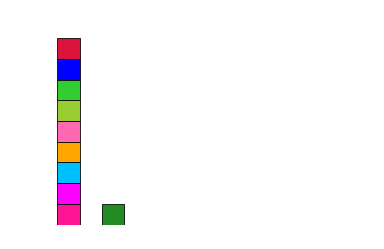

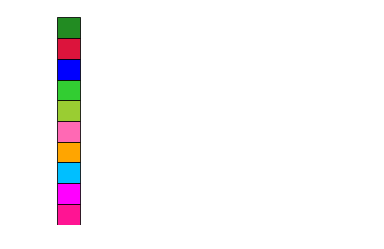

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem1.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


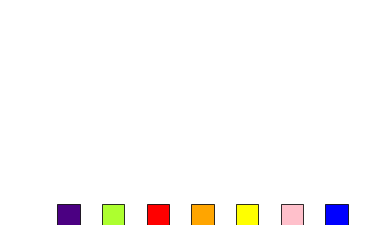

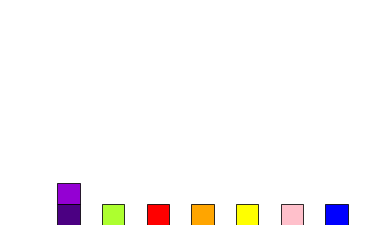

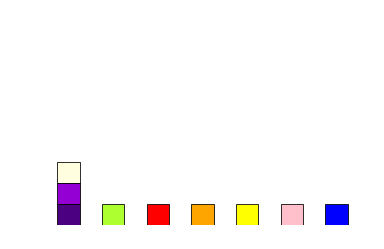

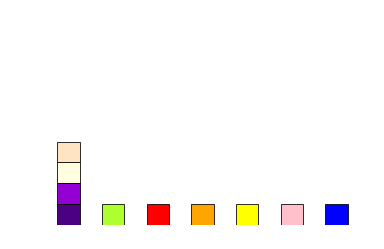

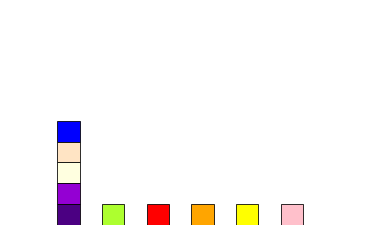

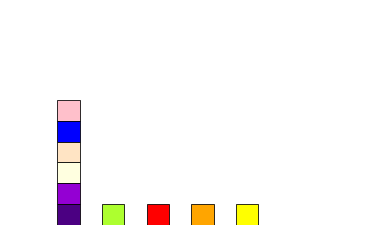

T: No, now you cannot put b1 in the tower because you must put red blocks on blue blocks
0.024648907770439855 0.9753510922295602
[1.         0.7529412  0.79607844] 0.048052198535420136
[0. 0. 1.] 0.9519478014645799
[1. 0. 0.] 0.97597390073229
[1. 0. 0.] 0.049293283863884645


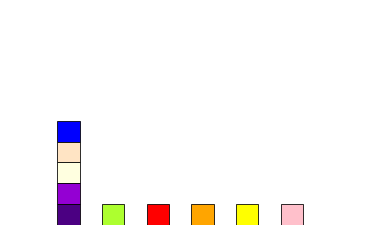

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


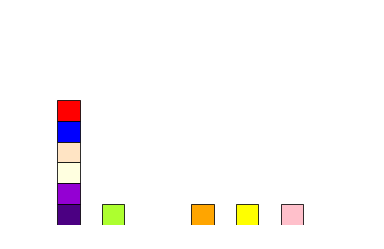

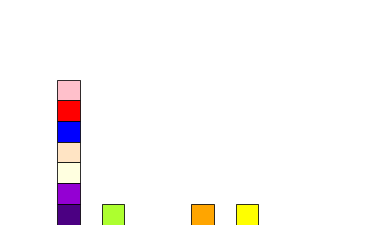

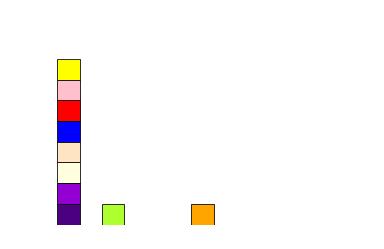

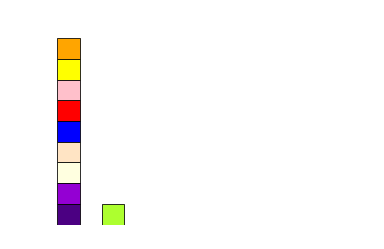

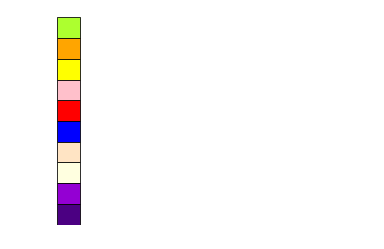

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem36.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


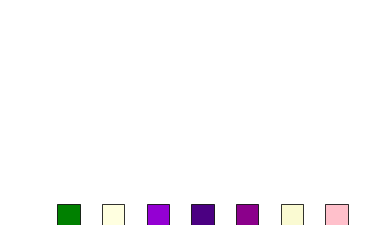

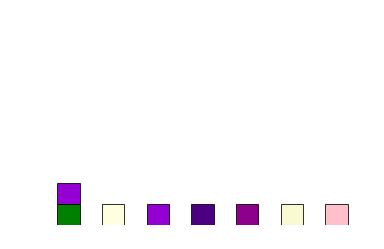

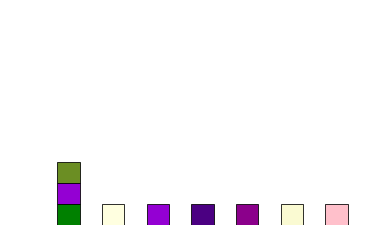

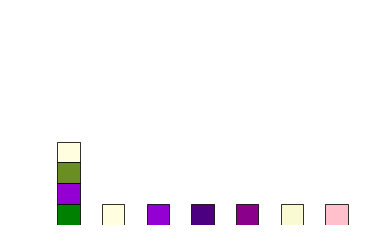

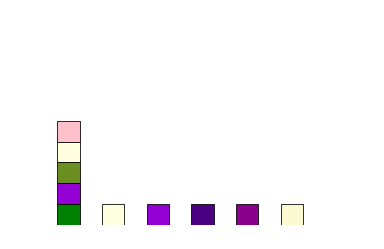

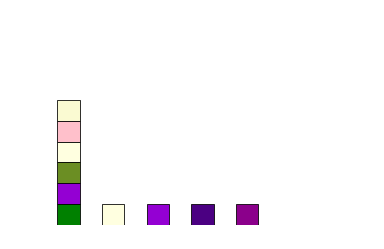

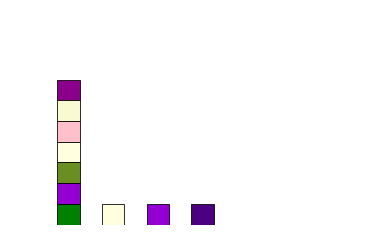

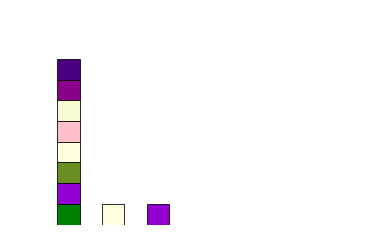

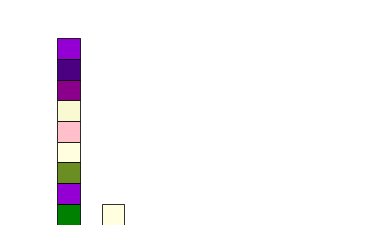

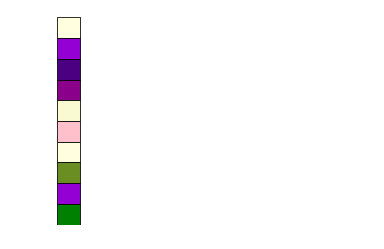

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem41.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


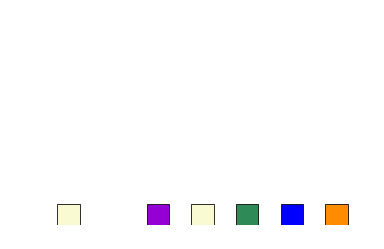

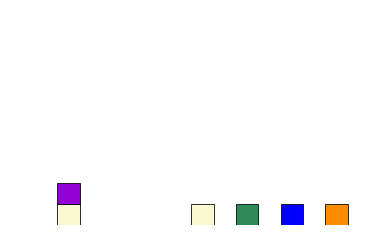

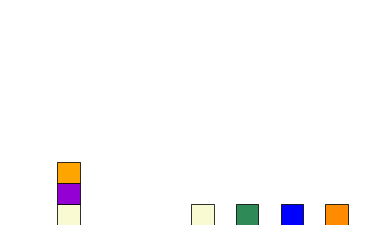

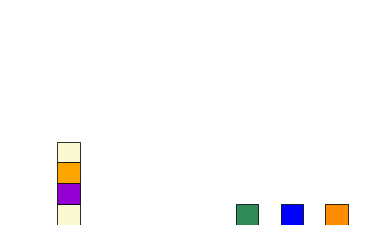

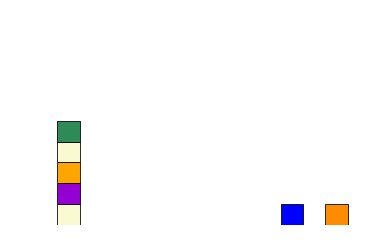

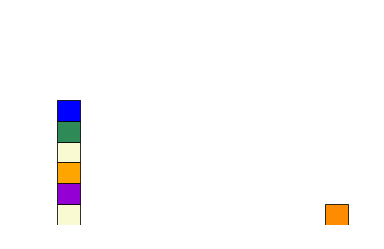

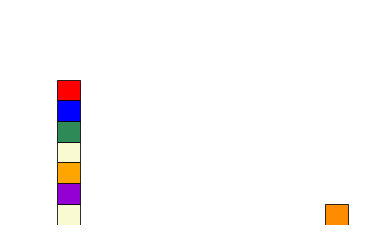

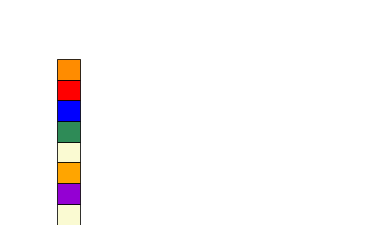

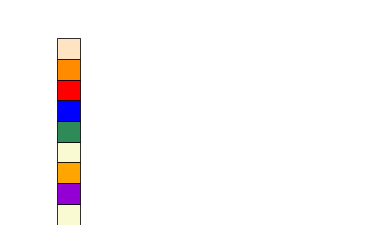

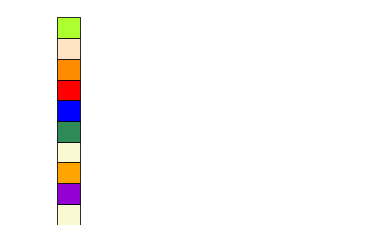

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem44.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


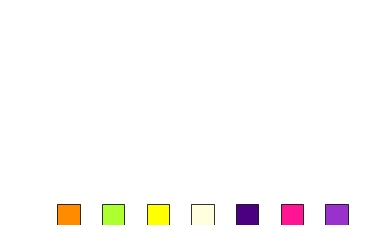

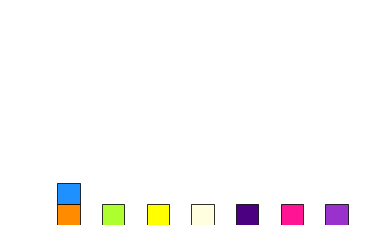

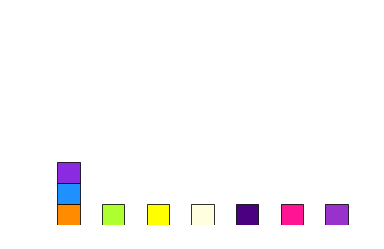

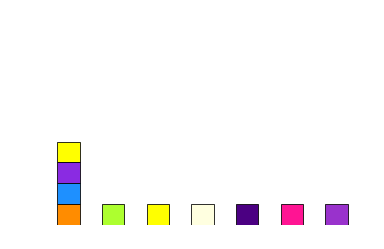

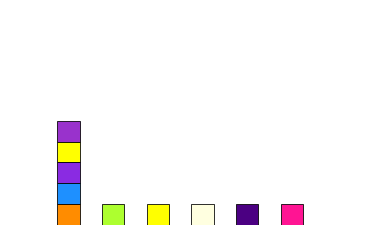

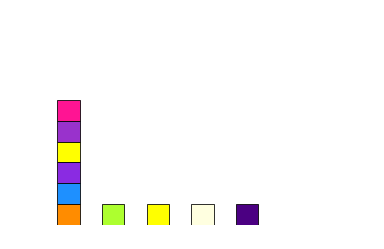

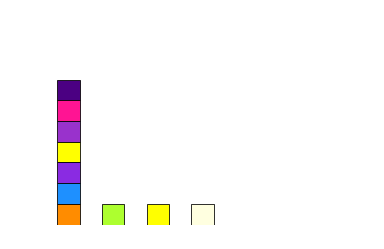

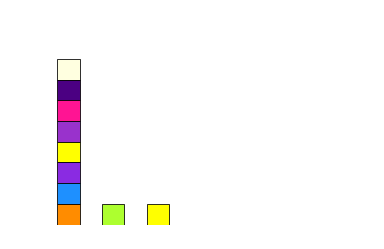

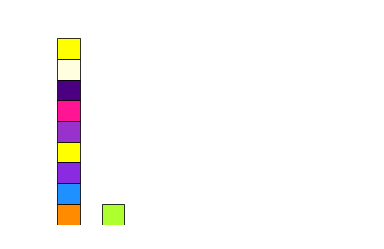

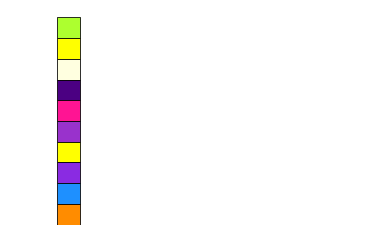

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem40.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


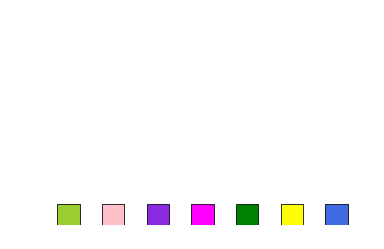

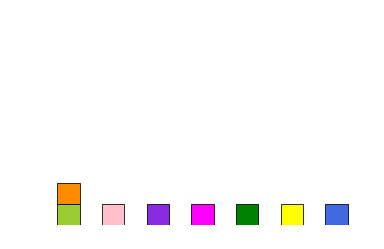

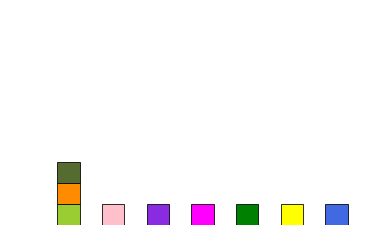

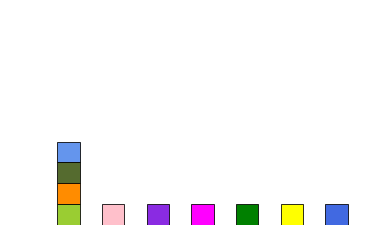

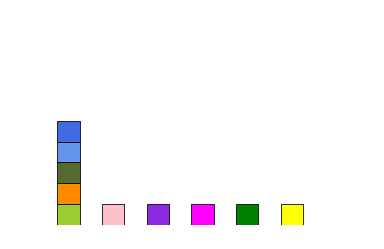

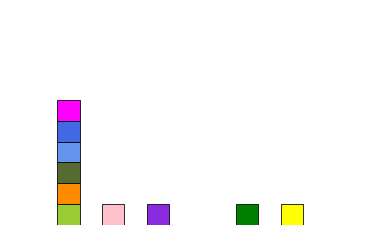

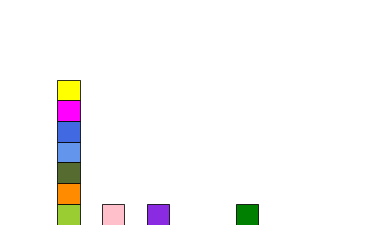

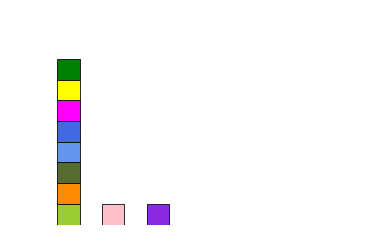

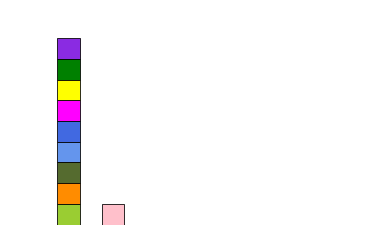

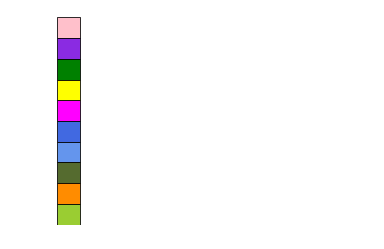

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem31.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


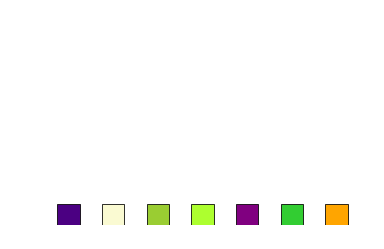

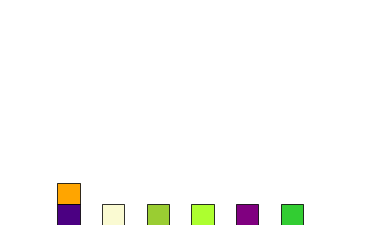

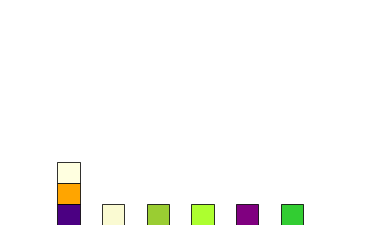

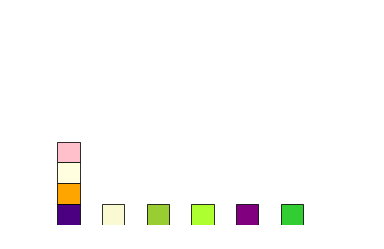

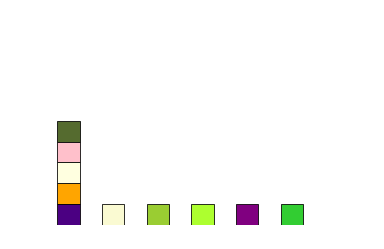

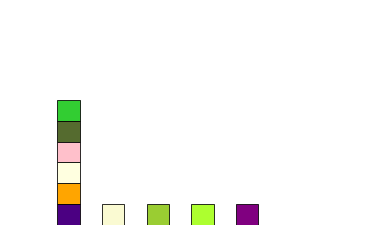

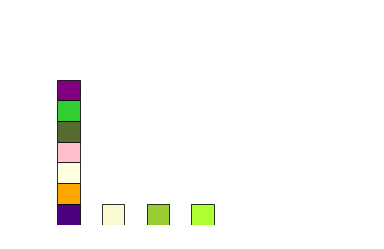

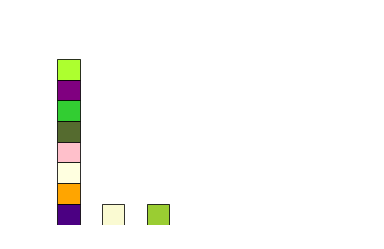

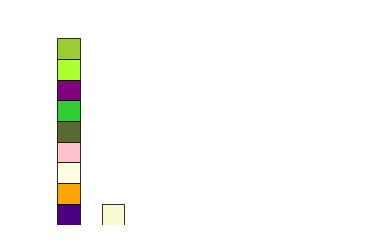

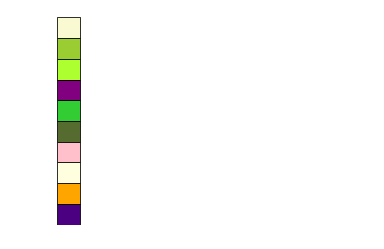

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem27.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


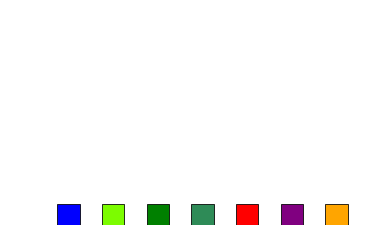

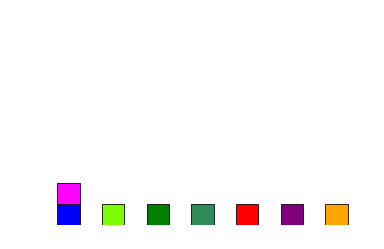

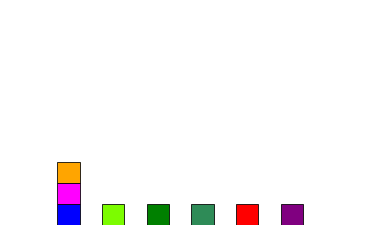

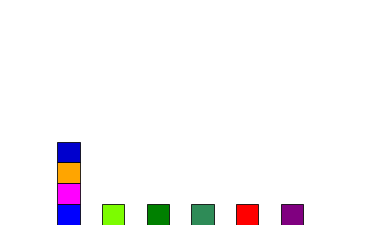

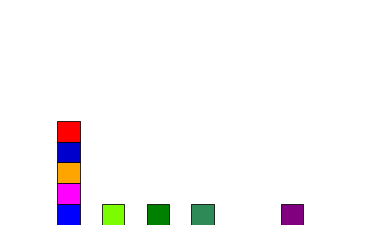

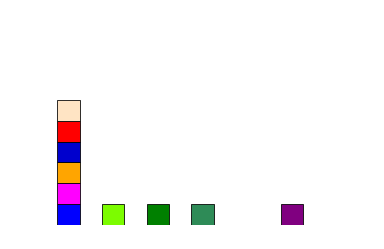

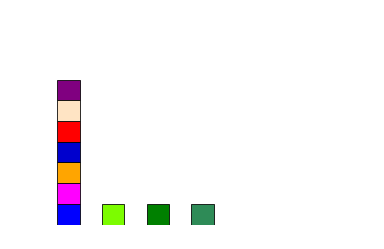

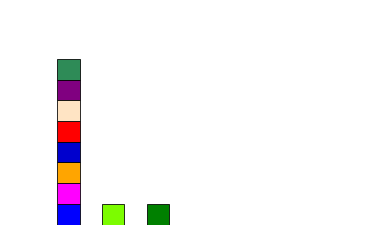

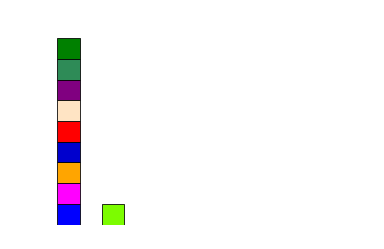

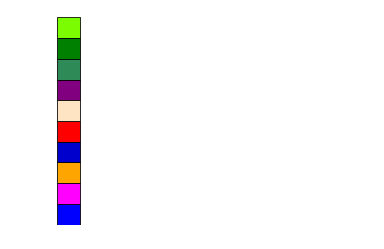

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem37.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


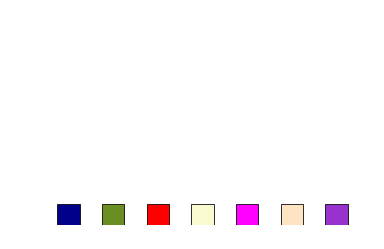

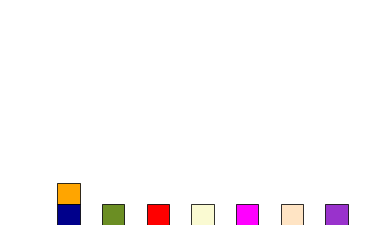

T: No, now you cannot put b1 in the tower because you must put red blocks on blue blocks
0.9867033069926333 0.013296693007366679
[1.         0.64705884 0.        ] 0.9613439970764587
[0.         0.         0.54509807] 0.038656002923541335
[1. 0. 0.] 0.5193280014617706
[1. 0. 0.] 0.9999581974930528


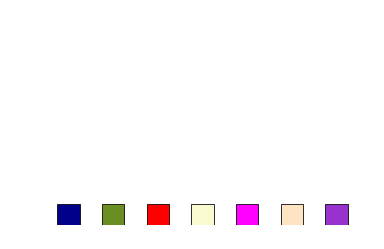

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


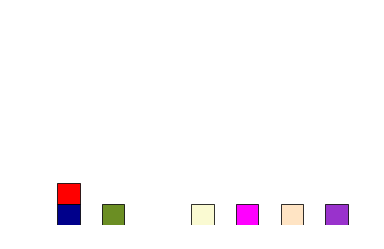

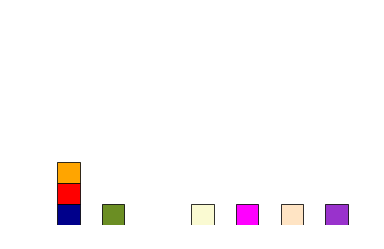

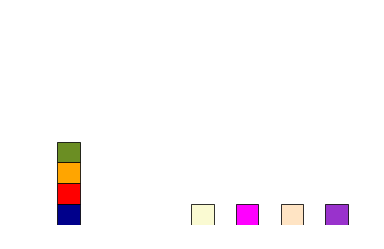

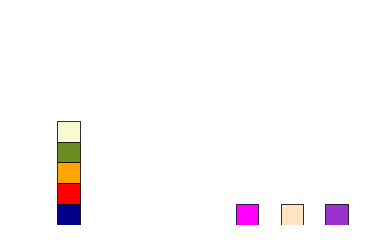

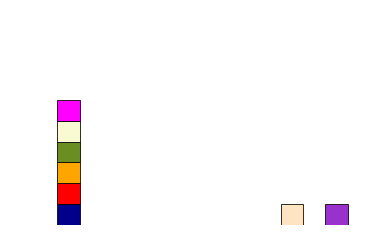

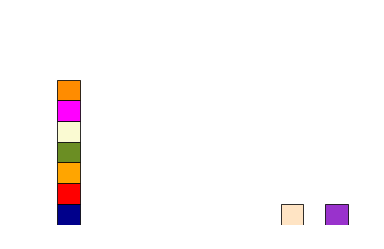

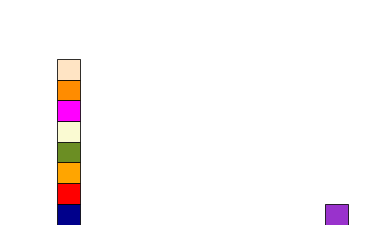

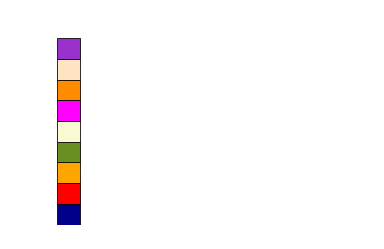

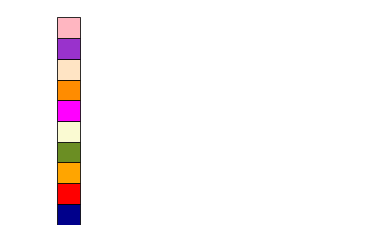

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem33.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


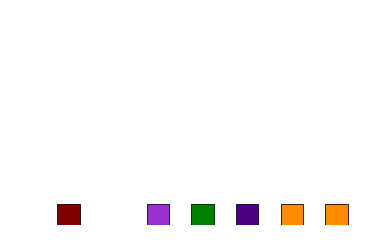

T: no, put red blocks on blue blocks
1.0 0.0
[0.5019608 0.        0.       ] 1.0


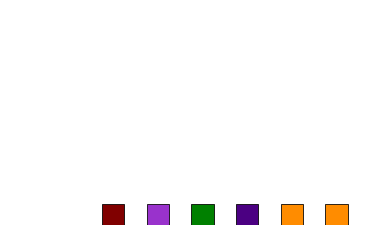

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


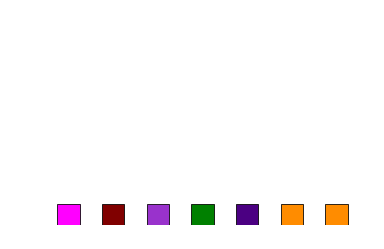

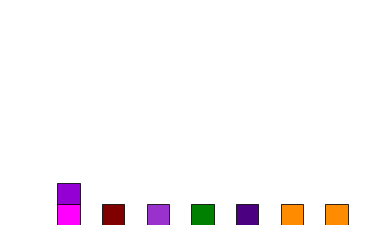

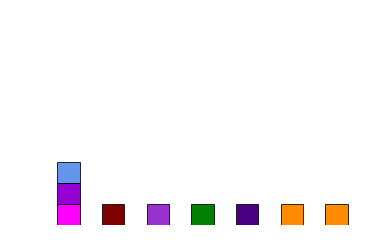

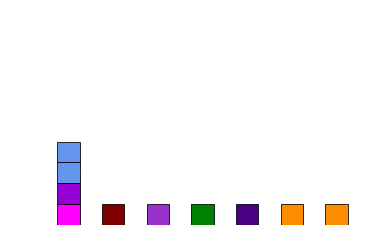

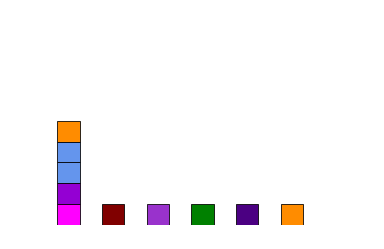

T: No, now you cannot put b0 in the tower because you must put red blocks on blue blocks
4.696322256854666e-07 0.9999995303677743
[0.5019608 0.        0.       ] 1.0
[1.         0.54901963 0.        ] 0.0001854786682841313
[0.39215687 0.58431375 0.92941177] 0.9998145213317159
[0.5019608 0.        0.       ] 0.0003008634640556661


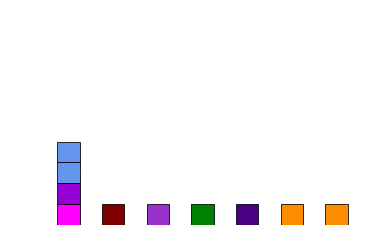

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


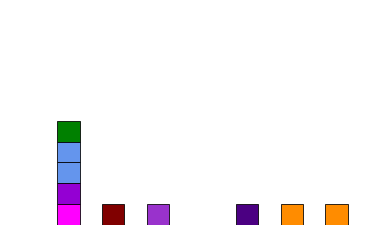

T: No, now you cannot put b0 in the tower because you must put red blocks on blue blocks
0.9992701940290655 0.0007298059709345273
[0.5019608 0.        0.       ] 1.0
[1.         0.54901963 0.        ] 0.001203994929638382
[0.39215687 0.58431375 0.92941177] 0.9987960050703616
[0.5019608 0.        0.       ] 0.5006019974648191
[0.        0.5019608 0.       ] 0.001203994929638382


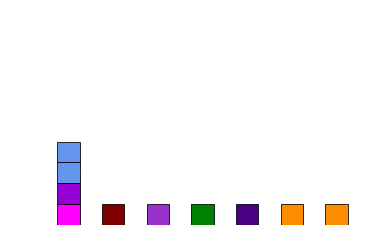

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


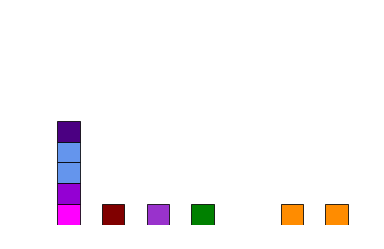

T: No, now you cannot put b0 in the tower because you must put red blocks on blue blocks
0.4822679484094129 0.5177320515905871
[0.5019608 0.        0.       ] 1.0
[1.         0.54901963 0.        ] 0.0
[0.39215687 0.58431375 0.92941177] 1.0
[0.5019608 0.        0.       ] 0.5
[0.        0.5019608 0.       ] 0.0
[0.29411766 0.         0.50980395] 0


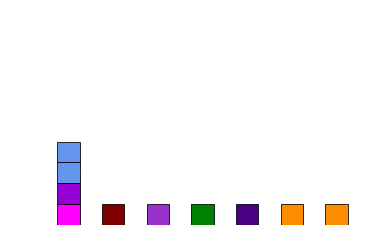

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


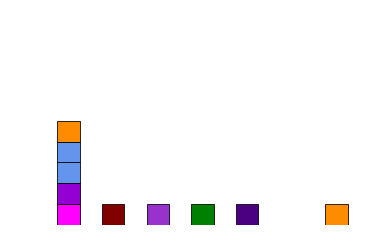

T: No, now you cannot put b0 in the tower because you must put red blocks on blue blocks
1.0 0.0
[0.5019608 0.        0.       ] 1.0
[1.         0.54901963 0.        ] 0.0
[0.39215687 0.58431375 0.92941177] 1.0
[0.5019608 0.        0.       ] 0.5
[0.        0.5019608 0.       ] 0.0
[0.29411766 0.         0.50980395] 0
[1.         0.54901963 0.        ] 0.0


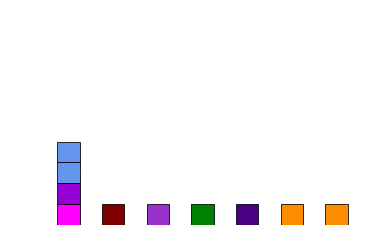

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


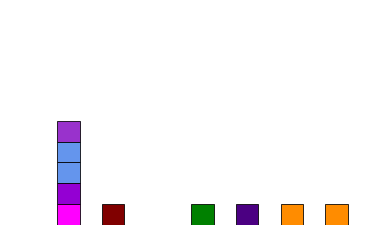

T: No, now you cannot put b0 in the tower because you must put red blocks on blue blocks
1.0 0.0
[0.5019608 0.        0.       ] 1.0
[1.         0.54901963 0.        ] 0.0
[0.39215687 0.58431375 0.92941177] 1.0
[0.5019608 0.        0.       ] 0.5
[0.        0.5019608 0.       ] 0.0
[0.29411766 0.         0.50980395] 0
[1.         0.54901963 0.        ] 0.0
[0.6        0.19607843 0.8       ] 0.0


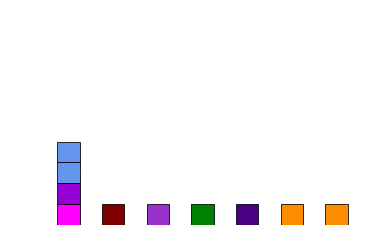

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


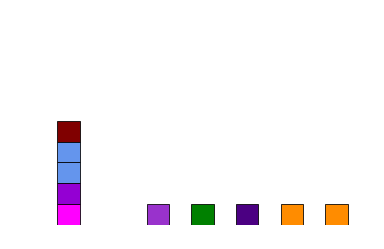

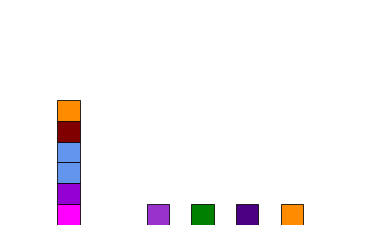

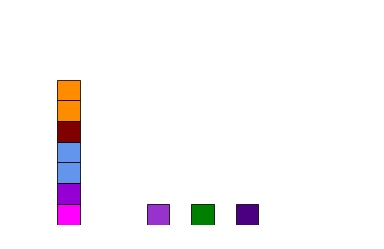

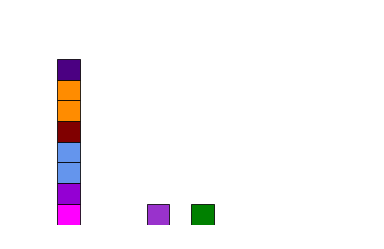

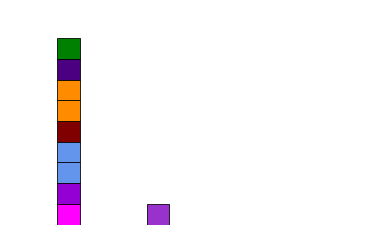

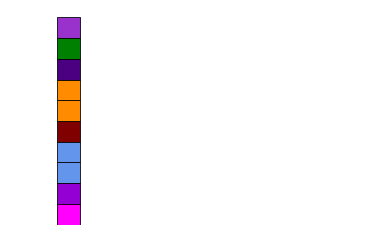

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem34.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


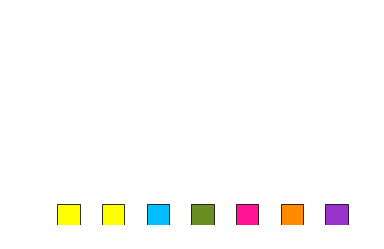

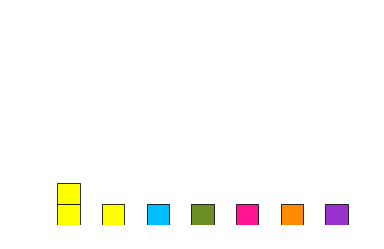

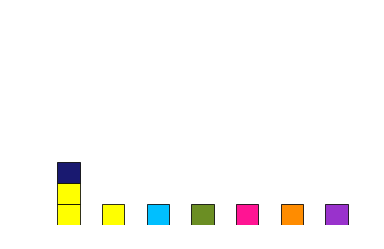

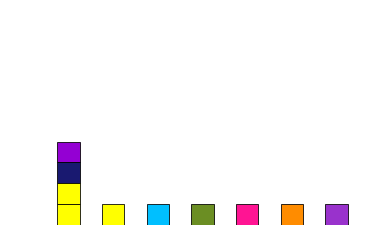

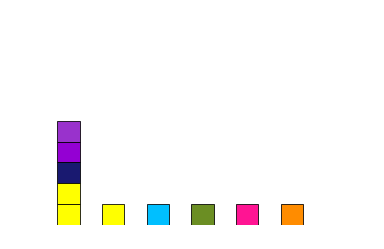

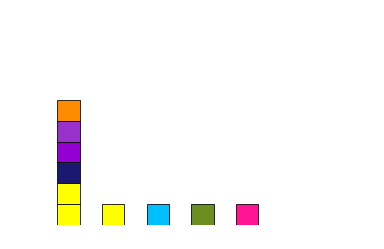

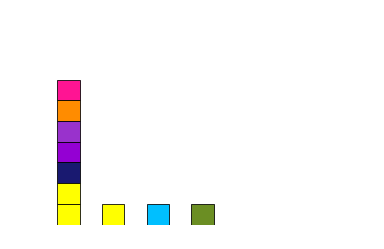

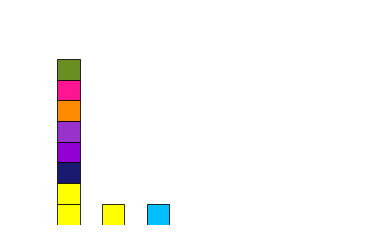

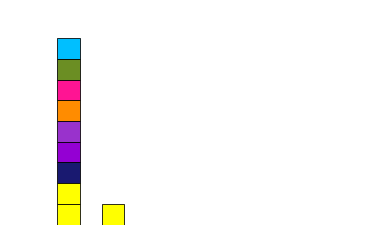

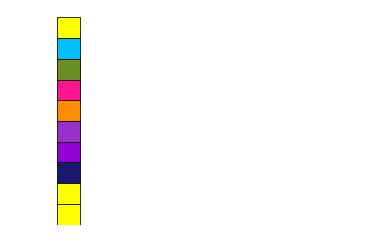

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem46.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


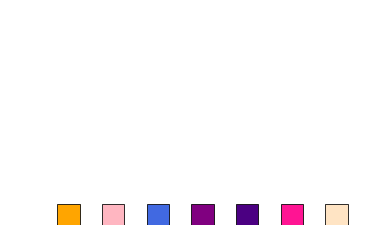

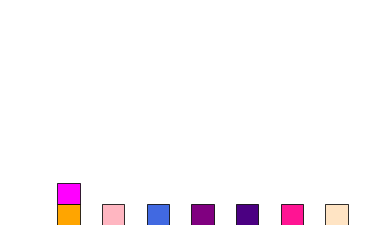

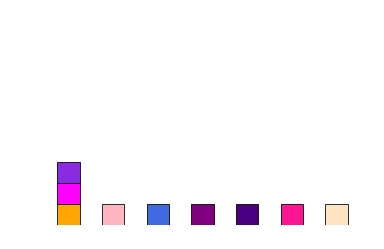

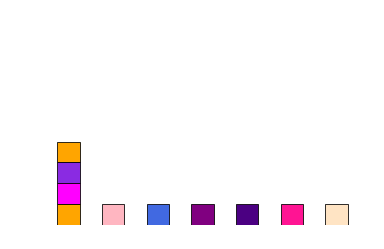

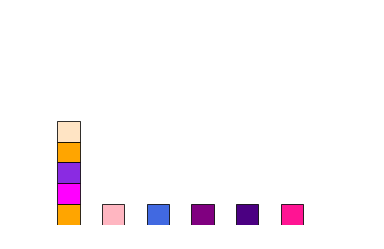

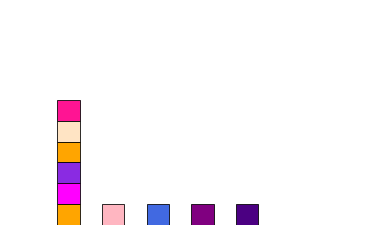

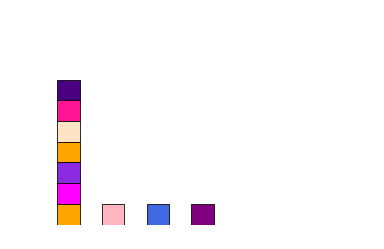

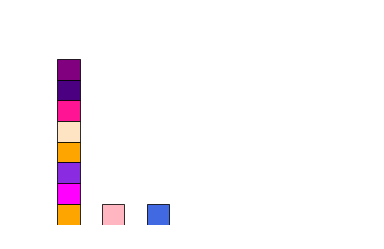

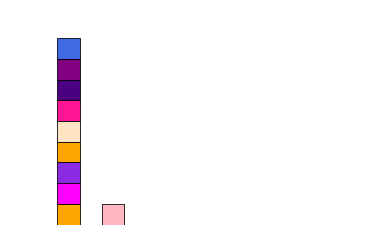

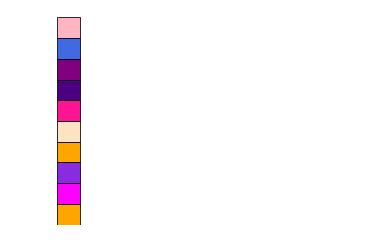

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem50.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


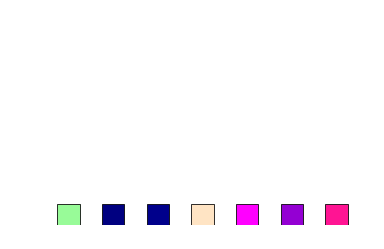

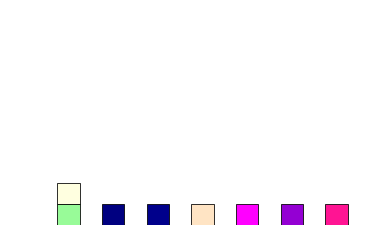

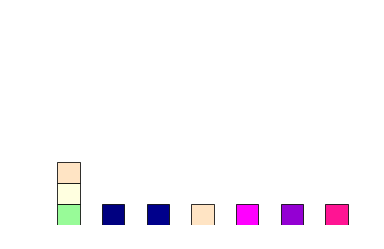

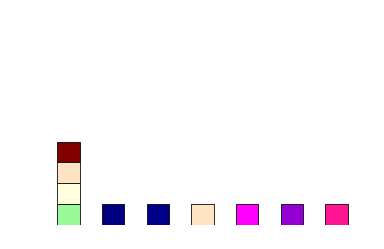

T: no, put red blocks on blue blocks
0.4254875684152297 0.5745124315847703
[0.5019608 0.        0.       ] 1
[1.         0.89411765 0.76862746] 0.0


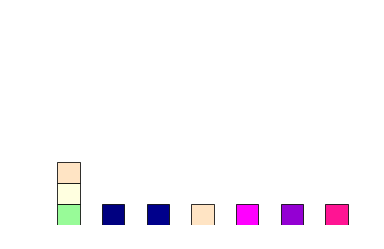

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


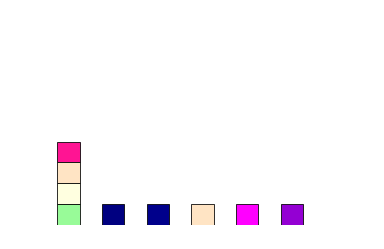

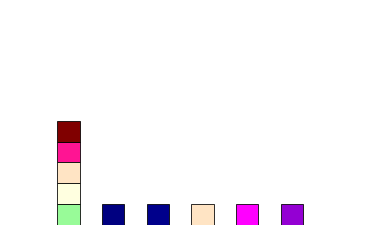

T: no, put red blocks on blue blocks
1.0 0.0
[0.5019608 0.        0.       ] 1
[1.         0.89411765 0.76862746] 0.0
[1.         0.07843138 0.5764706 ] 0.0


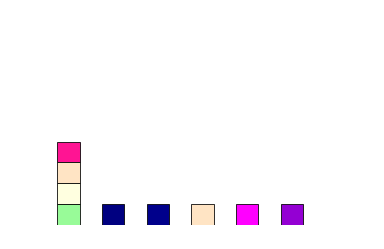

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


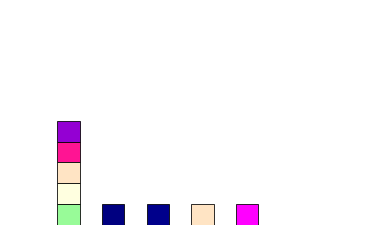

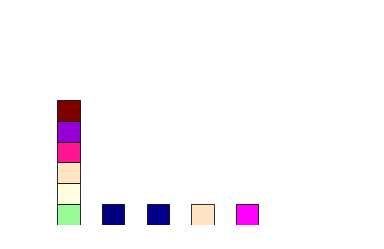

T: no, put red blocks on blue blocks
1.0 0.0
[0.5019608 0.        0.       ] 1
[1.         0.89411765 0.76862746] 0.0
[1.         0.07843138 0.5764706 ] 0.0
[0.5803922 0.        0.827451 ] 0.0


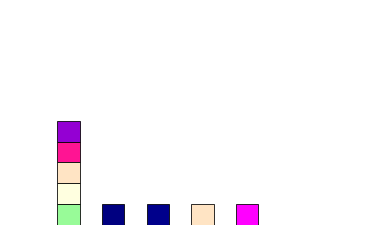

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


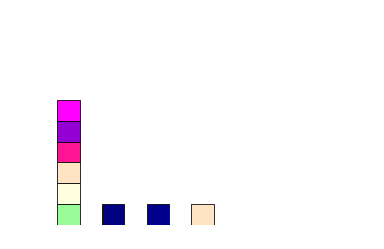

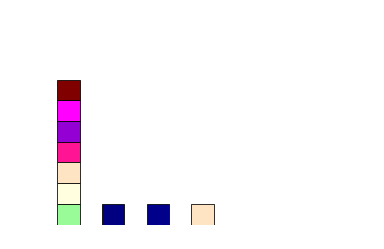

T: no, put red blocks on blue blocks
1.0 0.0
[0.5019608 0.        0.       ] 1
[1.         0.89411765 0.76862746] 0.0
[1.         0.07843138 0.5764706 ] 0.0
[0.5803922 0.        0.827451 ] 0.0
[1. 0. 1.] 0.0


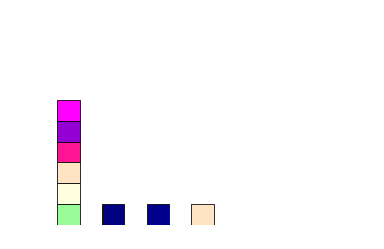

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


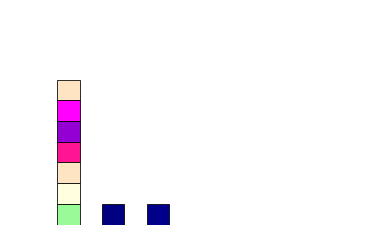

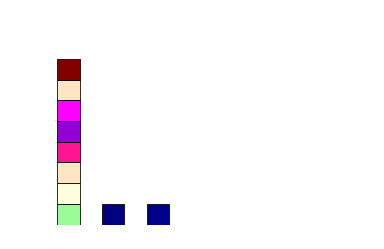

T: no, put red blocks on blue blocks
1.0 0.0
[0.5019608 0.        0.       ] 1
[1.         0.89411765 0.76862746] 0.0
[1.         0.07843138 0.5764706 ] 0.0
[0.5803922 0.        0.827451 ] 0.0
[1. 0. 1.] 0.0
[1.         0.89411765 0.76862746] 0.0


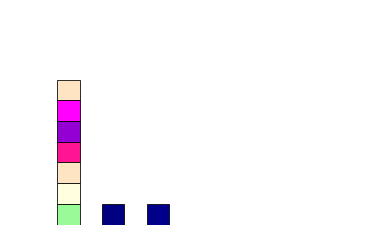

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


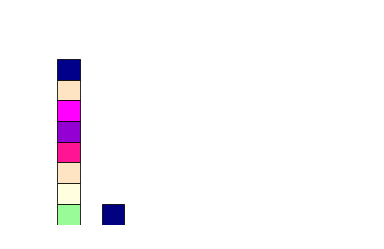

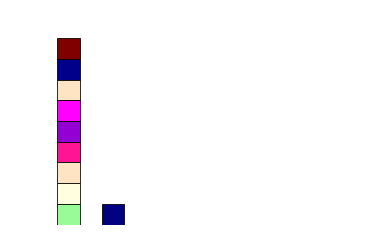

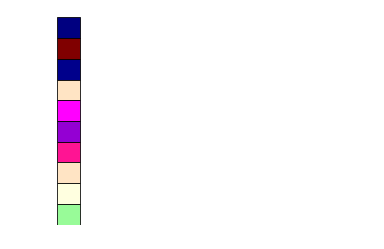

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem2.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


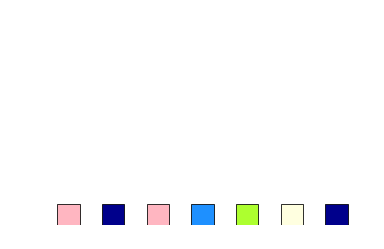

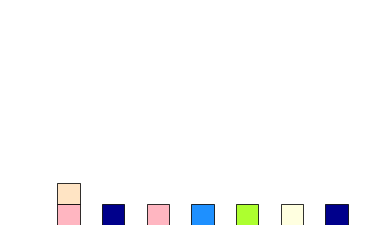

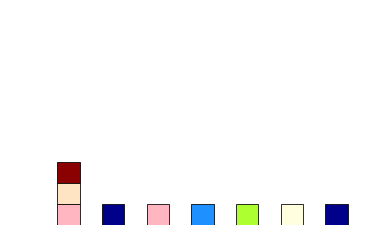

T: no, put red blocks on blue blocks
0.4946944149532067 0.5053055850467933
[0.54509807 0.         0.        ] 1
[1.         0.89411765 0.76862746] 0.0


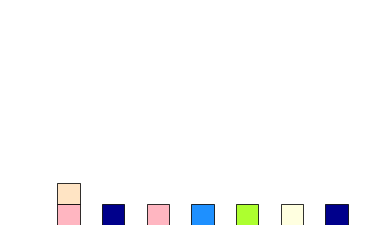

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


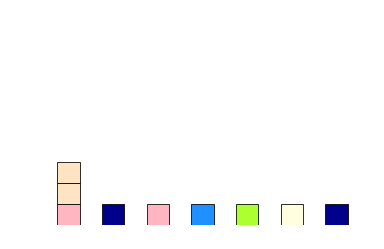

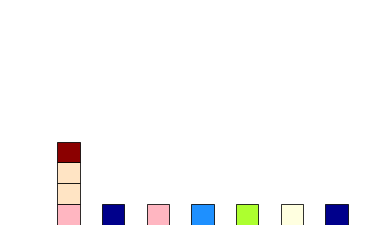

T: no, put red blocks on blue blocks
1.0 0.0
[0.54509807 0.         0.        ] 1
[1.         0.89411765 0.76862746] 0.0
[1.         0.89411765 0.76862746] 0.0


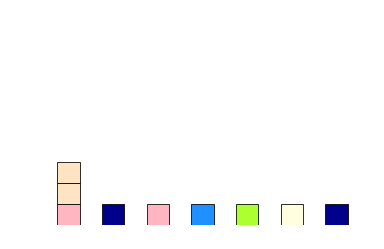

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


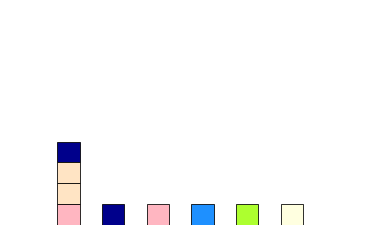

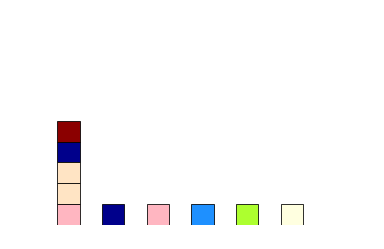

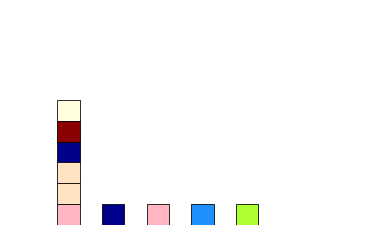

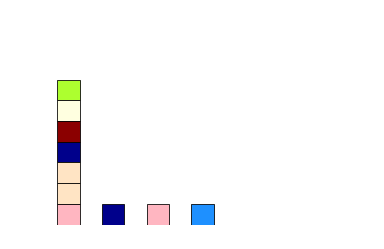

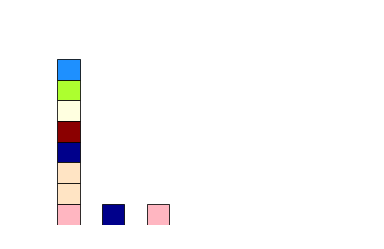

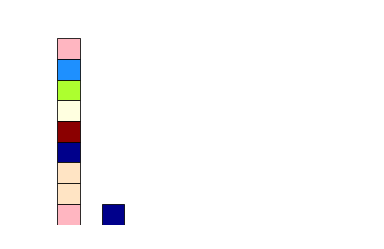

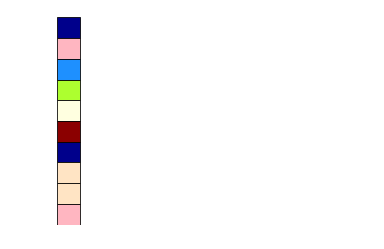

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem23.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


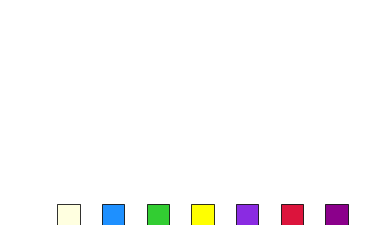

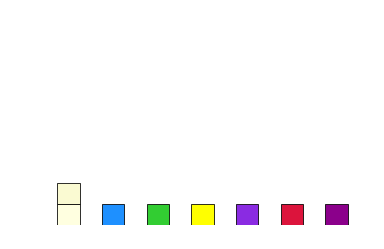

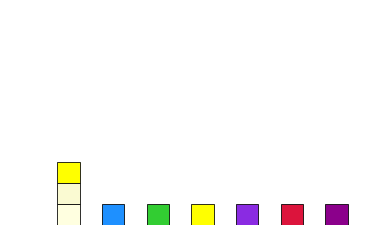

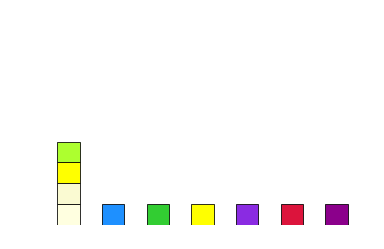

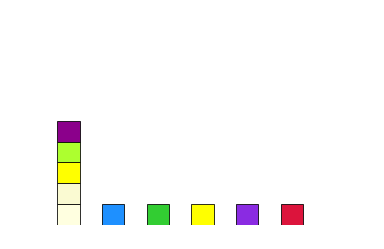

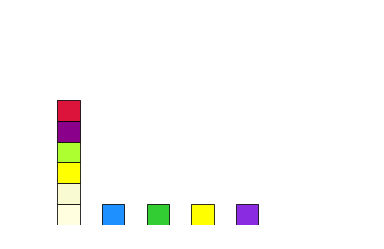

T: no, put red blocks on blue blocks
0.5278412711599243 0.4721587288400758
[0.8627451  0.07843138 0.23529412] 1
[0.54509807 0.         0.54509807] 0.0


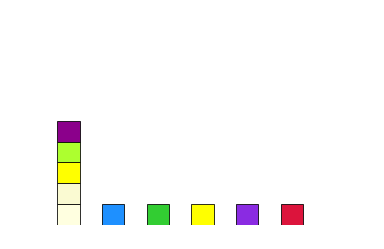

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


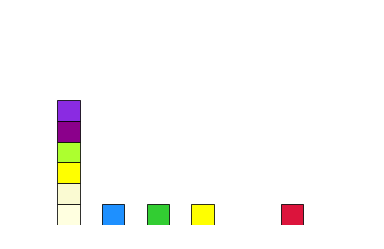

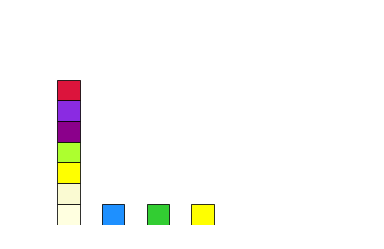

T: no, put red blocks on blue blocks
1.0 0.0
[0.8627451  0.07843138 0.23529412] 1
[0.54509807 0.         0.54509807] 0.0
[0.5411765  0.16862746 0.8862745 ] 0.0


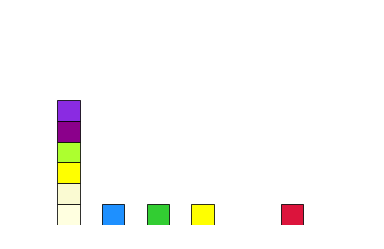

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


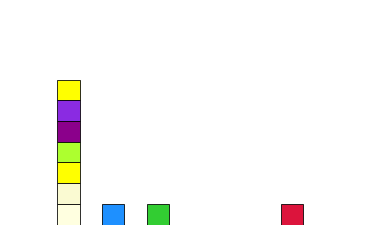

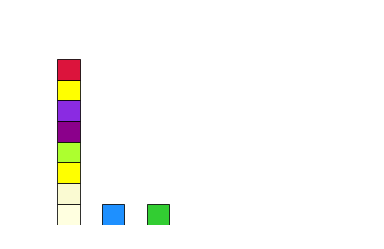

T: no, put red blocks on blue blocks
1.0 0.0
[0.8627451  0.07843138 0.23529412] 1
[0.54509807 0.         0.54509807] 0.0
[0.5411765  0.16862746 0.8862745 ] 0.0
[1. 1. 0.] 0.0


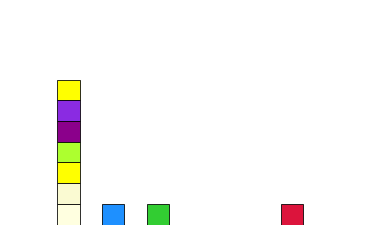

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


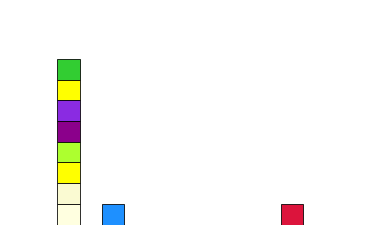

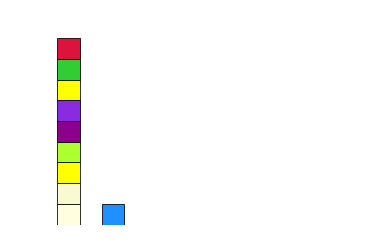

T: no, put red blocks on blue blocks
1.0 0.0
[0.8627451  0.07843138 0.23529412] 1
[0.54509807 0.         0.54509807] 0.0
[0.5411765  0.16862746 0.8862745 ] 0.0
[1. 1. 0.] 0.0
[0.19607843 0.8039216  0.19607843] 0.0


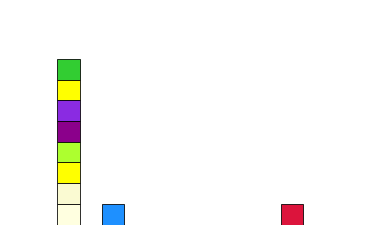

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


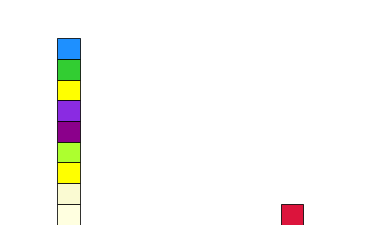

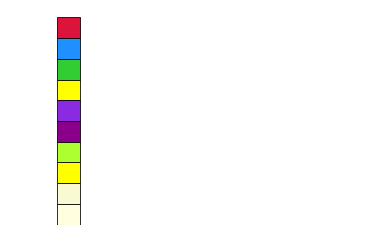

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem24.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


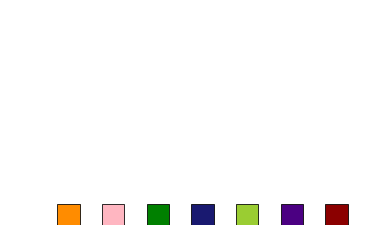

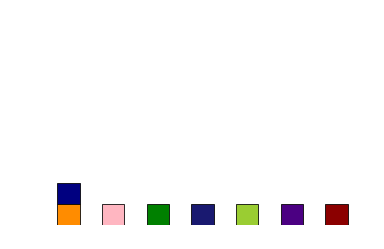

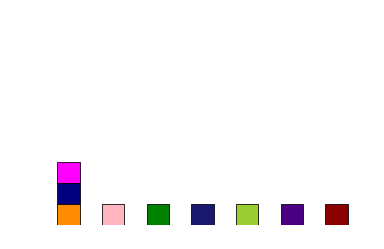

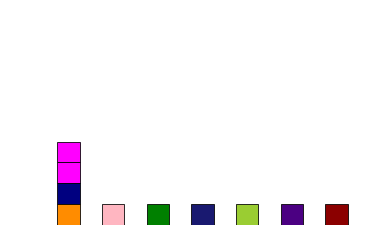

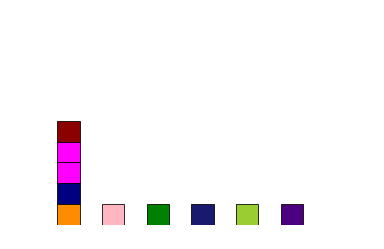

T: no, put red blocks on blue blocks
0.9997798610887503 0.00022013891124981344
[0.54509807 0.         0.        ] 0.3807128073081474
[1. 0. 1.] 0.6192871926918526


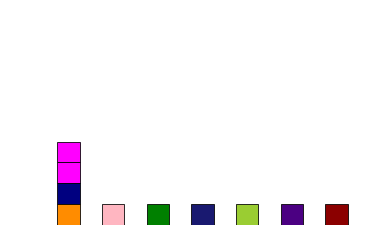

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


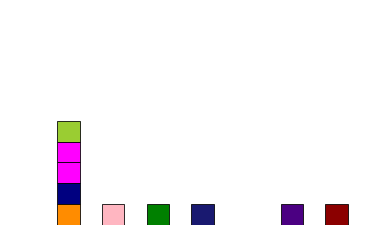

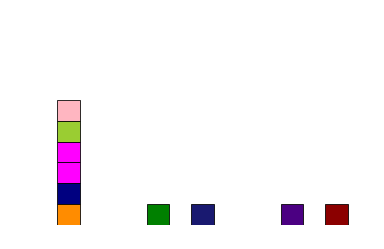

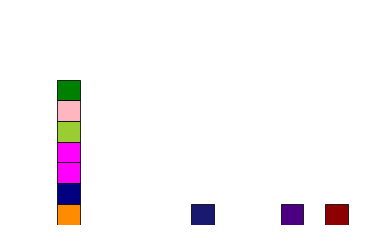

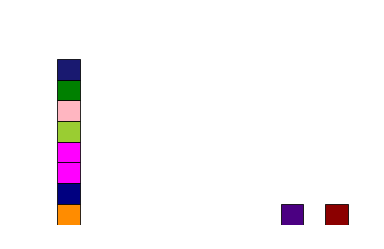

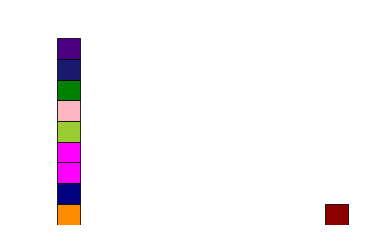

T: No, now you cannot put b5 in the tower because you must put red blocks on blue blocks
0.8320130923735964 0.1679869076264036
[0.54509807 0.         0.        ] 0.0005217539687334354
[1. 0. 1.] 0.9994782460312664
[0.29411766 0.         0.50980395] 0.9999999803351998
[0.09803922 0.09803922 0.4392157 ] 1.9664800291802735e-08
[0.54509807 0.         0.        ] 0.9999999901675999


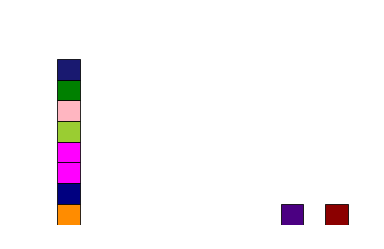

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


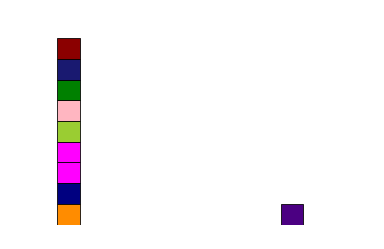

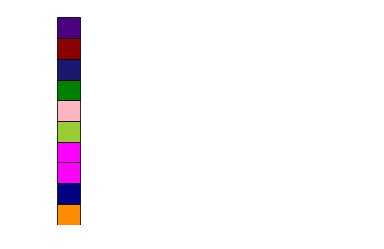

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem7.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


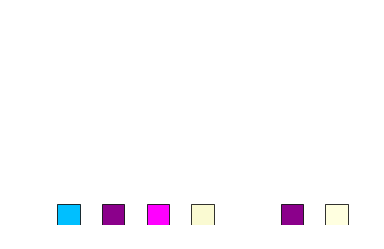

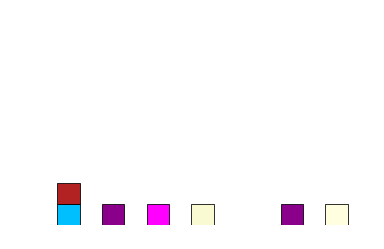

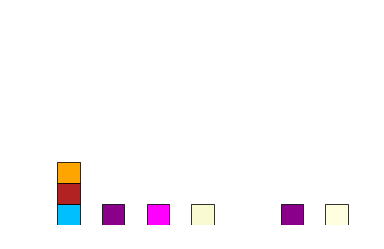

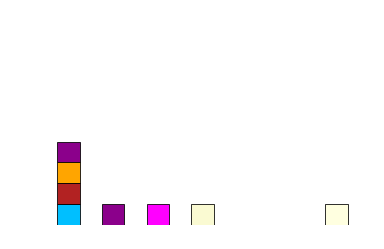

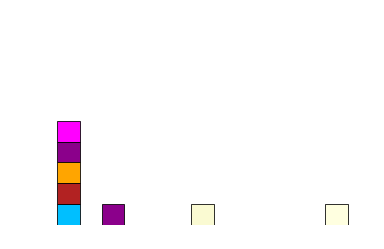

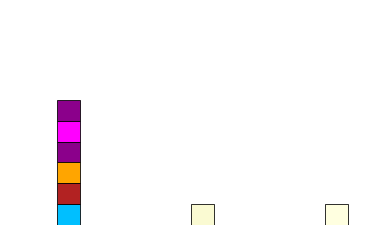

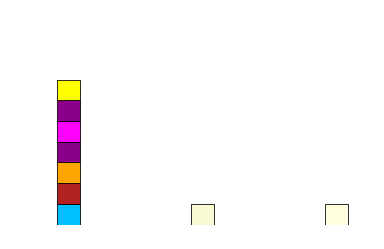

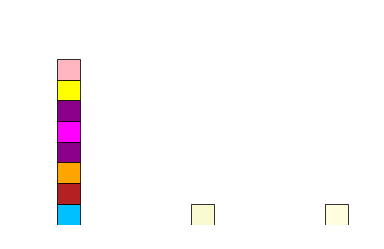

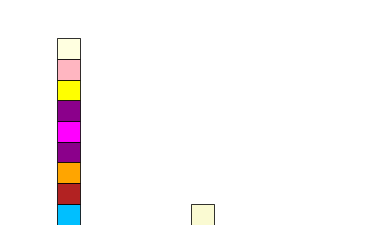

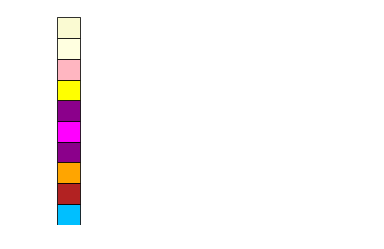

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem8.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


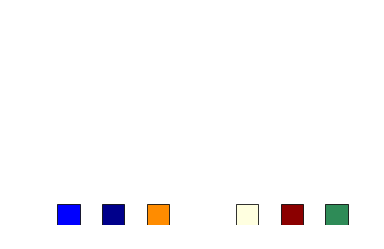

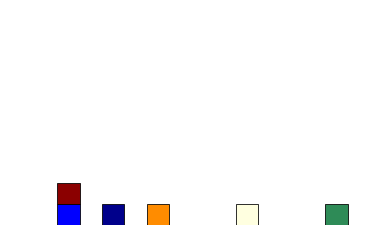

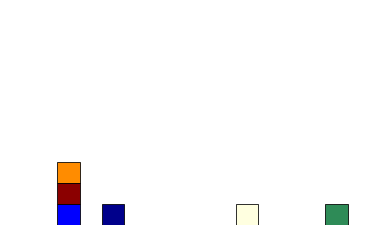

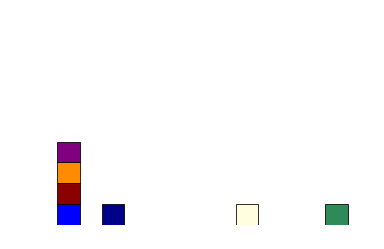

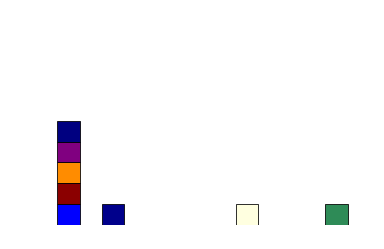

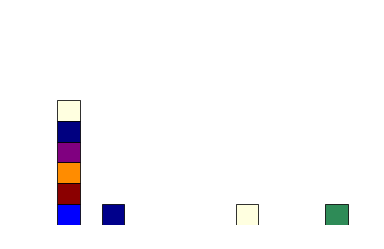

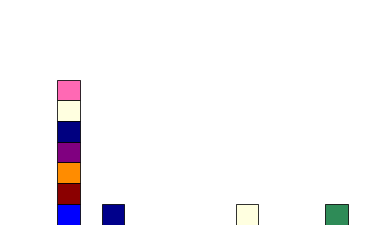

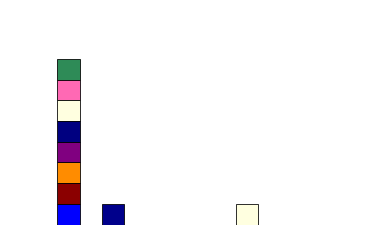

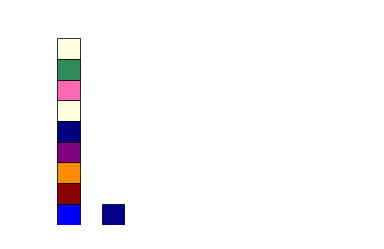

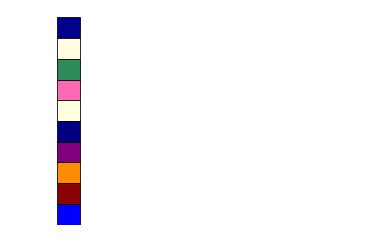

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem30.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


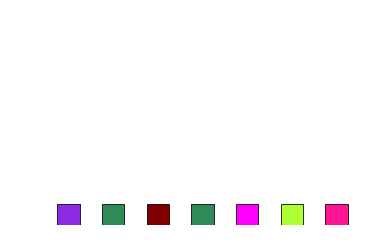

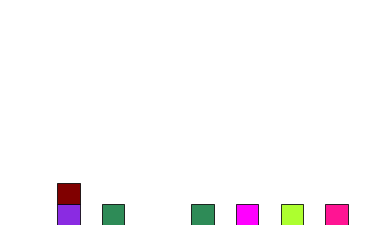

T: no, put red blocks on blue blocks
0.9969959438081509 0.003004056191849062
[0.5019608 0.        0.       ] 0.05998718875257829
[0.5411765  0.16862746 0.8862745 ] 0.9400128112474218


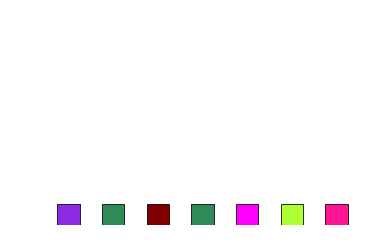

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


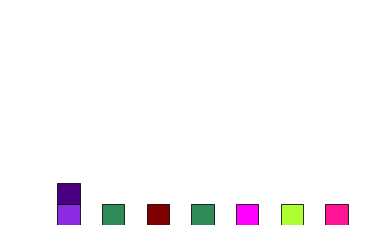

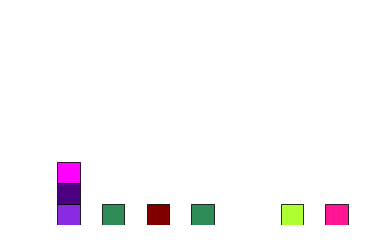

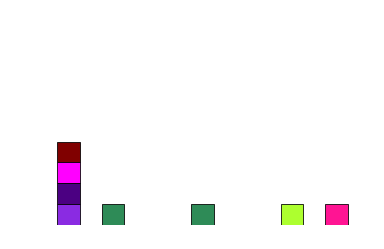

T: no, put red blocks on blue blocks
0.9967592422438508 0.00324075775614918
[0.5019608 0.        0.       ] 2.8128947743714992e-05
[0.5411765  0.16862746 0.8862745 ] 0.9999718710522563
[1. 0. 1.] 0.9999718710522563


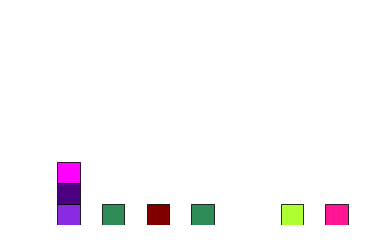

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


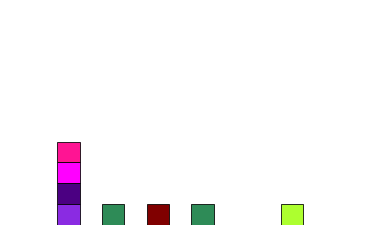

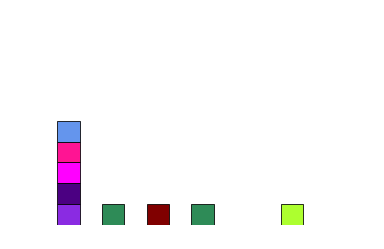

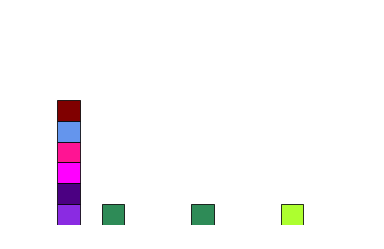

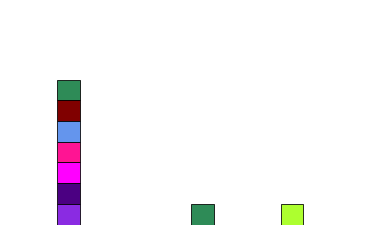

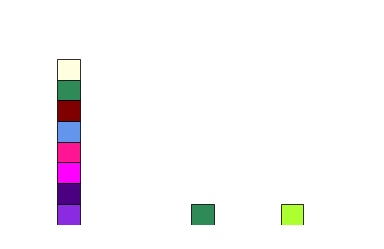

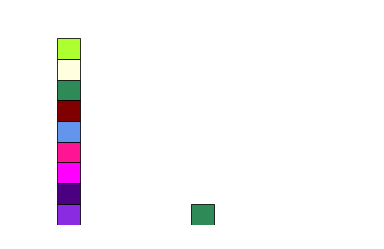

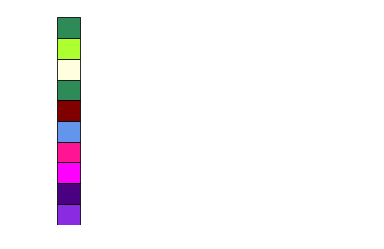

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem42.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


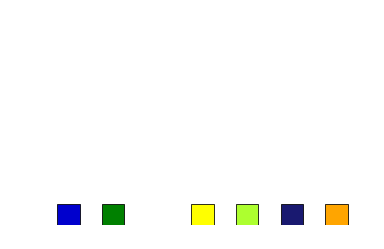

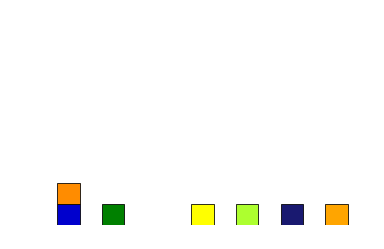

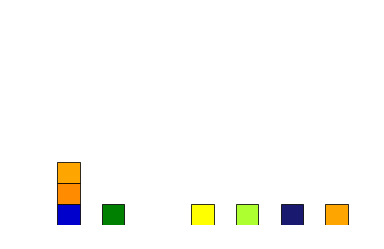

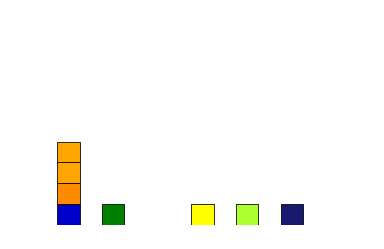

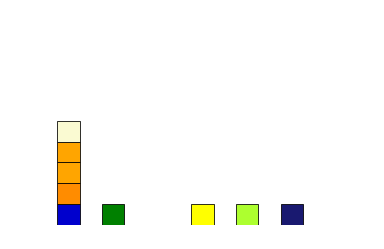

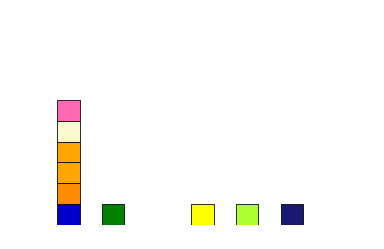

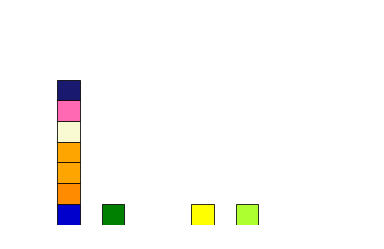

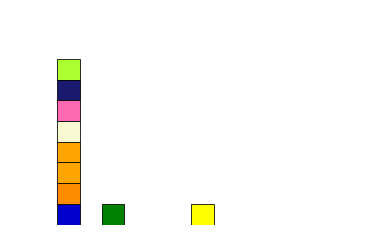

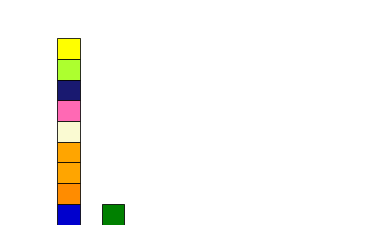

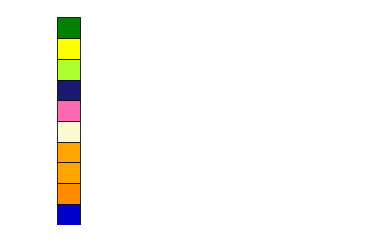

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem43.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


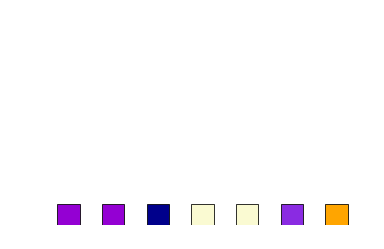

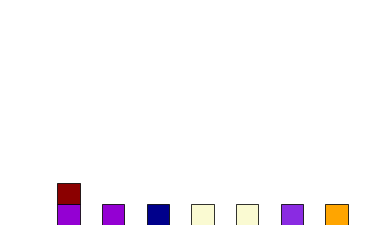

T: no, put red blocks on blue blocks
0.041591381334233124 0.9584086186657669
[0.54509807 0.         0.        ] 0.14150901499369165
[0.5803922 0.        0.827451 ] 0.8584909850063084


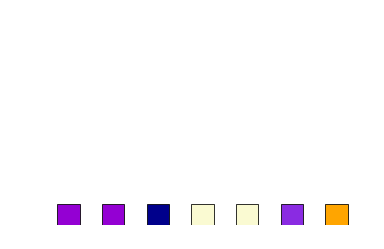

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


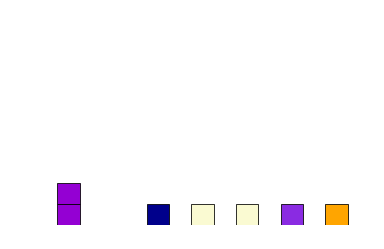

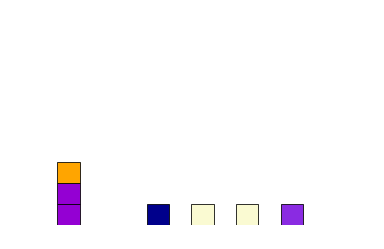

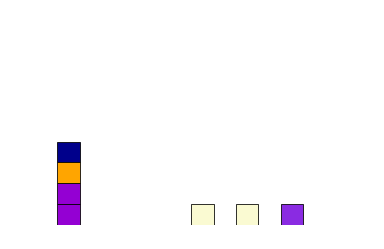

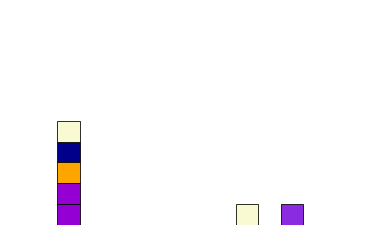

T: No, now you cannot put b6 in the tower because you must put red blocks on blue blocks
0.9893583154021209 0.010641684597879137
[0.54509807 0.         0.        ] 0.5387788028241328
[0.5803922 0.        0.827451 ] 0.4612211971758673
[0.98039216 0.98039216 0.8235294 ] 0.6918317957638009
[0.         0.         0.54509807] 0.3081682042361991
[0.54509807 0.         0.        ] 0.6919181138328134


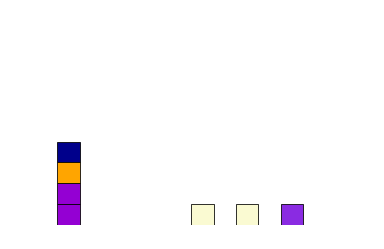

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


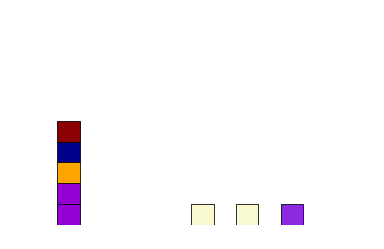

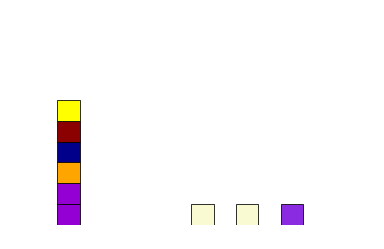

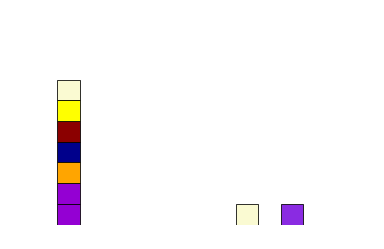

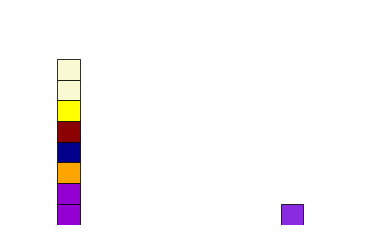

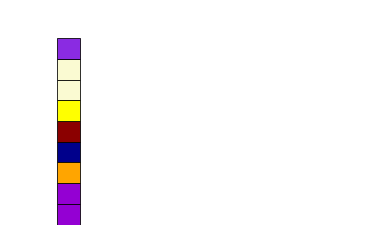

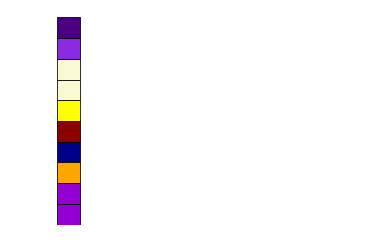

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem28.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


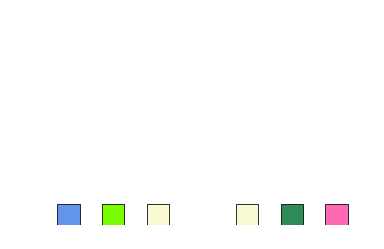

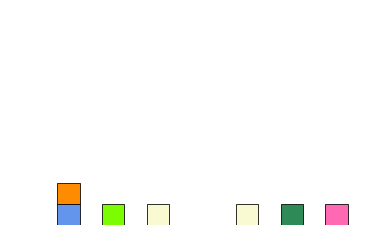

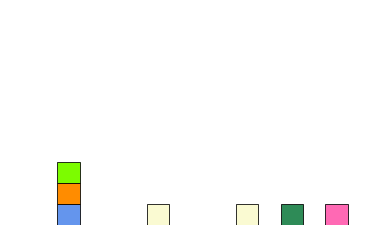

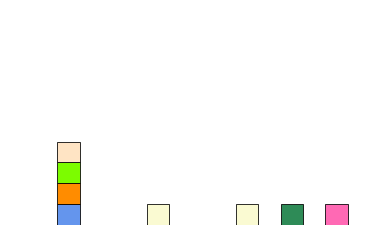

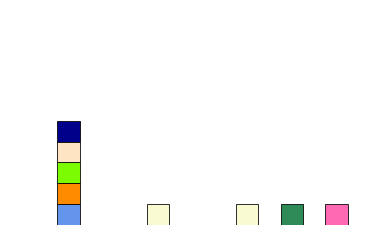

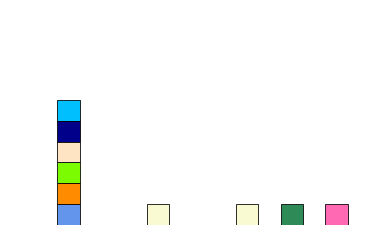

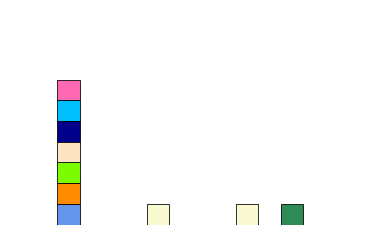

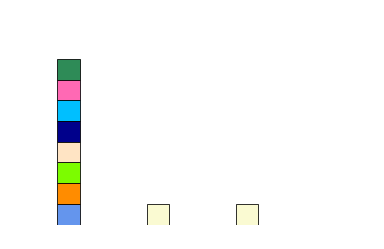

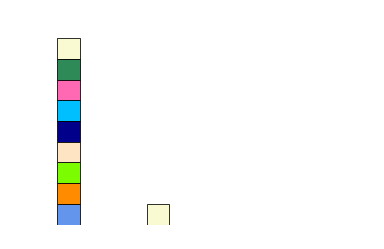

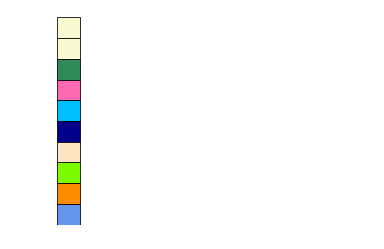

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem29.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


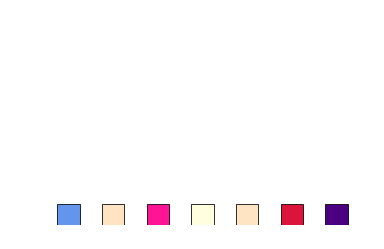

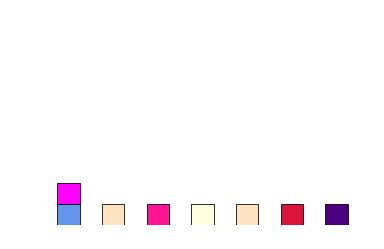

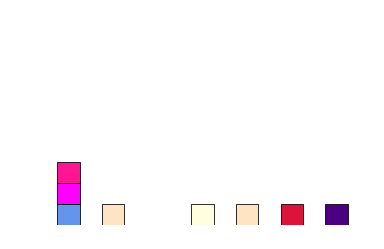

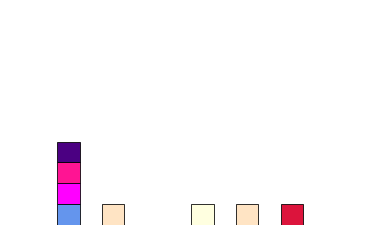

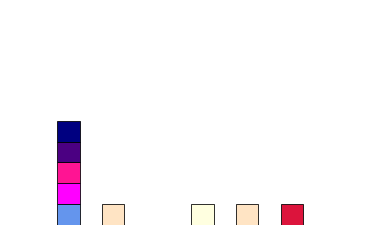

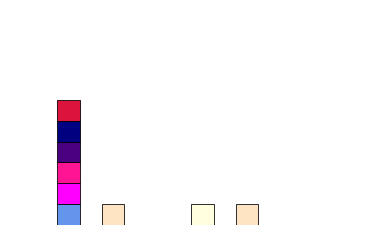

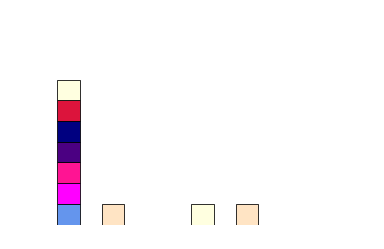

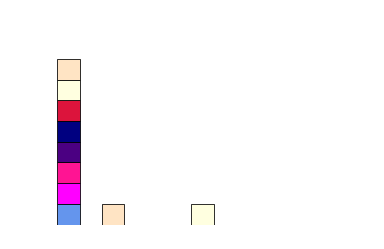

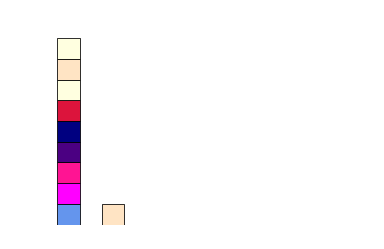

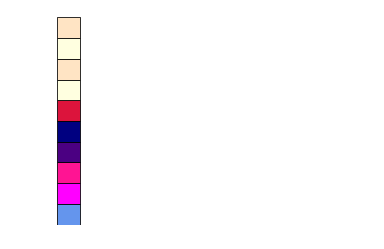

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem17.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


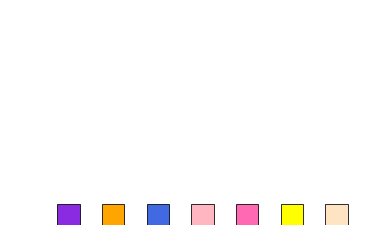

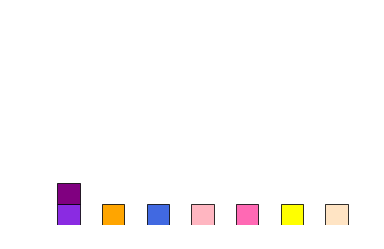

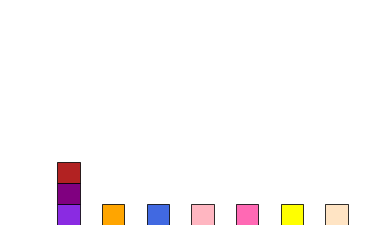

T: no, put red blocks on blue blocks
0.8606569771014095 0.1393430228985905
[0.69803923 0.13333334 0.13333334] 0.2803161536668715
[0.5019608 0.        0.5019608] 0.7196838463331284


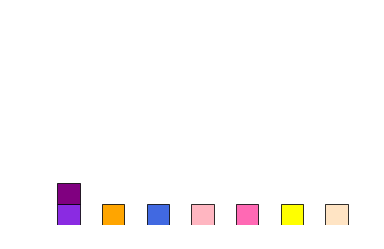

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


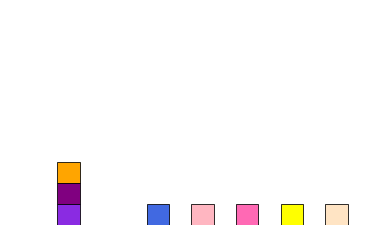

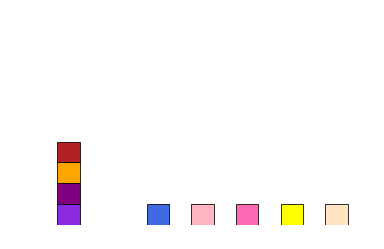

T: no, put red blocks on blue blocks
0.9824204135550408 0.017579586444959227
[0.69803923 0.13333334 0.13333334] 0.711462781014134
[0.5019608 0.        0.5019608] 0.28853721898586615
[1.         0.64705884 0.        ] 0.28853721898586615


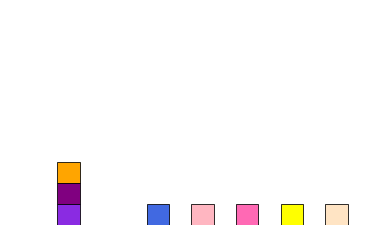

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


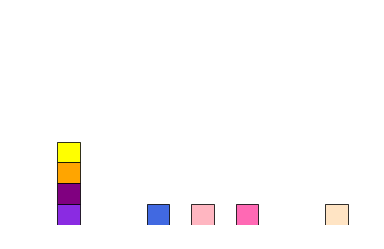

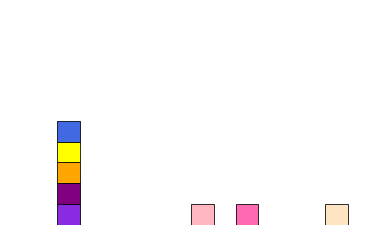

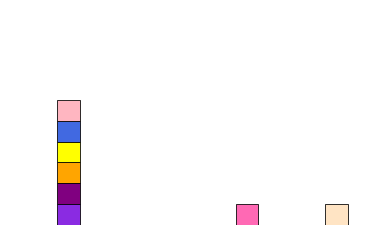

T: No, now you cannot put b7 in the tower because you must put red blocks on blue blocks
0.7064679564077876 0.29353204359221247
[0.69803923 0.13333334 0.13333334] 0.09361397918423096
[0.5019608 0.        0.5019608] 0.906386020815769
[1.         0.64705884 0.        ] 0.906386020815769
[1.         0.7137255  0.75686276] 0.9251088166526152
[0.25490198 0.4117647  0.88235295] 0.07489118334738477
[0.69803923 0.13333334 0.13333334] 0.9625544083263077


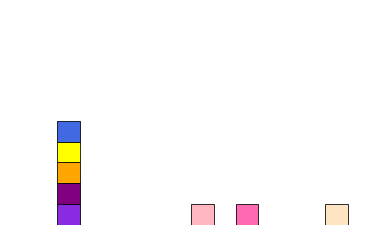

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


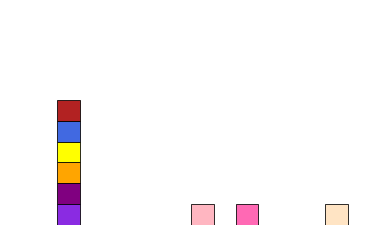

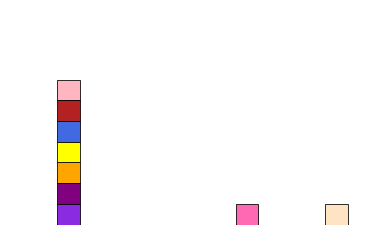

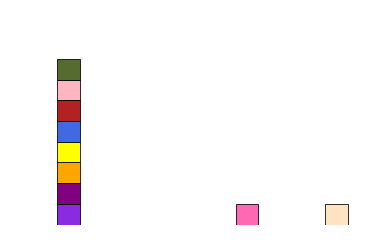

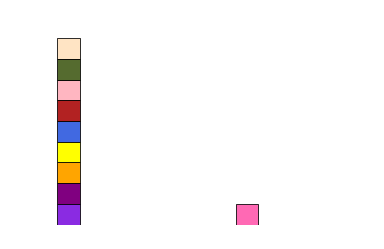

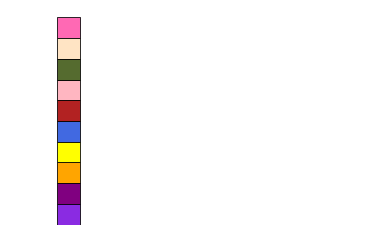

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem10.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Deskto

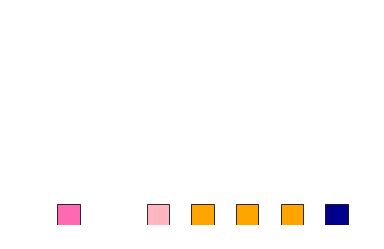

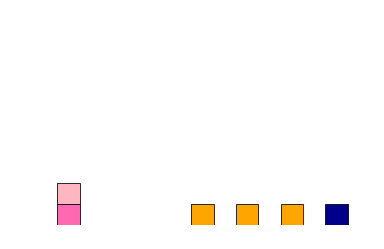

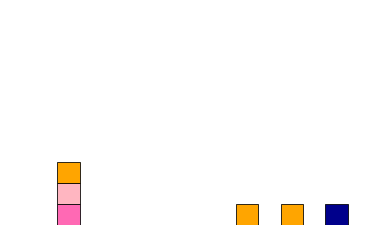

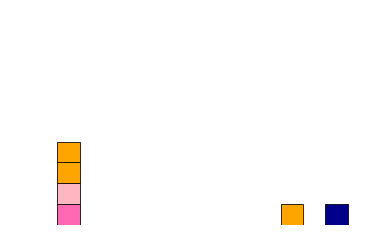

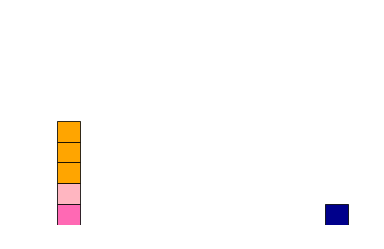

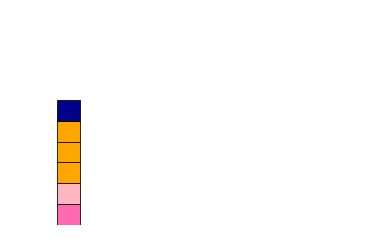

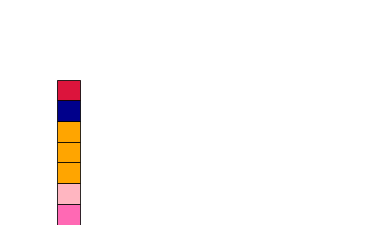

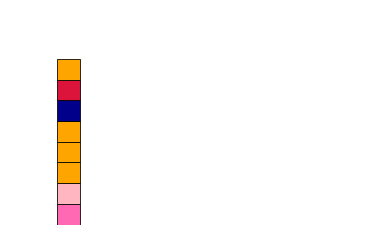

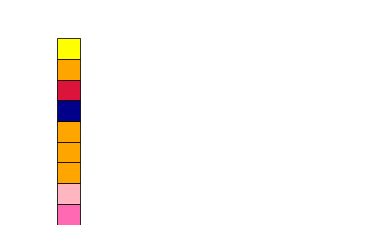

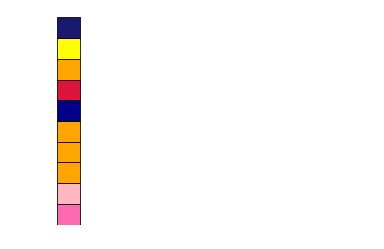

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem25.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


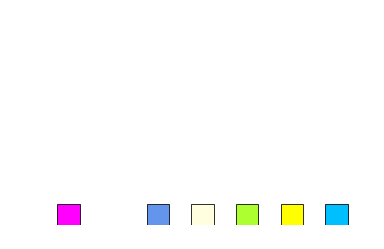

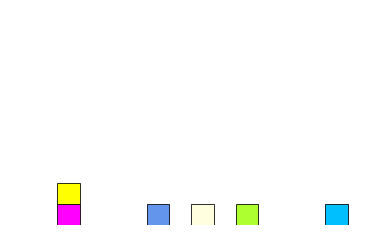

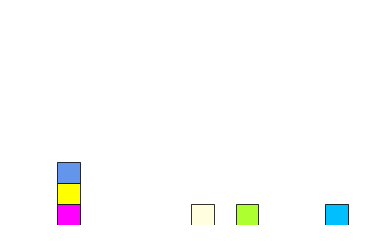

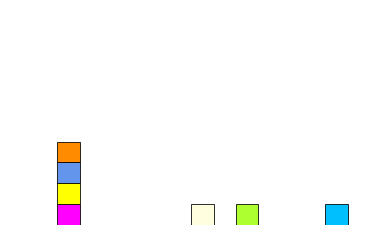

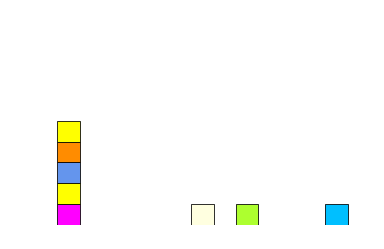

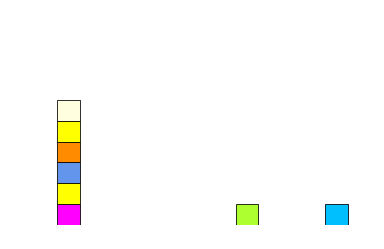

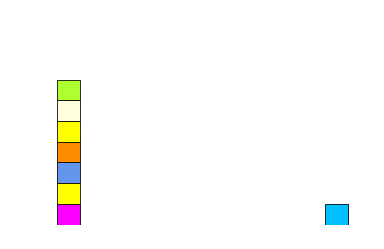

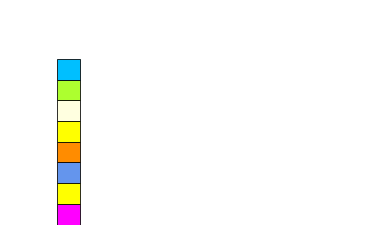

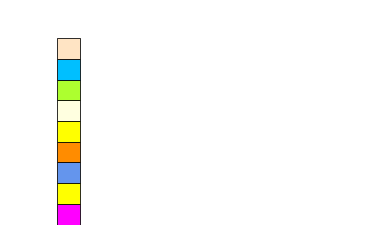

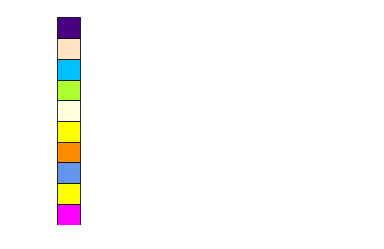

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem39.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Deskto

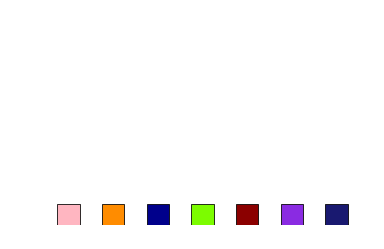

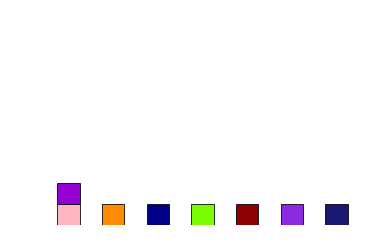

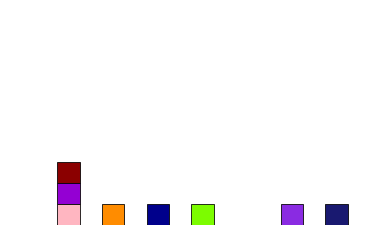

T: no, put red blocks on blue blocks
0.0019634771277842445 0.9980365228722158
[0.54509807 0.         0.        ] 0.17166745168475528
[0.5803922 0.        0.827451 ] 0.8283325483152448


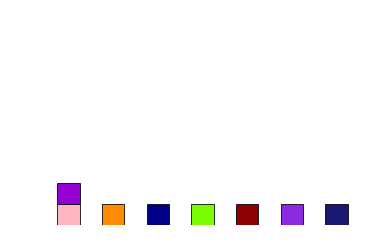

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


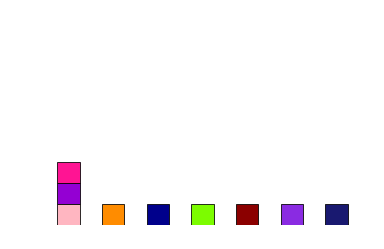

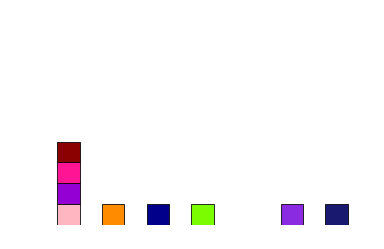

T: no, put red blocks on blue blocks
0.9996274551816723 0.00037254481832770447
[0.54509807 0.         0.        ] 0.005577828772755752
[0.5803922 0.        0.827451 ] 0.9944221712272442
[1.         0.07843138 0.5764706 ] 0.9944221712272442


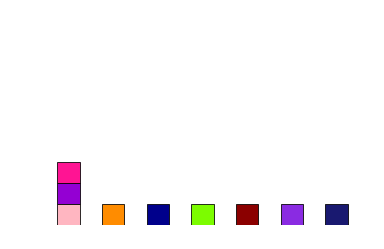

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


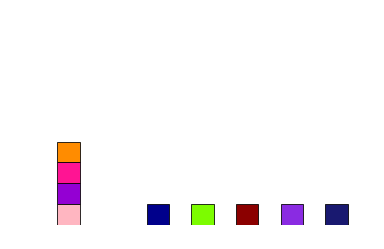

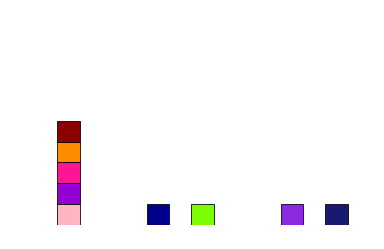

T: no, put red blocks on blue blocks
0.009365883645077682 0.9906341163549223
[0.54509807 0.         0.        ] 6.256985652187768e-05
[0.5803922 0.        0.827451 ] 0.999937430143478
[1.         0.07843138 0.5764706 ] 0.999937430143478
[1.         0.54901963 0.        ] 0.999937430143478


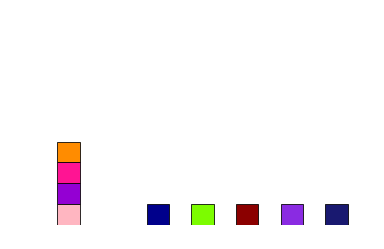

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


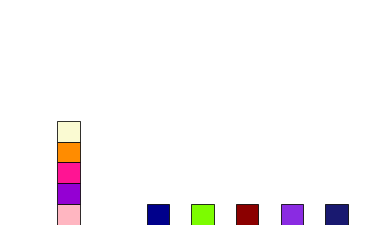

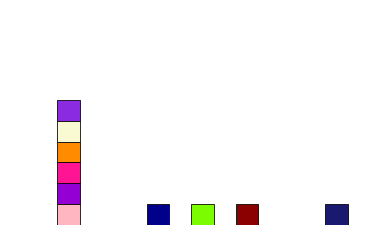

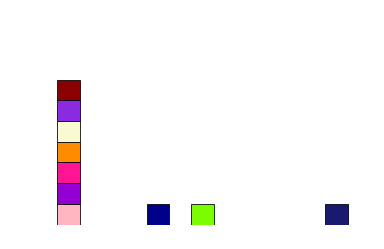

T: no, put red blocks on blue blocks
0.9997873571227363 0.00021264287726369447
[0.54509807 0.         0.        ] 0.34996070545325725
[0.5803922 0.        0.827451 ] 0.6500392945467427
[1.         0.07843138 0.5764706 ] 0.6500392945467427
[1.         0.54901963 0.        ] 0.6500392945467427
[0.5411765  0.16862746 0.8862745 ] 0.6500392945467427


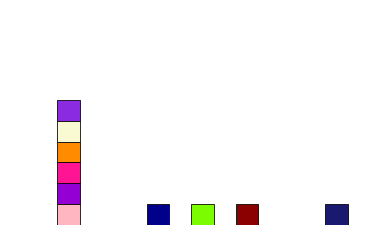

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


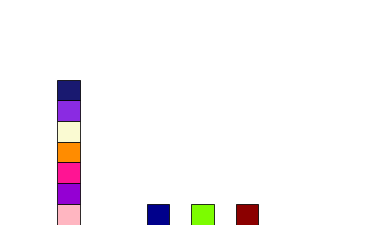

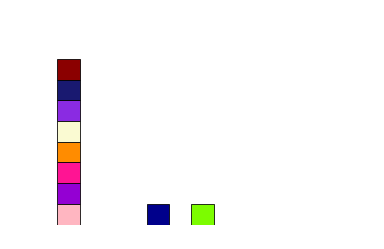

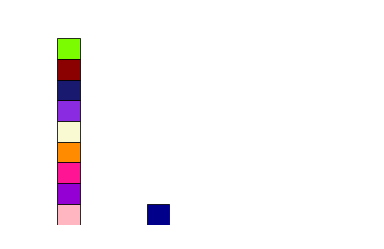

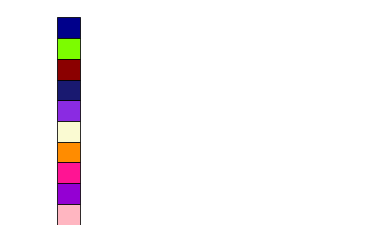

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem19.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


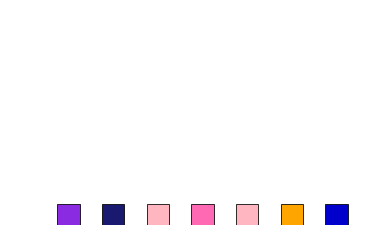

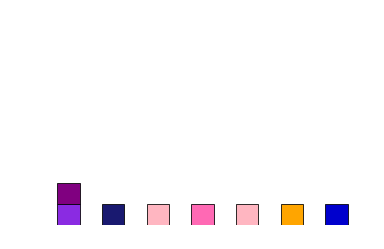

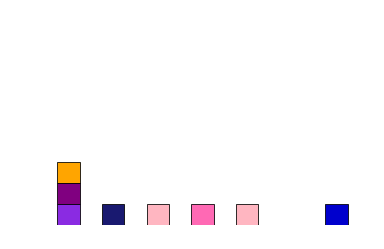

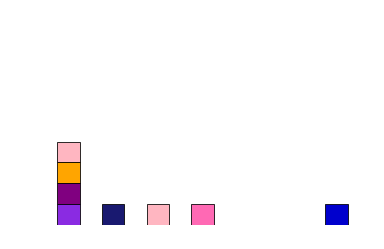

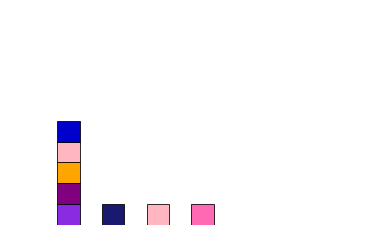

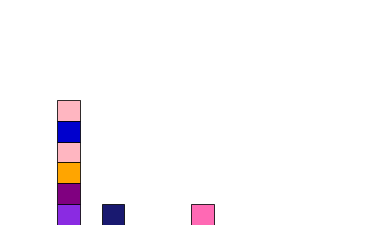

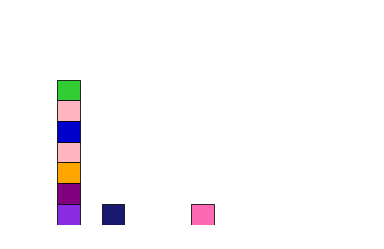

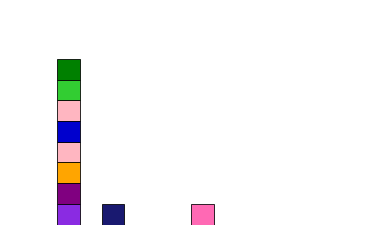

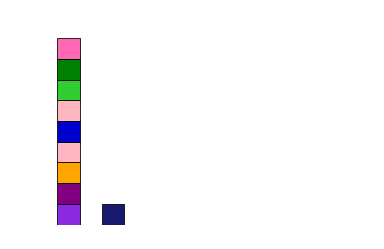

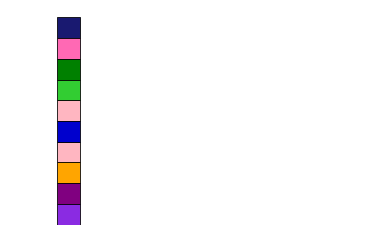

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem6.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


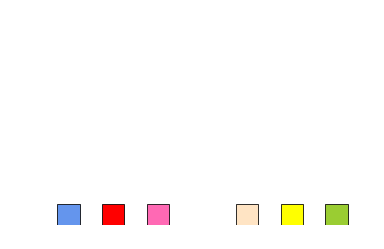

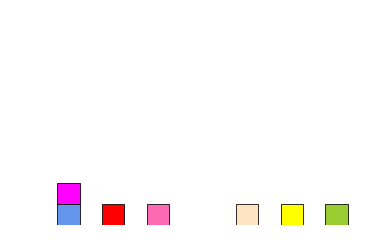

T: No, now you cannot put b0 in the tower because you must put red blocks on blue blocks
0.9999520926475721 4.7907352427879103e-05
[1. 0. 1.] 0.9890450937960619
[0.39215687 0.58431375 0.92941177] 0.010954906203938172
[1. 0. 0.] 0.5054774531019691
[1. 0. 0.] 0.999976307599022


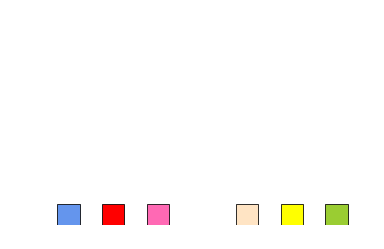

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


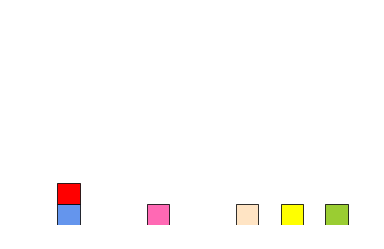

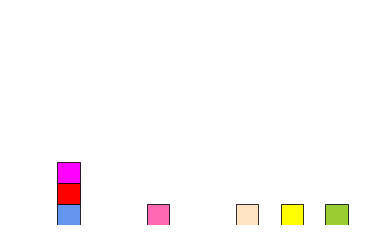

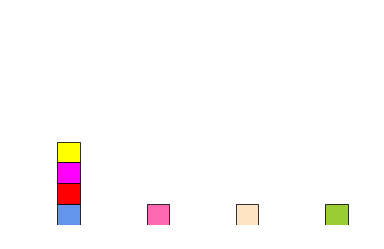

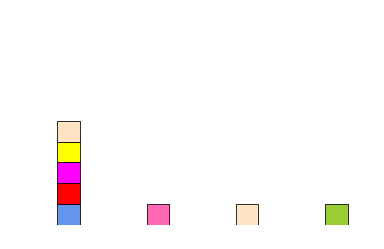

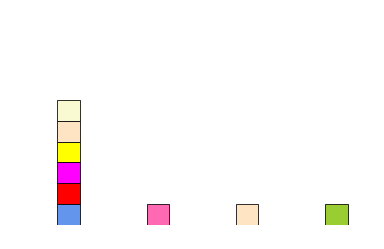

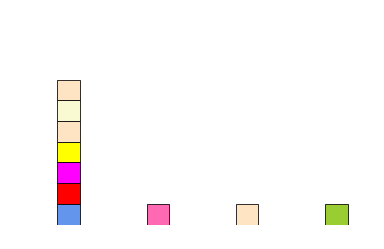

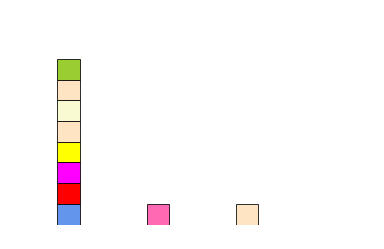

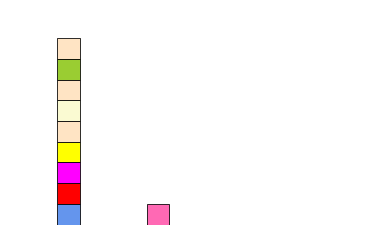

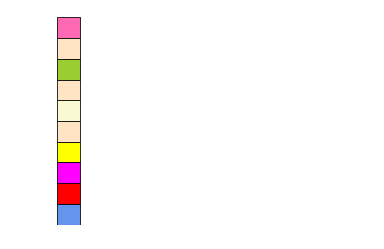

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem12.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


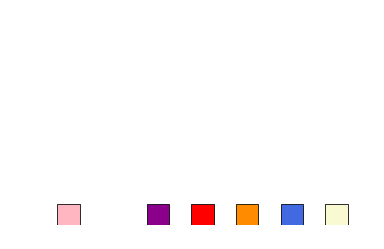

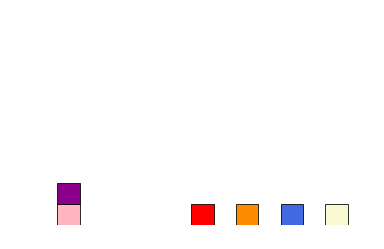

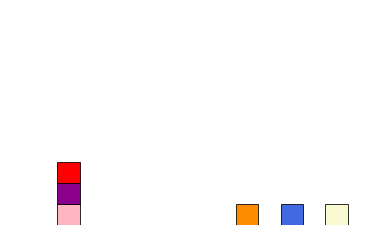

T: no, put red blocks on blue blocks
0.333721377475376 0.666278622524624
[1. 0. 0.] 1
[0.54509807 0.         0.54509807] 0.0


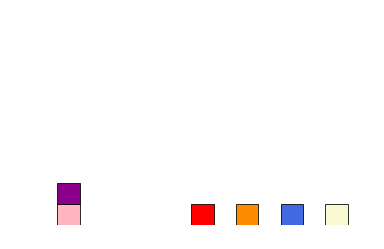

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


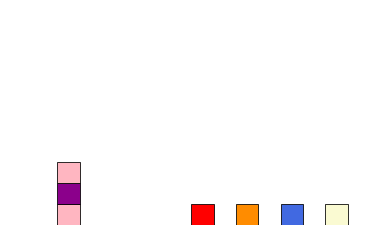

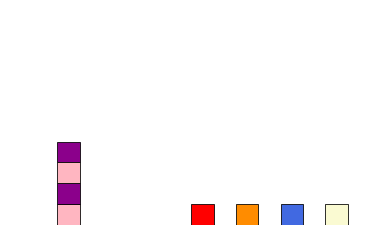

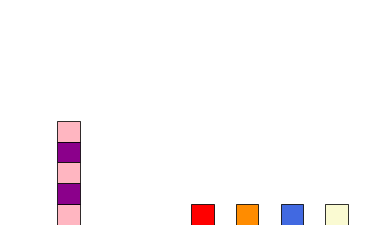

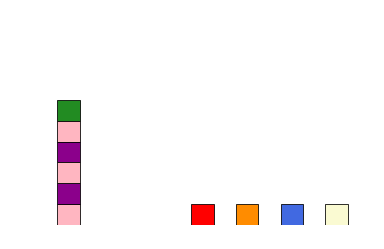

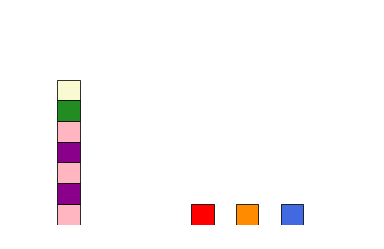

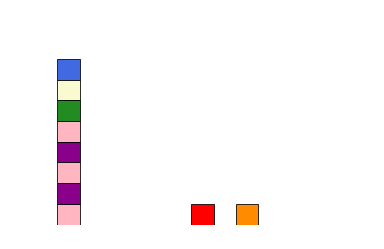

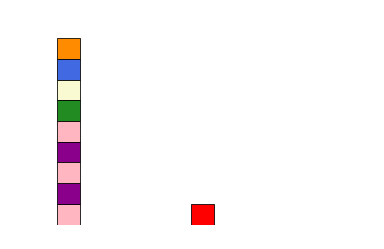

T: No, now you cannot put b2 in the tower because you must put red blocks on blue blocks
0.9968569073987923 0.0031430926012076693
[1. 0. 0.] 1
[0.54509807 0.         0.54509807] 0.0
[1.         0.54901963 0.        ] 1.1098012217375765e-05
[0.25490198 0.4117647  0.88235295] 0.9999889019877826
[1. 0. 0.] 0.5000055490061087


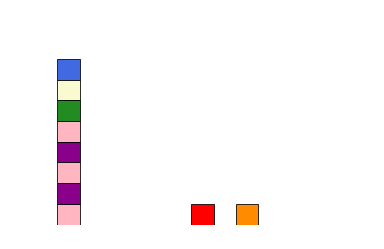

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


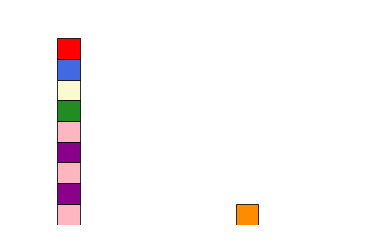

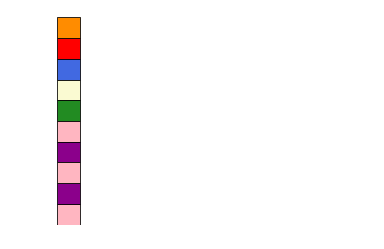

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem22.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


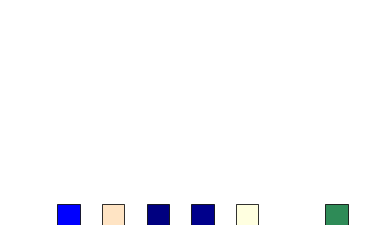

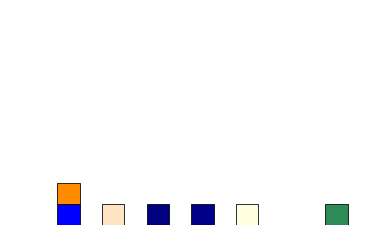

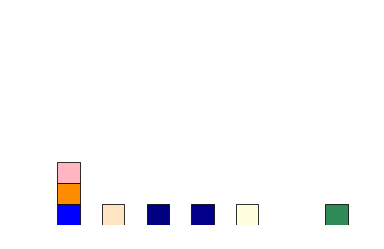

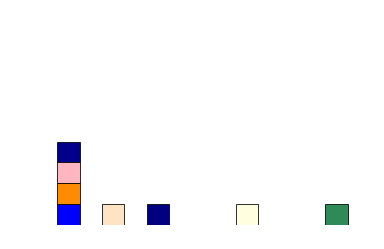

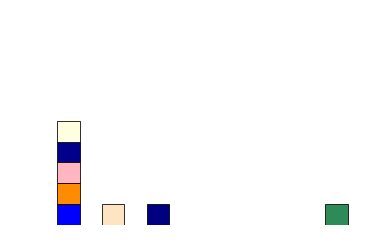

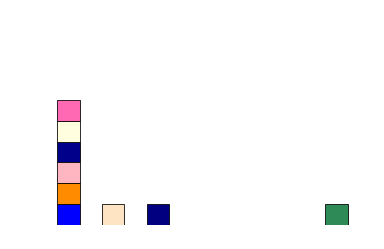

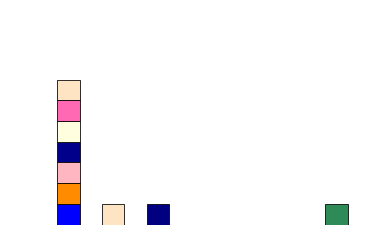

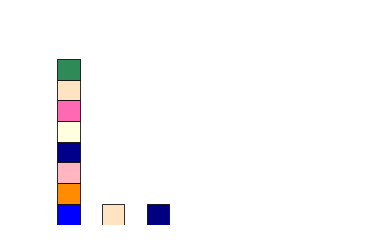

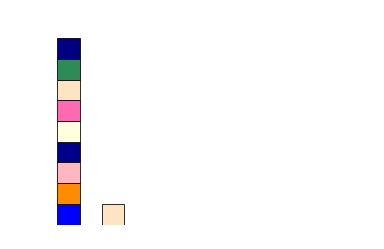

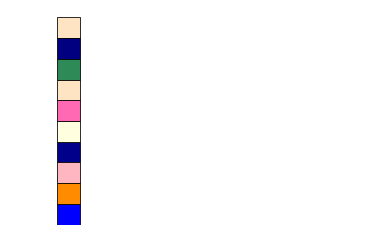

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem9.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


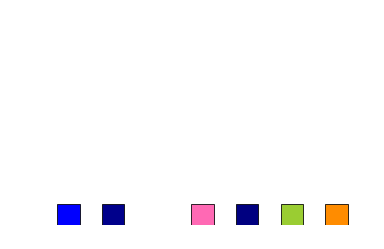

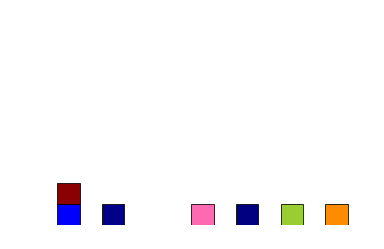

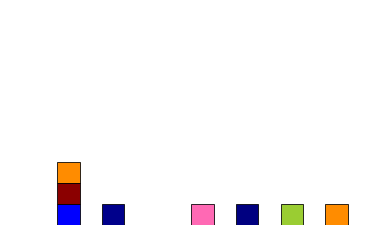

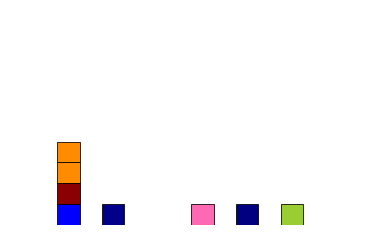

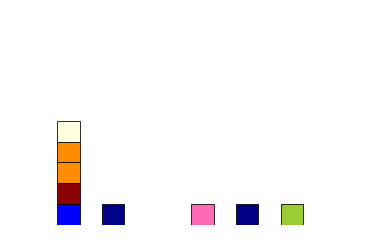

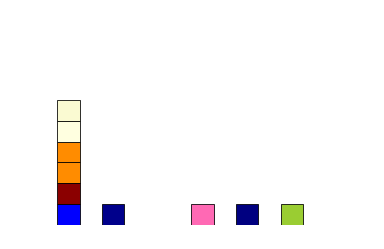

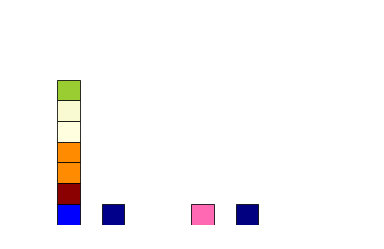

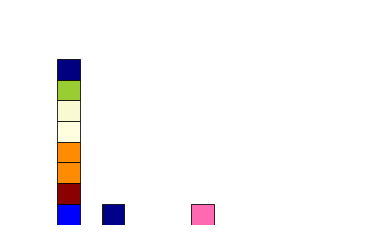

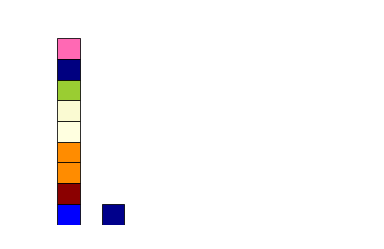

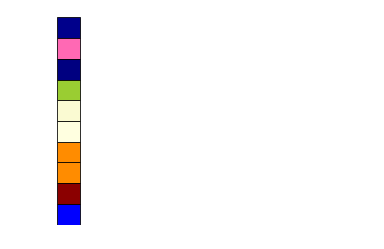

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem15.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Deskto

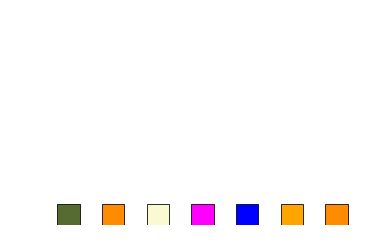

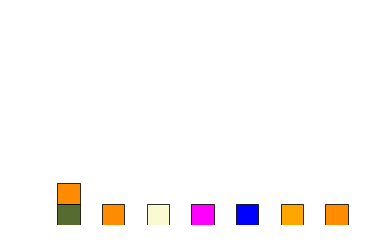

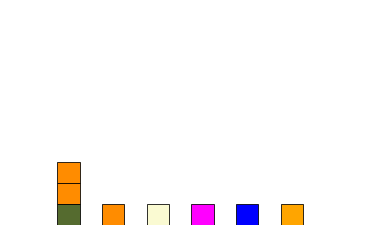

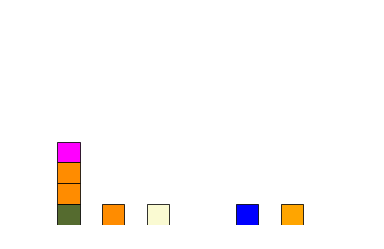

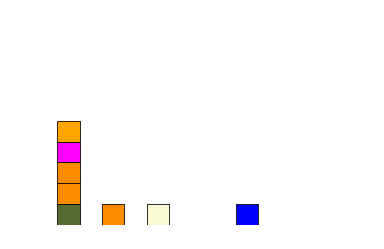

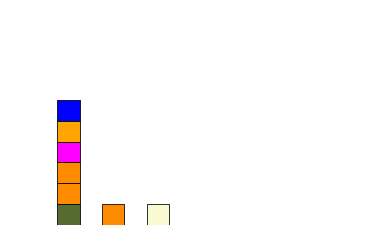

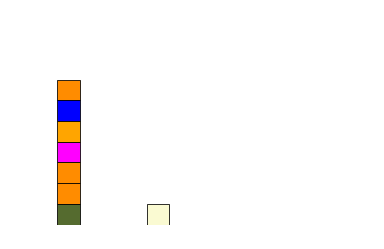

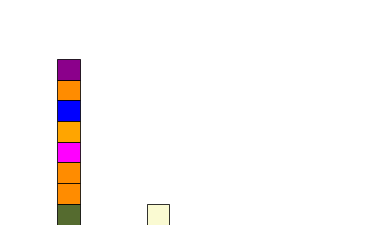

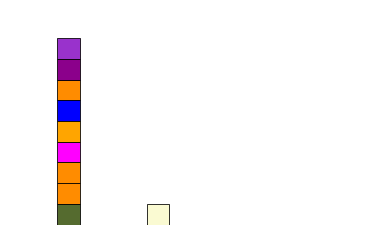

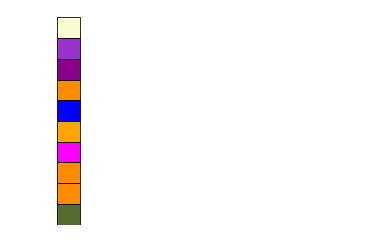

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem14.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


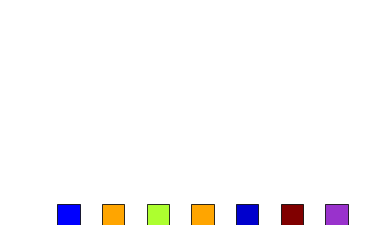

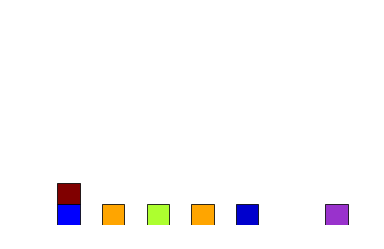

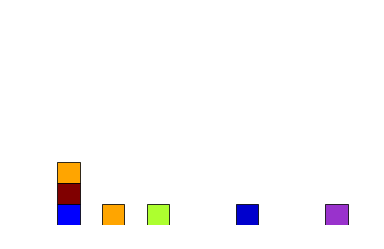

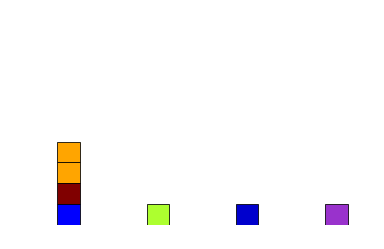

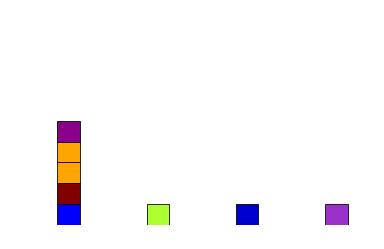

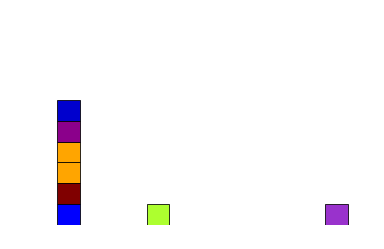

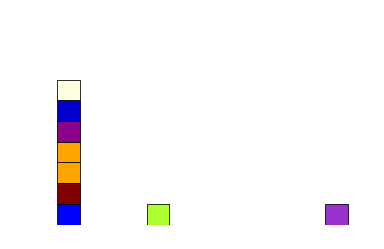

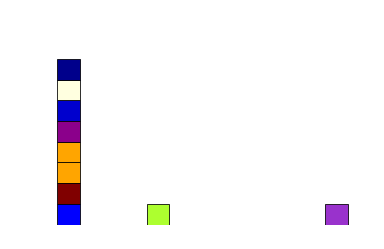

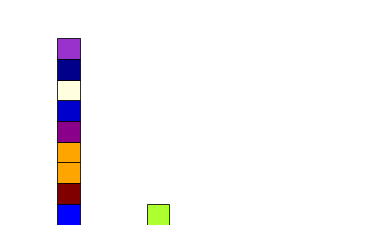

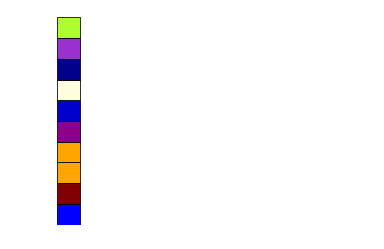

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem38.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


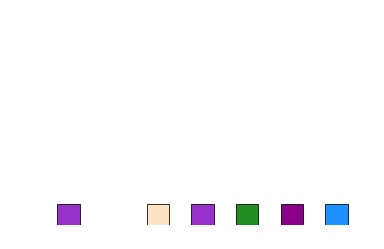

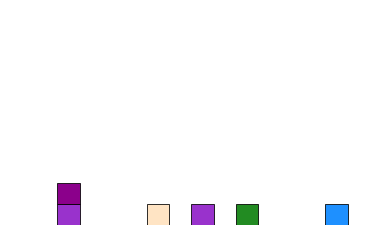

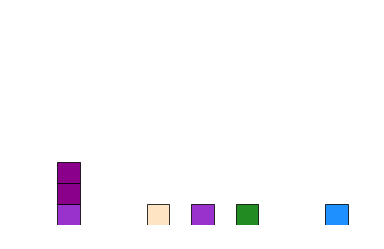

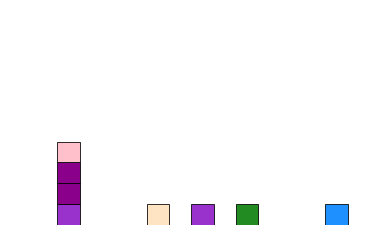

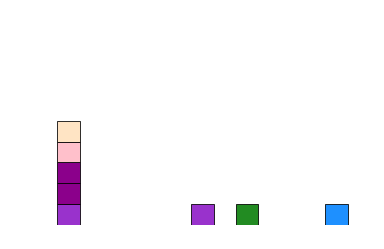

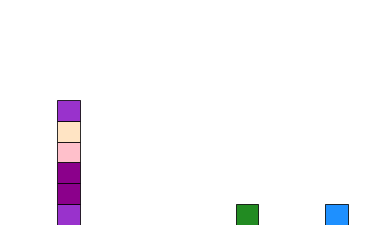

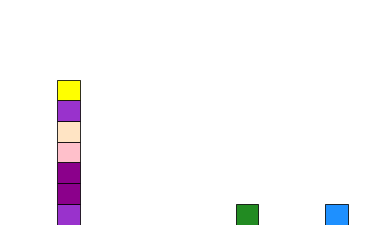

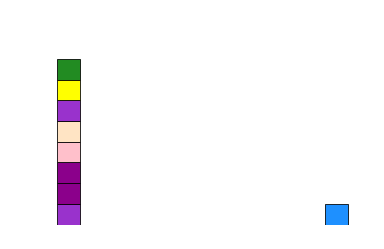

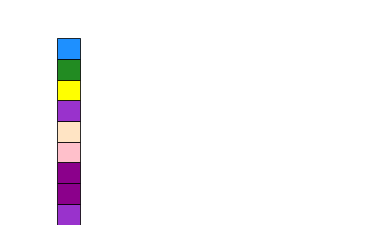

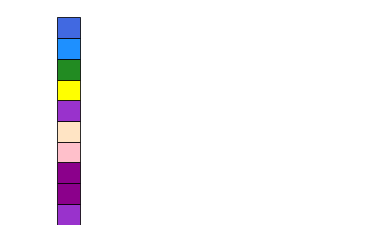

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem11.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Deskto

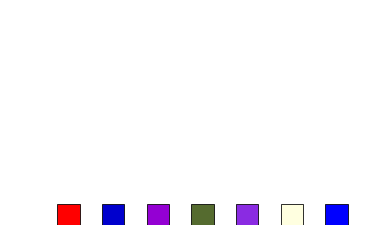

T: no, put red blocks on blue blocks
1.0 0.0
[1. 0. 0.] 1.0


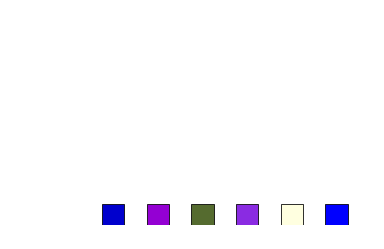

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


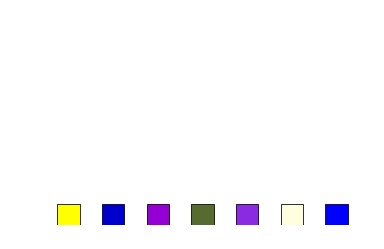

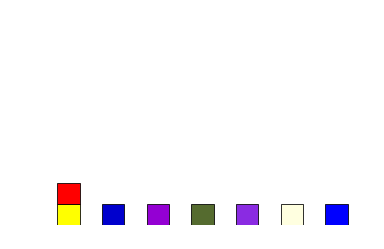

T: no, put red blocks on blue blocks
1.0 0.0
[1. 0. 0.] 1.0
[1. 1. 0.] 0.0


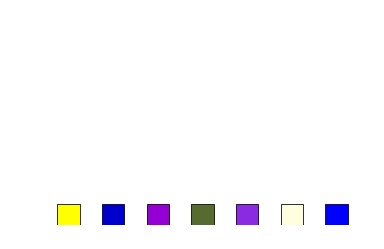

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


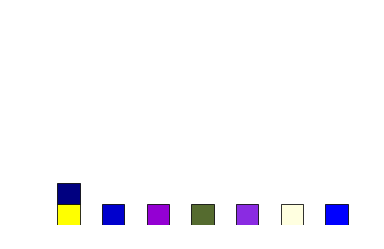

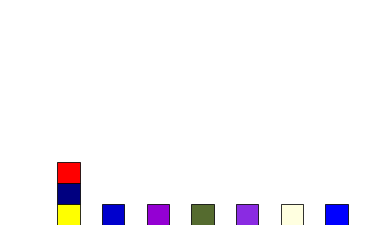

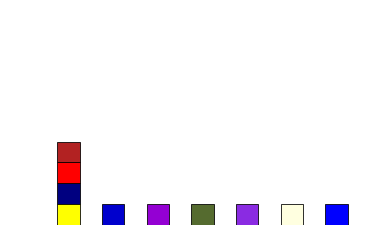

T: no, put red blocks on blue blocks
0.9907847518274495 0.009215248172550533
[1. 0. 0.] 1.0
[1. 1. 0.] 0.0
[0.69803923 0.13333334 0.13333334] 0.9970112633212728
[1. 0. 0.] 0.002988736678727229


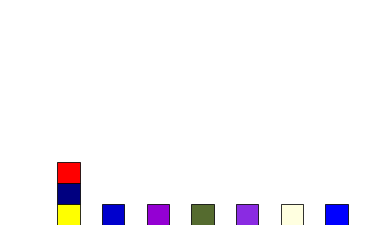

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


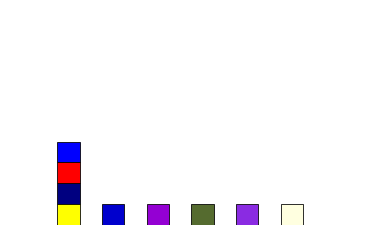

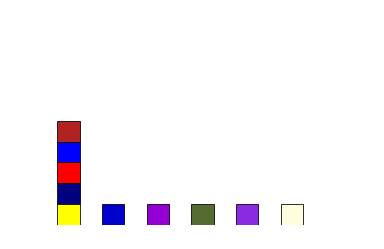

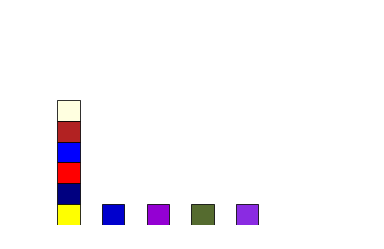

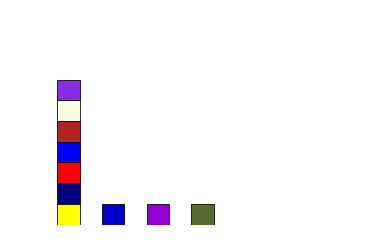

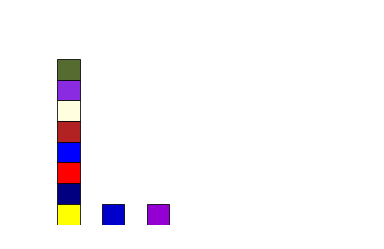

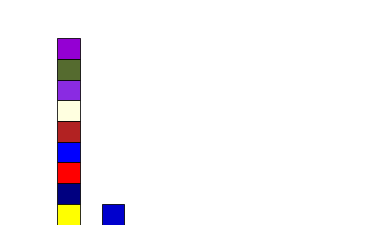

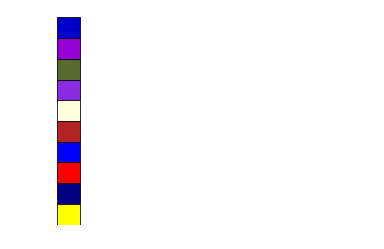

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem49.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


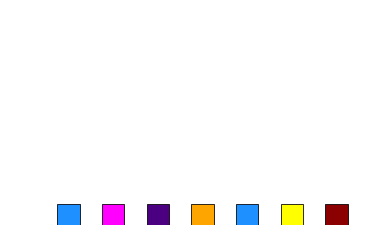

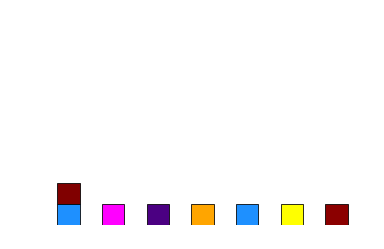

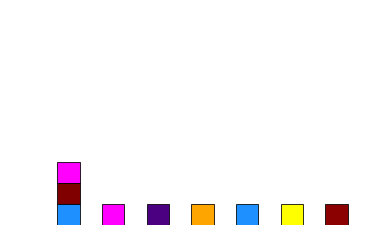

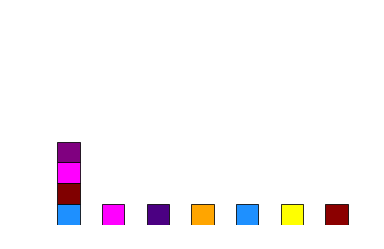

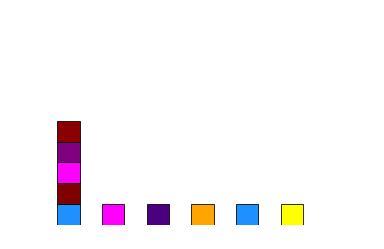

T: no, put red blocks on blue blocks
0.015519431547249296 0.9844805684527507
[0.54509807 0.         0.        ] 0.0679630049633789
[0.5019608 0.        0.5019608] 0.9320369950366211


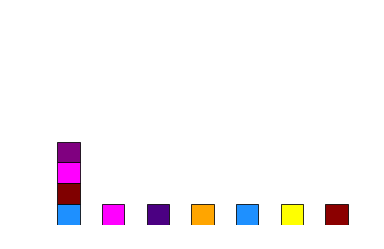

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


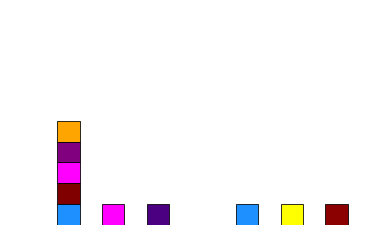

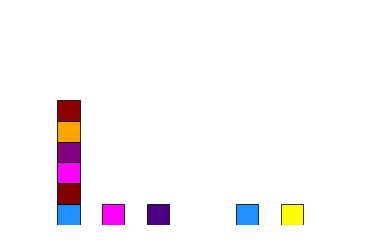

T: no, put red blocks on blue blocks
0.003168145015400456 0.9968318549845995
[0.54509807 0.         0.        ] 0.3435185203042719
[0.5019608 0.        0.5019608] 0.6564814796957281
[1.         0.64705884 0.        ] 0.6564814796957281


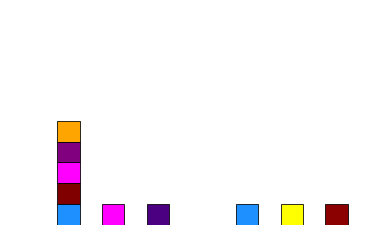

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


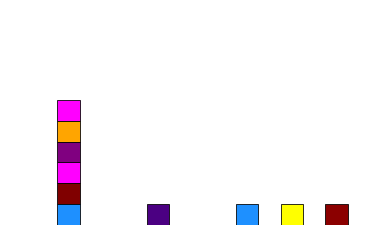

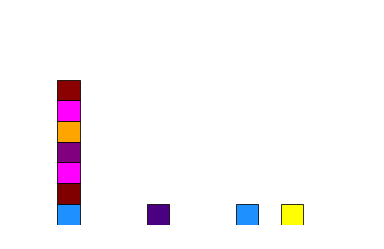

T: no, put red blocks on blue blocks
5.401818638379815e-05 0.9999459818136163
[0.54509807 0.         0.        ] 2.1728905148596733e-05
[0.5019608 0.        0.5019608] 0.9999782710948514
[1.         0.64705884 0.        ] 0.9999782710948514
[1. 0. 1.] 0.9999782710948514


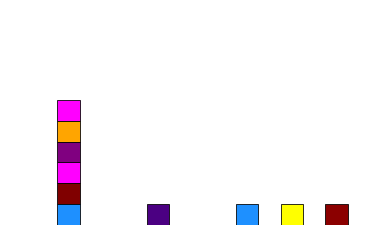

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


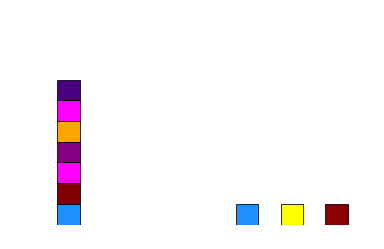

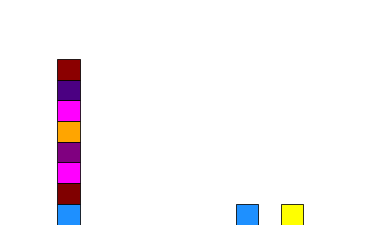

T: no, put red blocks on blue blocks
3.6449584423938445e-05 0.999963550415576
[0.54509807 0.         0.        ] 1.435689306253446e-05
[0.5019608 0.        0.5019608] 0.9999856431069374
[1.         0.64705884 0.        ] 0.9999856431069374
[1. 0. 1.] 0.9999856431069374
[0.29411766 0.         0.50980395] 0.9999856431069374


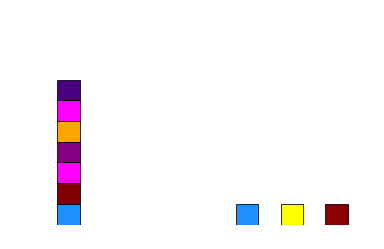

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


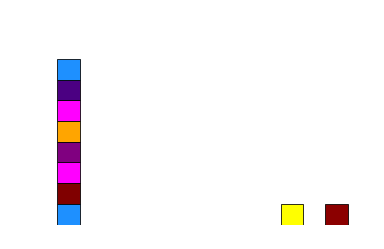

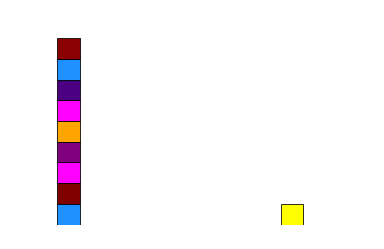

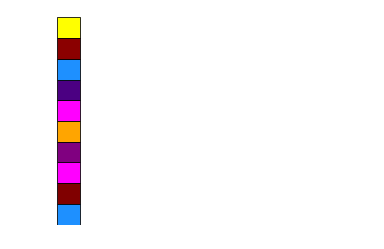

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem16.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


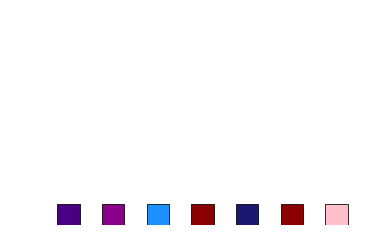

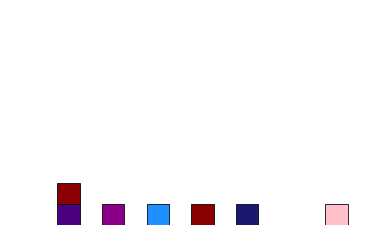

T: no, put red blocks on blue blocks
0.9897768896860574 0.0102231103139427
[0.54509807 0.         0.        ] 0.05188984336652481
[0.29411766 0.         0.50980395] 0.9481101566334751


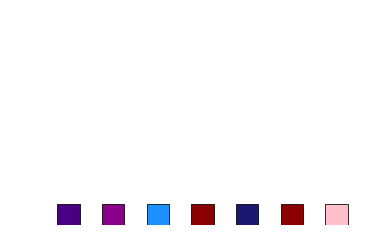

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


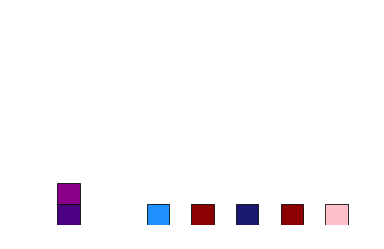

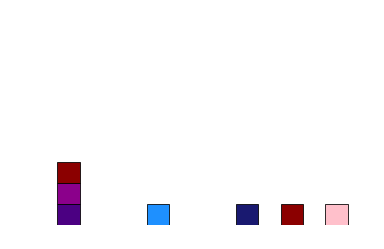

T: no, put red blocks on blue blocks
0.9999311269074441 6.88730925559381e-05
[0.54509807 0.         0.        ] 0.0019353211073712857
[0.29411766 0.         0.50980395] 0.9980646788926286
[0.54509807 0.         0.        ] 0.003359462936780706
[0.54509807 0.         0.54509807] 0.9966405370632193


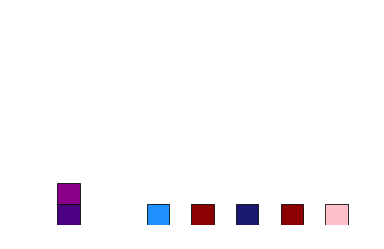

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


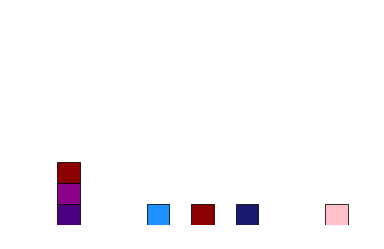

T: no, put red blocks on blue blocks
0.9999557960365111 4.420396348898627e-05
[0.54509807 0.         0.        ] 0.0002861643578846322
[0.29411766 0.         0.50980395] 0.9997138356421154
[0.54509807 0.         0.        ] 0.0002861643578846322
[0.54509807 0.         0.54509807] 0.9997138356421154


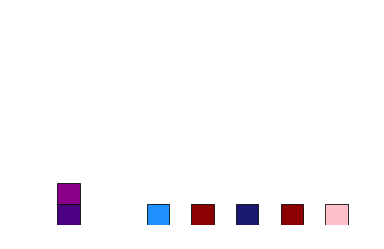

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


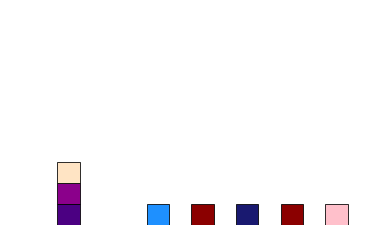

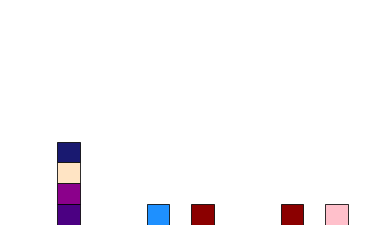

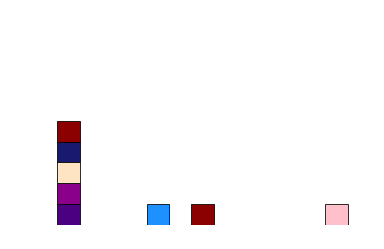

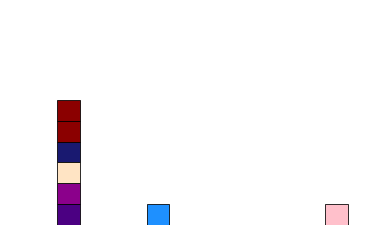

T: no, put red blocks on blue blocks
0.9999979762600825 2.023739917542955e-06
[0.54509807 0.         0.        ] 1.3118285327604563e-05
[0.29411766 0.         0.50980395] 0.9999868817146723
[0.54509807 0.         0.        ] 1.3118285327604563e-05
[0.54509807 0.         0.54509807] 0.9999868817146723
[0.54509807 0.         0.        ] 0.9999868817146723


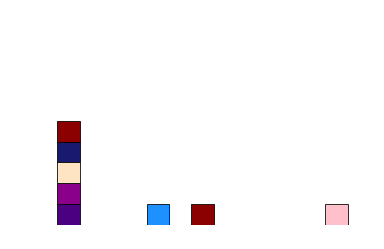

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


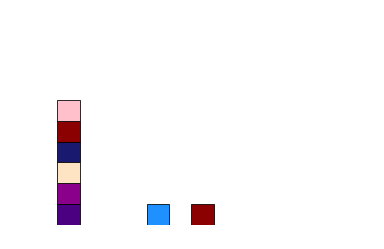

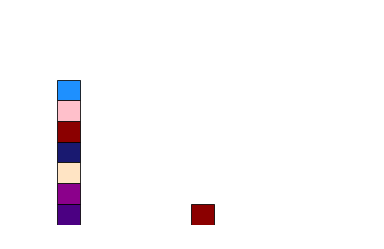

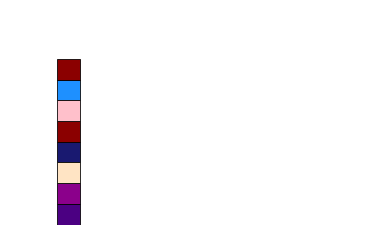

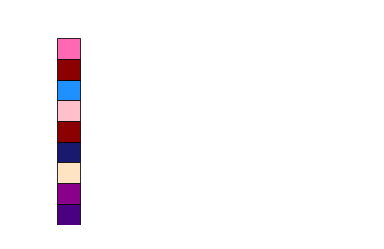

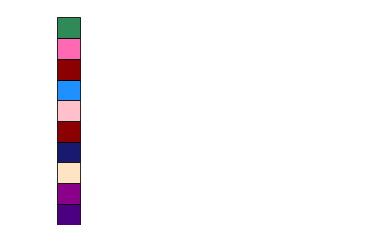

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem35.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Deskto

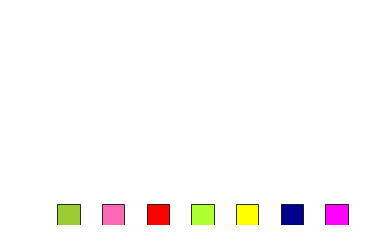

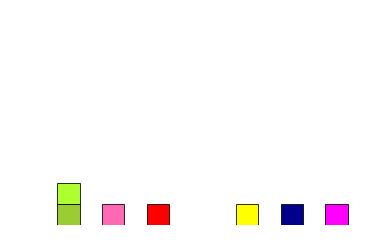

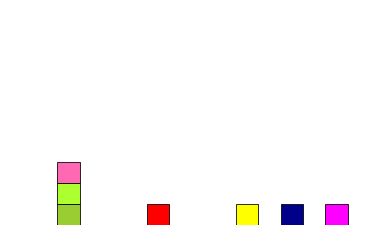

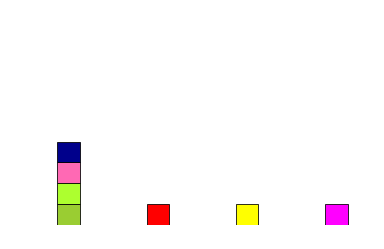

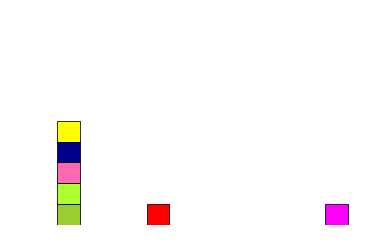

T: No, now you cannot put b1 in the tower because you must put red blocks on blue blocks
0.999992914591491 7.0854085090518505e-06
[1. 1. 0.] 0.49995995639700513
[0.         0.         0.54509807] 0.5000400436029948
[1. 0. 0.] 0.9987120484189259
[1. 0. 0.] 0.9986319612129363


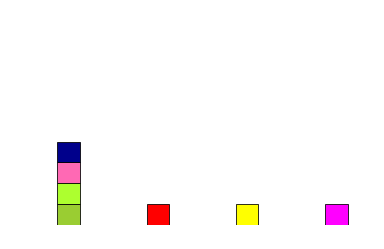

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


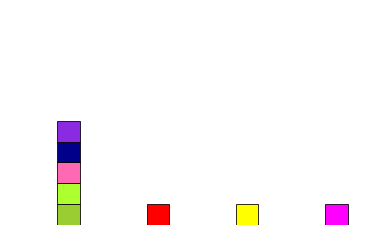

T: No, now you cannot put b1 in the tower because you must put red blocks on blue blocks
0.6500975917087181 0.3499024082912819
[1. 1. 0.] 0.0
[0.         0.         0.54509807] 1.0
[1. 0. 0.] 1.0
[1. 0. 0.] 0.5
[0.5411765  0.16862746 0.8862745 ] 0


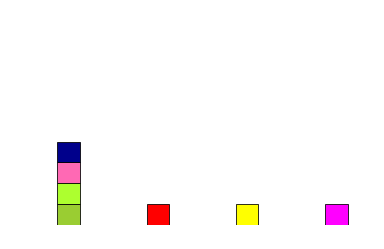

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


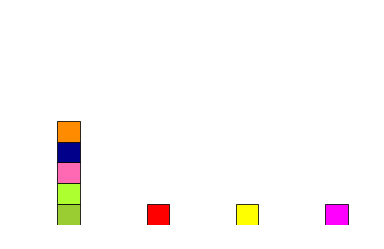

T: No, now you cannot put b1 in the tower because you must put red blocks on blue blocks
1.0 0.0
[1. 1. 0.] 0.0
[0.         0.         0.54509807] 1.0
[1. 0. 0.] 1.0
[1. 0. 0.] 0.5
[0.5411765  0.16862746 0.8862745 ] 0
[1.         0.54901963 0.        ] 0.0


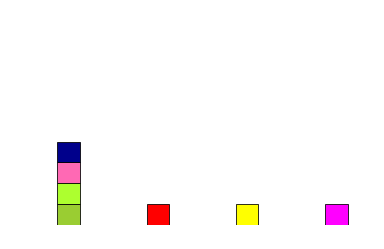

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


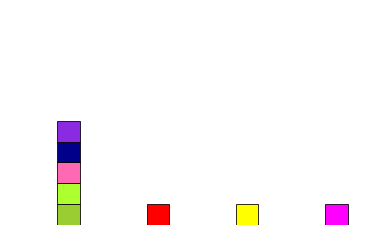

T: No, now you cannot put b1 in the tower because you must put red blocks on blue blocks
1.0 0.0
[1. 1. 0.] 0.0
[0.         0.         0.54509807] 1.0
[1. 0. 0.] 1.0
[1. 0. 0.] 0.999841700057918
[0.5411765  0.16862746 0.8862745 ] 0
[1.         0.54901963 0.        ] 0.0
[0.5411765  0.16862746 0.8862745 ] 0.0


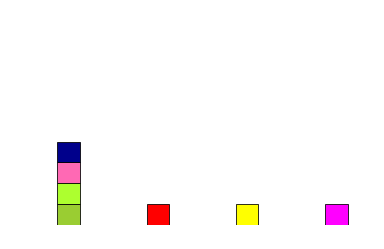

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


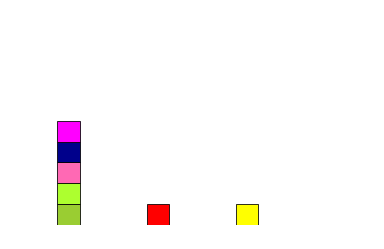

T: No, now you cannot put b1 in the tower because you must put red blocks on blue blocks
1.0 0.0
[1. 1. 0.] 0.0
[0.         0.         0.54509807] 1.0
[1. 0. 0.] 1.0
[1. 0. 0.] 0.5
[0.5411765  0.16862746 0.8862745 ] 0
[1.         0.54901963 0.        ] 0.0
[0.5411765  0.16862746 0.8862745 ] 0.0
[1. 0. 1.] 0.0


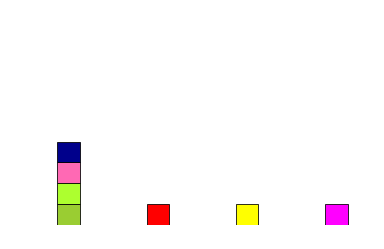

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


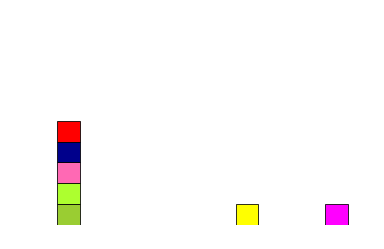

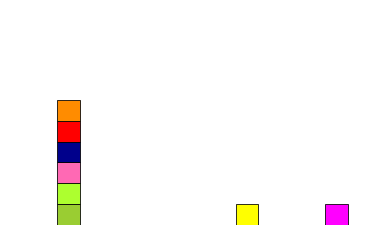

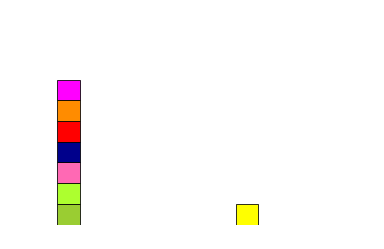

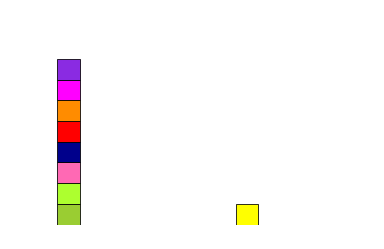

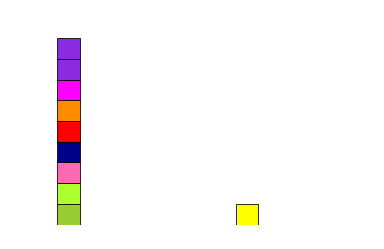

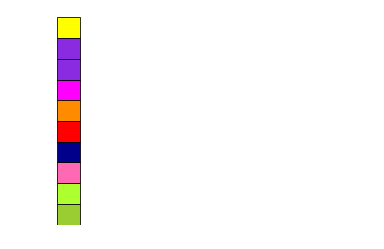

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem3.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


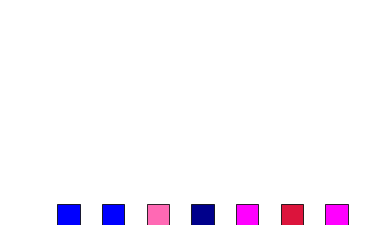

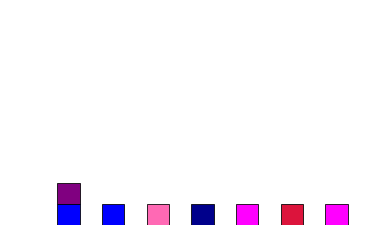

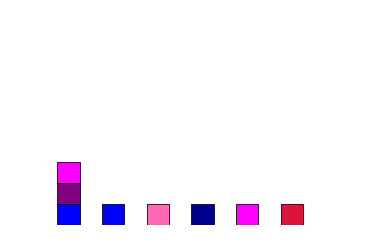

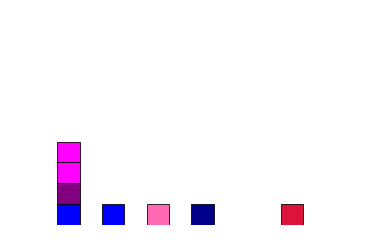

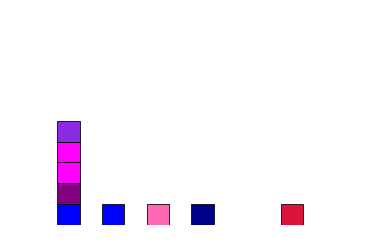

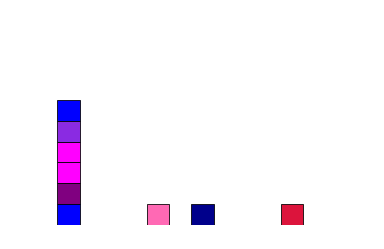

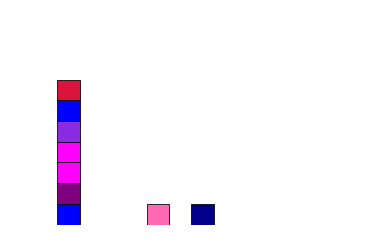

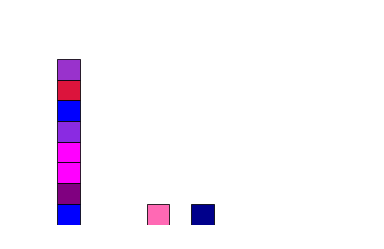

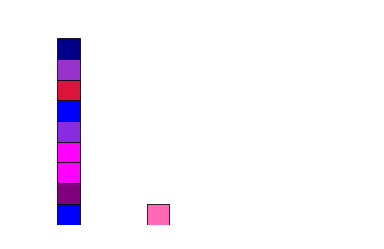

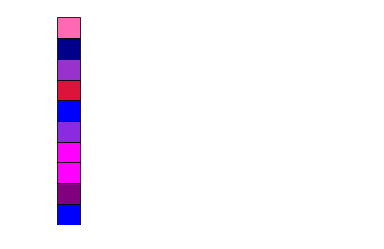

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem47.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


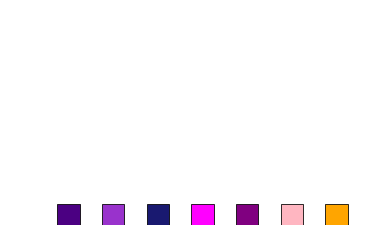

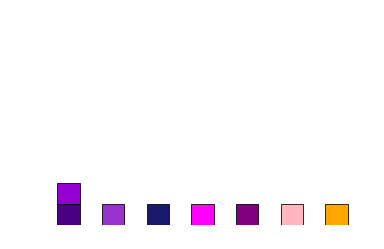

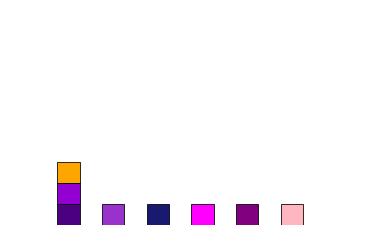

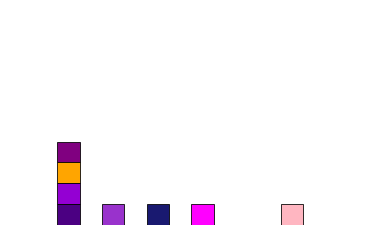

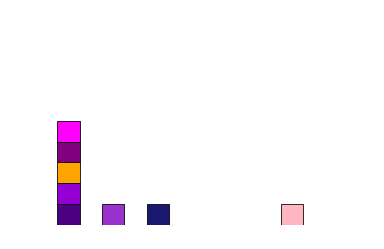

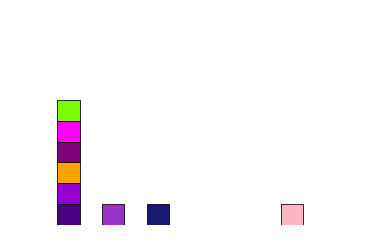

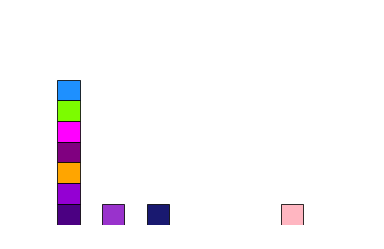

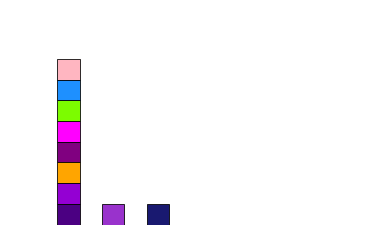

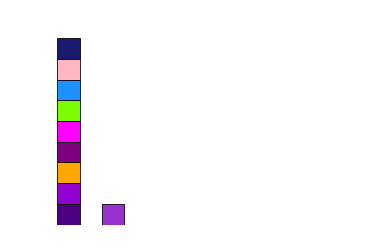

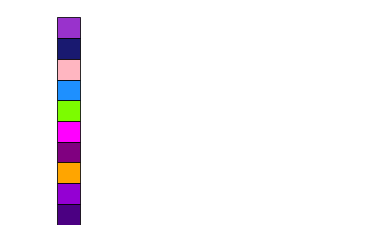

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem21.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


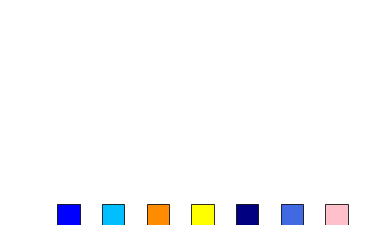

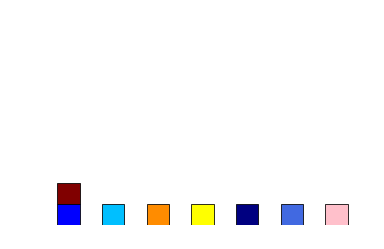

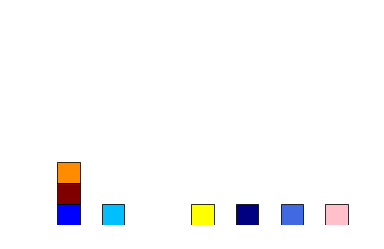

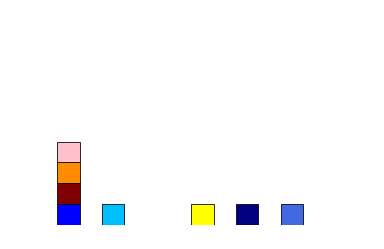

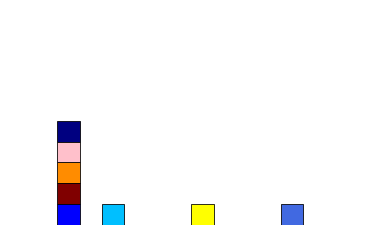

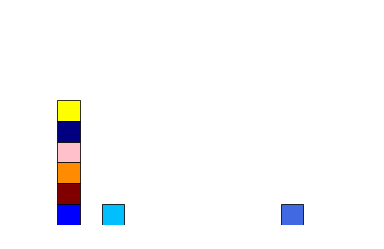

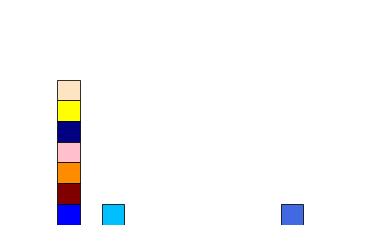

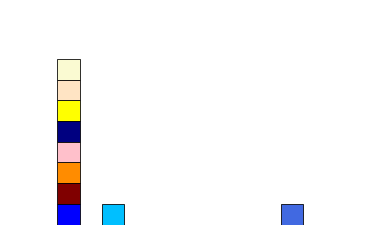

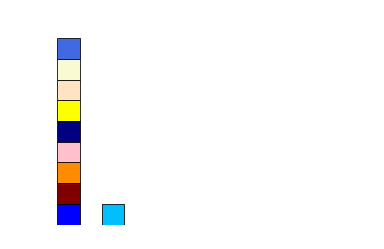

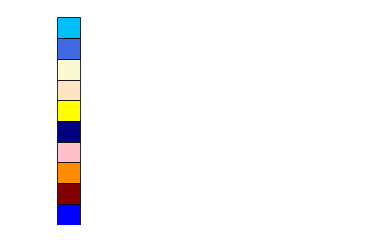

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem4.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop

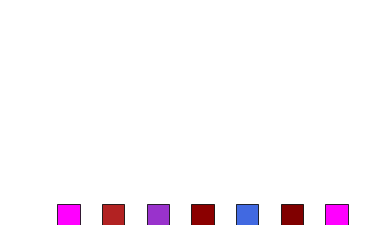

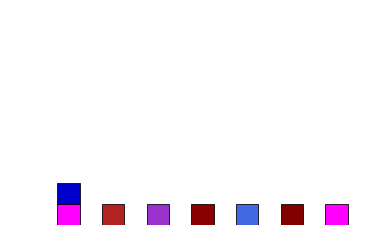

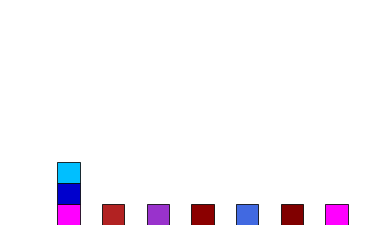

T: No, now you cannot put b0 in the tower because you must put red blocks on blue blocks
0.964562459844664 0.03543754015533594
[0.        0.7490196 1.       ] 0.999237170292731
[0.        0.        0.8039216] 0.0007628297072690275
[0.69803923 0.13333334 0.13333334] 0.5003814148536345
[0.69803923 0.13333334 0.13333334] 0.9996185851463655


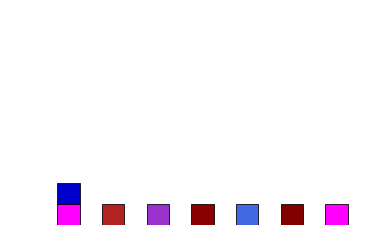

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


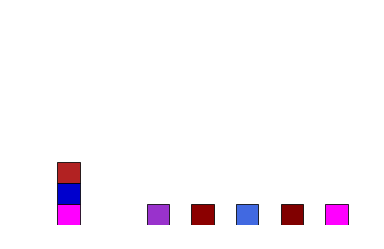

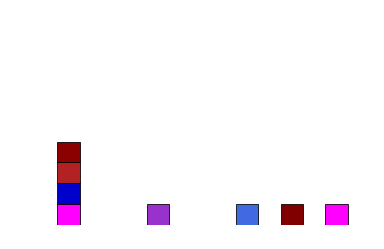

T: no, put red blocks on blue blocks
0.6631329503378559 0.33686704966214415
[0.        0.7490196 1.       ] 0.0
[0.        0.        0.8039216] 1.0
[0.69803923 0.13333334 0.13333334] 1.0
[0.69803923 0.13333334 0.13333334] 0.0
[0.54509807 0.         0.        ] 1


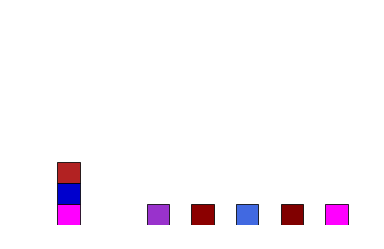

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


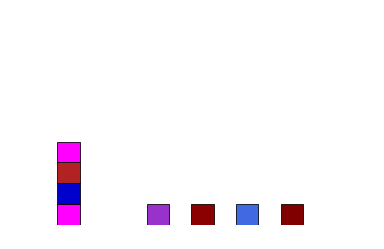

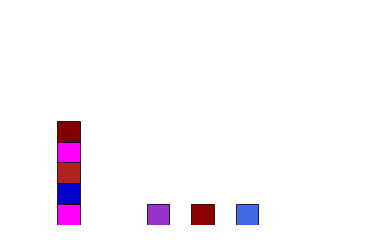

T: no, put red blocks on blue blocks
0.015856380702158678 0.9841436192978413
[0.        0.7490196 1.       ] 0.0
[0.        0.        0.8039216] 1.0
[0.69803923 0.13333334 0.13333334] 1.0
[0.69803923 0.13333334 0.13333334] 0.0
[0.54509807 0.         0.        ] 1
[0.5019608 0.        0.       ] 0.6666666666666667
[1. 0. 1.] 0.33333333333333337


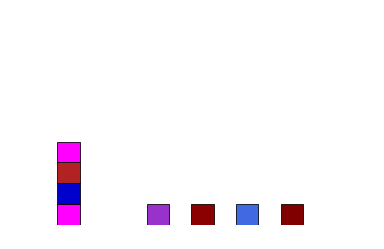

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


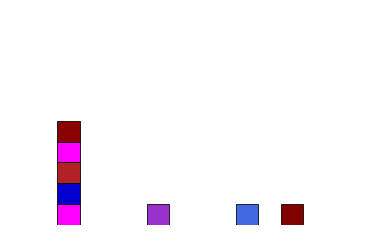

T: no, put red blocks on blue blocks
1.0 0.0
[0.        0.7490196 1.       ] 0.0
[0.        0.        0.8039216] 1.0
[0.69803923 0.13333334 0.13333334] 1.0
[0.69803923 0.13333334 0.13333334] 0.0
[0.54509807 0.         0.        ] 1
[0.5019608 0.        0.       ] 1.0
[1. 0. 1.] 0.0


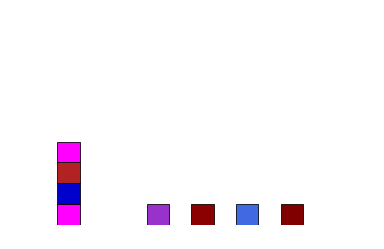

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


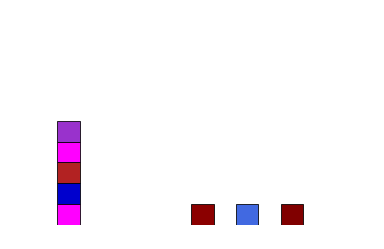

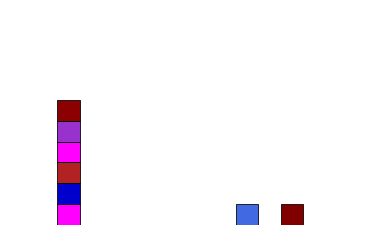

T: no, put red blocks on blue blocks
1.0 0.0
[0.        0.7490196 1.       ] 0.0
[0.        0.        0.8039216] 1.0
[0.69803923 0.13333334 0.13333334] 1.0
[0.69803923 0.13333334 0.13333334] 0.0
[0.54509807 0.         0.        ] 1
[0.5019608 0.        0.       ] 1.0
[1. 0. 1.] 0.0
[0.6        0.19607843 0.8       ] 0.0


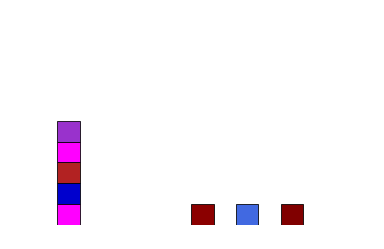

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


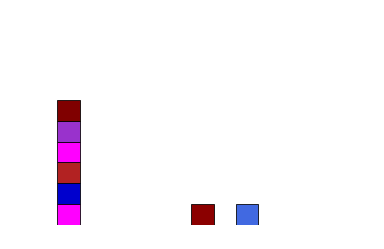

T: no, put red blocks on blue blocks
1.0 0.0
[0.        0.7490196 1.       ] 0.0
[0.        0.        0.8039216] 1.0
[0.69803923 0.13333334 0.13333334] 1.0
[0.69803923 0.13333334 0.13333334] 0.0
[0.54509807 0.         0.        ] 1
[0.5019608 0.        0.       ] 1.0
[1. 0. 1.] 0.0
[0.6        0.19607843 0.8       ] 0.0


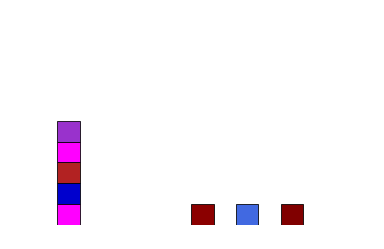

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


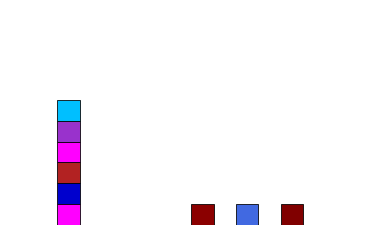

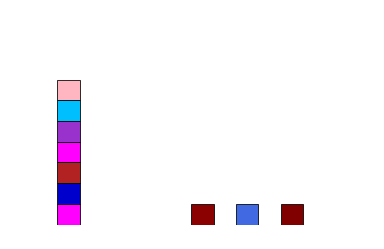

T: No, now you cannot put b2 in the tower because you must put red blocks on blue blocks
0.9952325114398409 0.004767488560158996
[0.        0.7490196 1.       ] 0.0
[0.        0.        0.8039216] 1.0
[0.69803923 0.13333334 0.13333334] 1.0
[0.69803923 0.13333334 0.13333334] 0.0
[0.54509807 0.         0.        ] 1
[0.5019608 0.        0.       ] 1.0
[1. 0. 1.] 0.0
[0.6        0.19607843 0.8       ] 0.0
[1.         0.7137255  0.75686276] 0.19999999999999998
[0.        0.7490196 1.       ] 0.7999999999999999
[0.54509807 0.         0.        ] 0.6


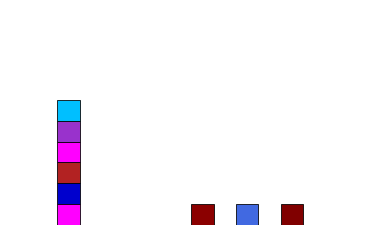

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


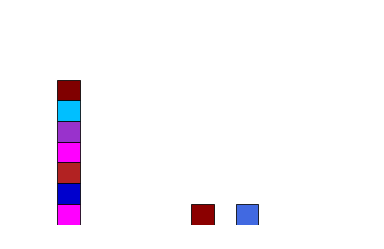

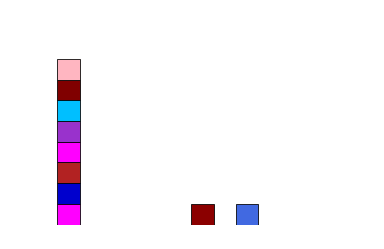

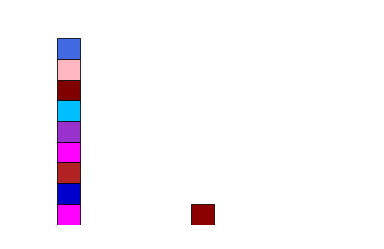

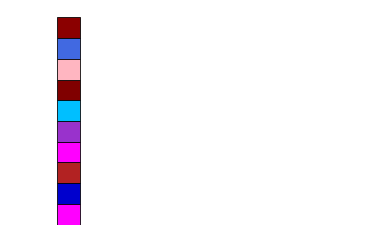

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem32.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


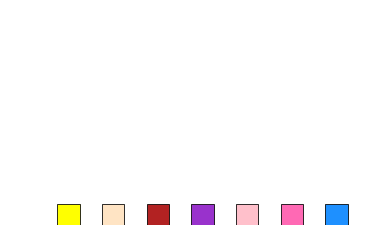

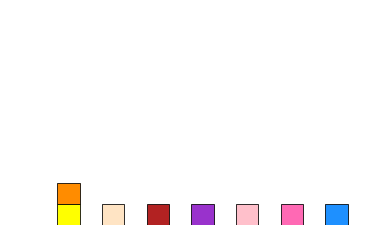

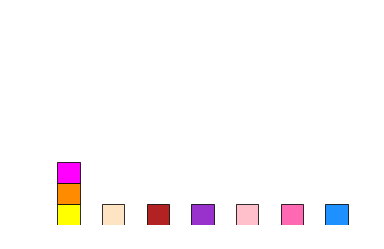

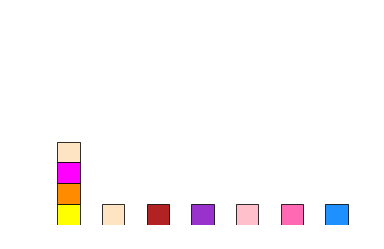

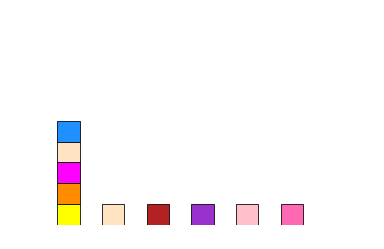

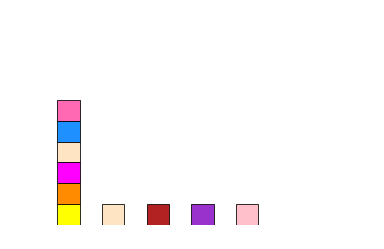

T: No, now you cannot put b1 in the tower because you must put red blocks on blue blocks
0.7986275584414222 0.20137244155857792
[1.        0.4117647 0.7058824] 0.3291344864705387
[0.11764706 0.5647059  1.        ] 0.6708655135294612
[0.69803923 0.13333334 0.13333334] 0.8354327567647306
[0.69803923 0.13333334 0.13333334] 0.3473390169618254


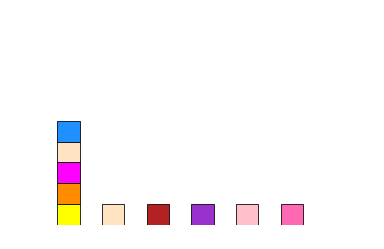

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


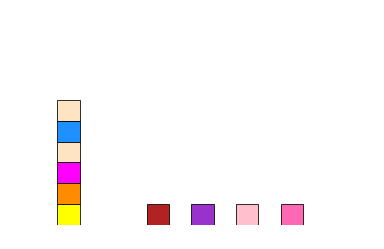

T: No, now you cannot put b1 in the tower because you must put red blocks on blue blocks
0.32388564637948125 0.6761143536205187
[1.        0.4117647 0.7058824] 0.0
[0.11764706 0.5647059  1.        ] 1.0
[0.69803923 0.13333334 0.13333334] 1.0
[0.69803923 0.13333334 0.13333334] 0.5
[1.         0.89411765 0.76862746] 0


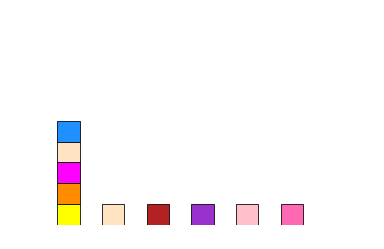

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


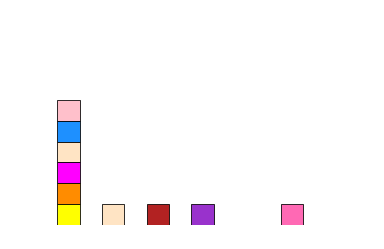

T: No, now you cannot put b1 in the tower because you must put red blocks on blue blocks
1.0 0.0
[1.        0.4117647 0.7058824] 0.0
[0.11764706 0.5647059  1.        ] 1.0
[0.69803923 0.13333334 0.13333334] 1.0
[0.69803923 0.13333334 0.13333334] 0.09870755484297854
[1.         0.89411765 0.76862746] 0
[1.         0.7529412  0.79607844] 0.0


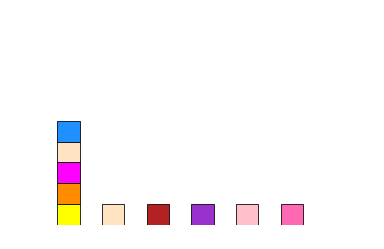

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


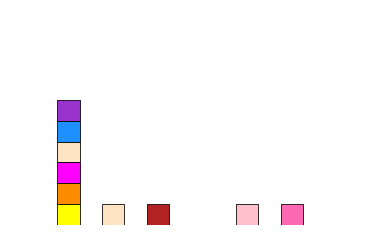

T: No, now you cannot put b1 in the tower because you must put red blocks on blue blocks
1.0 0.0
[1.        0.4117647 0.7058824] 0.0
[0.11764706 0.5647059  1.        ] 1.0
[0.69803923 0.13333334 0.13333334] 1.0
[0.69803923 0.13333334 0.13333334] 0.12903767813381936
[1.         0.89411765 0.76862746] 0
[1.         0.7529412  0.79607844] 0.0
[0.6        0.19607843 0.8       ] 0.0


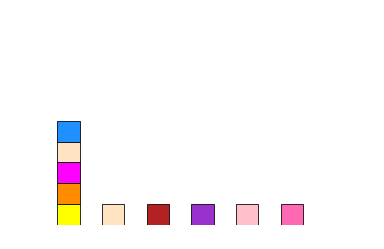

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


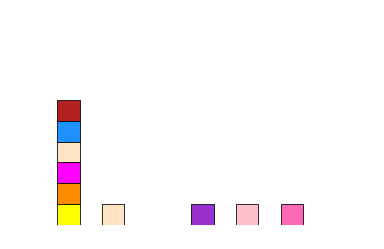

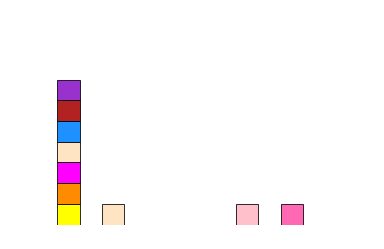

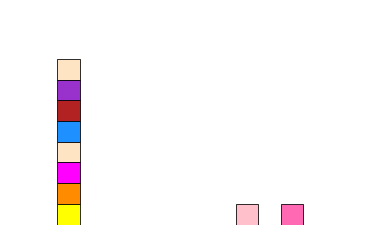

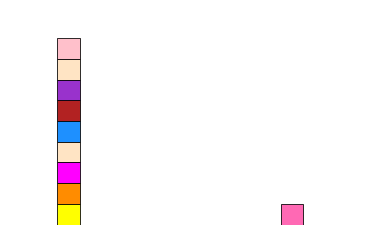

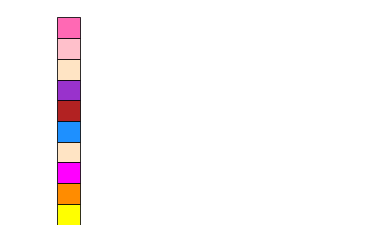

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem13.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Deskto

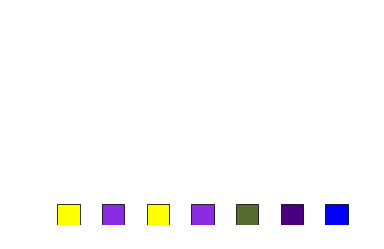

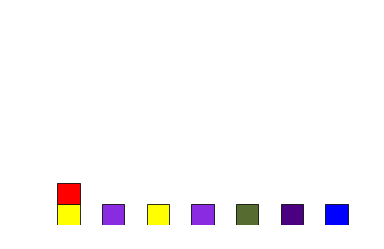

T: no, put red blocks on blue blocks
0.9036779710600388 0.09632202893996117
[1. 0. 0.] 0.0005668889814916679
[1. 1. 0.] 0.9994331110185083


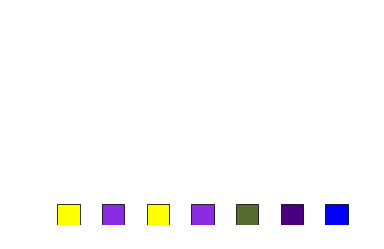

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/doma

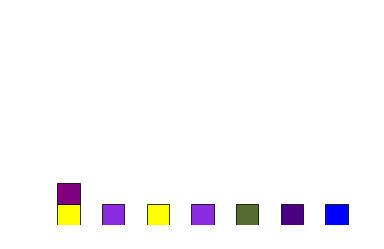

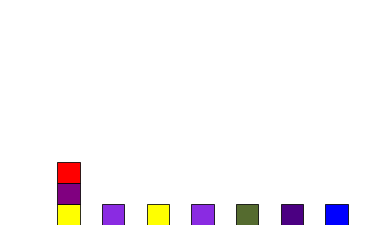

T: no, put red blocks on blue blocks
0.0017440832068912433 0.9982559167931088
[1. 0. 0.] 0.000585400948288671
[1. 1. 0.] 0.9994145990517114
[0.5019608 0.        0.5019608] 0.9994145990517114


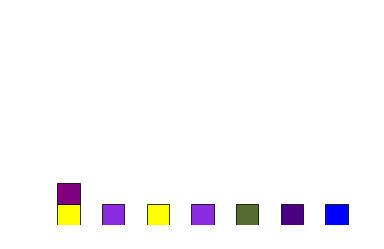

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/doma

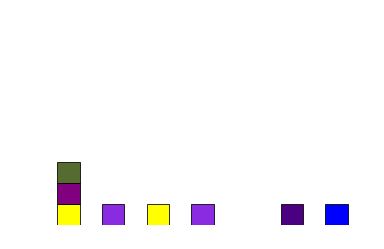

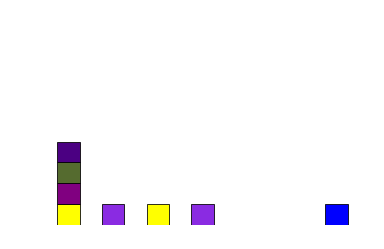

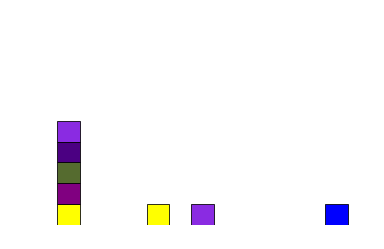

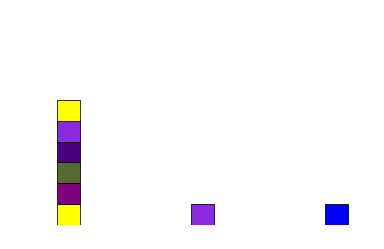

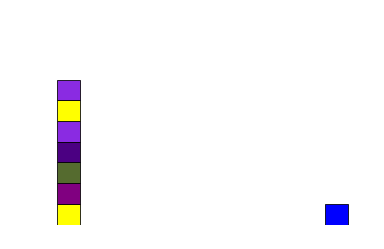

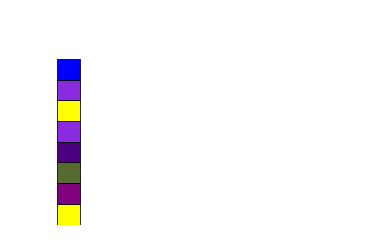

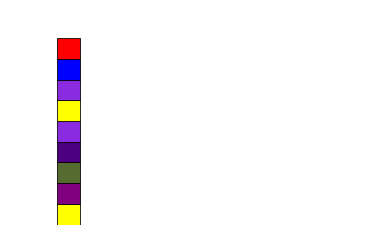

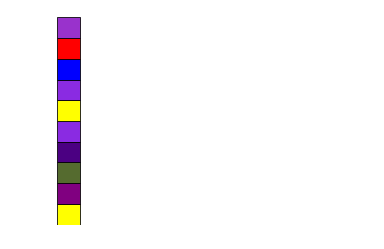

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/onerule/problem5.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


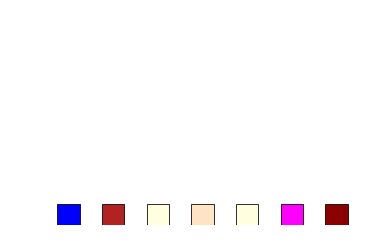

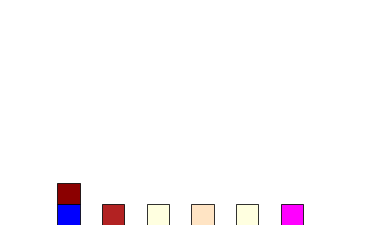

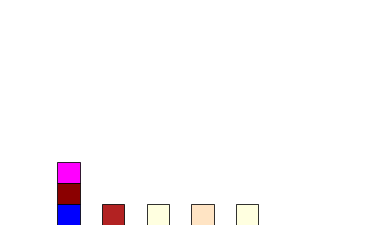

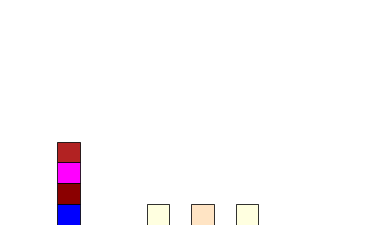

T: no, put red blocks on blue blocks
0.9959960687459491 0.004003931254050875
[0.69803923 0.13333334 0.13333334] 0.7984502907445611
[1. 0. 1.] 0.2015497092554389


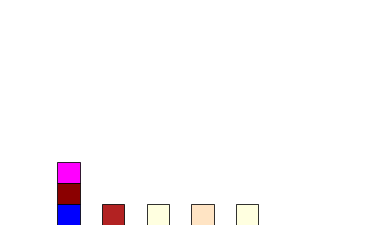

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


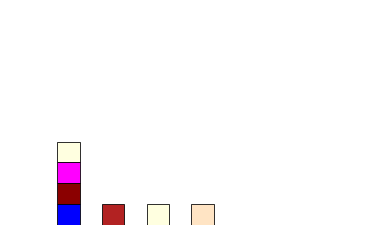

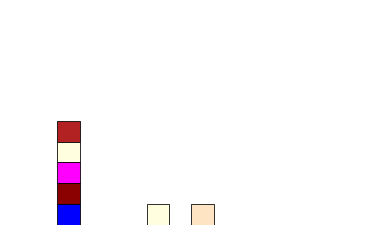

T: no, put red blocks on blue blocks
0.9965596509800143 0.003440349019985633
[0.69803923 0.13333334 0.13333334] 0.0032645437888906108
[1. 0. 1.] 0.9967354562111095
[1.        1.        0.8784314] 0.9967354562111095


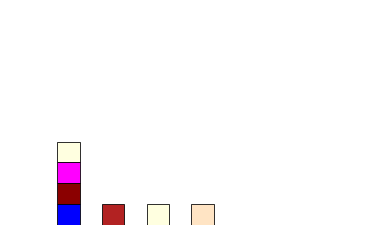

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


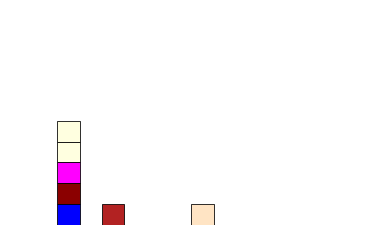

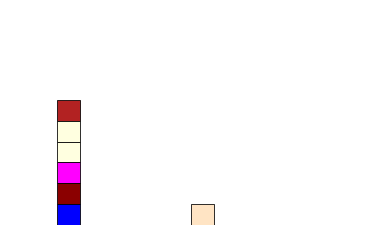

T: no, put red blocks on blue blocks
0.05971349541602855 0.9402865045839714
[0.69803923 0.13333334 0.13333334] 0.963265358973205
[1. 0. 1.] 0.03673464102679503
[1.        1.        0.8784314] 0.03673464102679503
[1.        1.        0.8784314] 0.03673464102679503


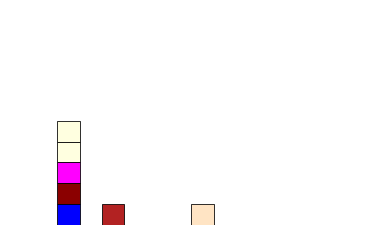

/home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl


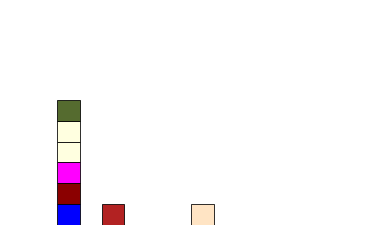

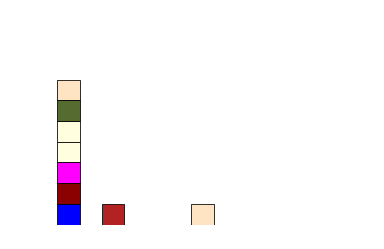

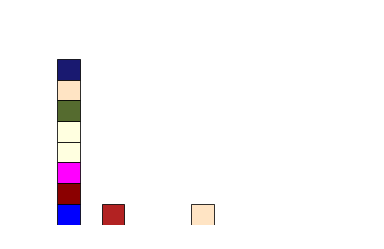

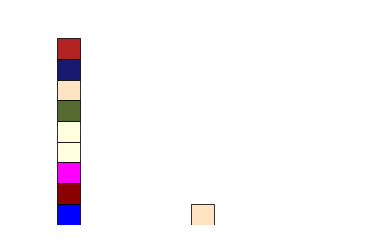

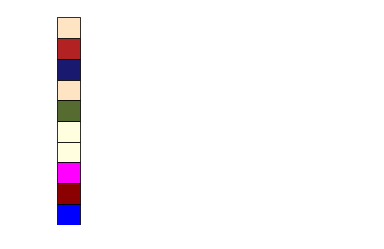

In [27]:
problem_name = 'onerule'
config = get_config()
data_location = config['data_location']
problem_dir = os.path.join(data_location, problem_name)
problems = os.listdir(problem_dir)
teacher = TeacherAgent()
w = world.PDDLWorld('blocks-domain.pddl', os.path.join(problem_dir, problems[0]))
agent = PGMCorrectingAgent(w, teacher=teacher)
vis=True
no_correction_update = False
for problem in problems:
    w = world.PDDLWorld('blocks-domain.pddl', os.path.join(problem_dir, problem))
    agent.new_world(w)
    while not w.test_success():
        plan = agent.plan()
        for a, args in plan:
            if a == 'reach-goal':
                break
            w.update(a, args)
            if vis:
                w.draw()
            correction = agent.teacher.correction(w)
            if correction:
                print("T: " + correction)
                agent.get_correction(correction, a, args)
                if vis:
                    w.draw()
                break
            elif no_correction_update:
                agent.no_correction(a, args)

In [ ]:
inf = agent.pgm_model.inference

In [ ]:
q = inf.query(variables=['rule1', 'rule2', 'red', 'blue'], 
                evidence={'r1':0, 'g1':0.5, 'b1':0.8, 'corr':1, 'r2':1, 'g2':0.8, 'b2':0.4}, 
                elimination_order=['violated_r1', 'violated_r2'])
print(q['red'])
print(q['blue'])
print(q['rule1'])
print(q['rule2'])

In [ ]:
a = {'3':2, '2':1}
b = {'1':1, '2':2}
a.update(b)

In [ ]:
a

In [ ]:
{'a':1}.update({'b':1})


In [ ]:
[print(f.asPDDL()) for f in create_goal_options(['red'], ['blue'])]

In [ ]:
f1, f2 = create_goal_options('red', 'blue')

In [ ]:
f1.